Please upload your 'Copy of Harvard' CSV file:


Saving Copy of Harvard - Harvard Dataset.csv to Copy of Harvard - Harvard Dataset.csv

Uploaded file: 'Copy of Harvard - Harvard Dataset.csv'

Successfully loaded data with 290 rows and 23 columns.

First 5 rows of the data:
  Institution Course Number Launch Date  \
0        MITx        6.002x    9/5/2012   
1        MITx         6.00x   9/26/2012   
2        MITx        3.091x   10/9/2012   
3    HarvardX         CS50x  10/15/2012   
4    HarvardX        PH207x  10/15/2012   

                                        Course Title  \
0                           Circuits and Electronics   
1   Introduction to Computer Science and Programming   
2              Introduction to Solid State Chemistry   
3                   Introduction to Computer Science   
4  Health in Numbers: Quantitative Methods in Cli...   

                                         Instructors  \
0                                     Khurram Afridi   
1            Eric Grimson, John Guttag, Chris Terman   
2          

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Course Subject']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Course Subject']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


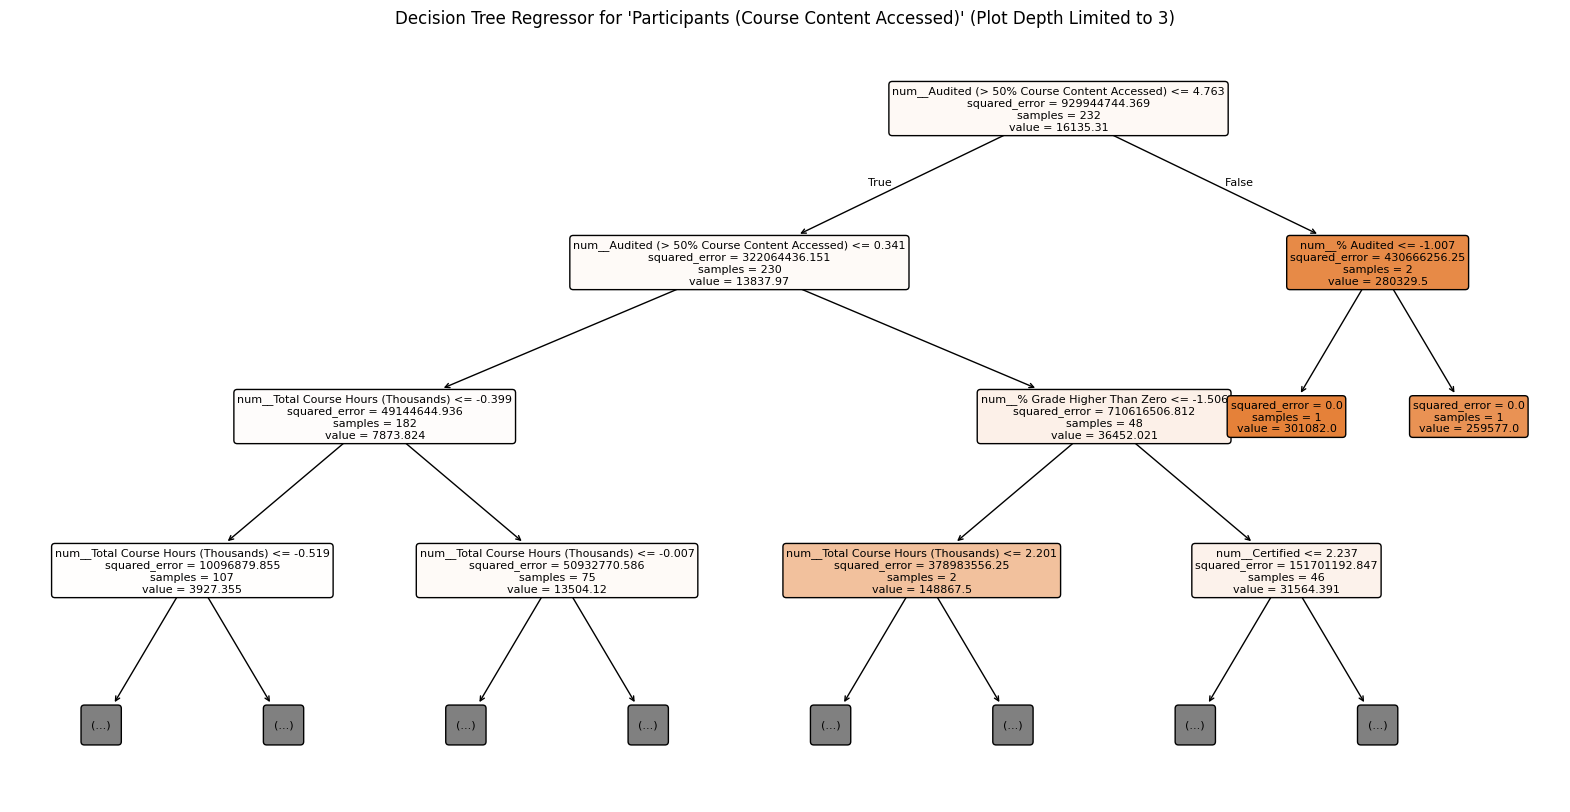

In [ ]:
import pandas as pnd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. File Upload ---
print("Please upload your 'Copy of Harvard' CSV file:")
uploaded = files.upload()

# Check if file was uploaded
if not uploaded:
    print("\nNo file uploaded. Please run the cell again and upload the file.")
else:
    # Get the filename (assuming only one file uploaded)
    filename = list(uploaded.keys())[0]
    print(f"\nUploaded file: '{filename}'")

    try:
        # --- 2. Load Data ---
        # Use io.BytesIO to read the uploaded bytes directly
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
        print(f"\nSuccessfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        print("\nFirst 5 rows of the data:")
        print(df.head())
        print("\nData Info:")
        df.info()

        # --- 3. Data Cleaning & Preparation ---
        target_col = 'Participants (Course Content Accessed)'

        # Check if target column exists
        if target_col not in df.columns:
             raise ValueError(f"Target column '{target_col}' not found in the uploaded file.")

        print(f"\nTarget variable: '{target_col}'")

        # Replace '---' with NaN for proper handling
        print("\nReplacing '---' with NaN...")
        df.replace('---', np.nan, inplace=True)

        # Define columns to drop (identifiers, high cardinality text, redundant)
        cols_to_drop = [
            'Institution', 'Course Number', 'Launch Date', 'Course Title',
            'Instructors', target_col # Also drop target from features later
        ]
        # Ensure columns exist before trying to drop
        cols_exist_to_drop = [col for col in cols_to_drop if col in df.columns and col != target_col]
        print(f"\nDropping columns: {cols_exist_to_drop}")

        # Separate features (X) and target (y) *before* extensive cleaning on X
        y = df[target_col]
        X = df.drop(columns=cols_exist_to_drop + [target_col], errors='ignore') # Drop from X

        print(f"\nFeatures used for X (after initial drop): {list(X.columns)}")

        # Convert potential numeric columns to numeric, coercing errors
        print("\nConverting feature columns to numeric (errors='coerce')...")
        for col in X.columns:
             # Check if the column is not already numeric before converting
            if not pd.api.types.is_numeric_dtype(X[col]):
                try:
                    # Attempt conversion only if not explicitly object/category meant to be kept as such
                    # We'll rely on the dtype separation later to handle actual categoricals
                    X[col] = pd.to_numeric(X[col], errors='coerce')
                    print(f"  - Converted '{col}'")
                except Exception as e:
                     # This might happen for genuine object columns we want to keep
                    print(f"  - Could not convert '{col}' to numeric, keeping as is for now. Error: {e}")
            else:
                print(f"  - Column '{col}' is already numeric.")


        # Convert target to numeric and handle potential errors
        print(f"\nConverting target column '{target_col}' to numeric...")
        y = pd.to_numeric(y, errors='coerce')

        # Remove rows where the *target* variable is NaN (essential)
        print(f"\nOriginal rows: {len(X)}")
        valid_target_indices = y.notna()
        X = X[valid_target_indices]
        y = y[valid_target_indices]
        print(f"Rows after removing NaN in target: {len(X)}")

        if X.empty:
            raise ValueError("No valid data remaining after cleaning target variable. Check your data.")

        # --- 4. Identify Feature Types ---
        numerical_features = X.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

        print(f"\nNumerical features identified: {numerical_features}")
        print(f"Categorical features identified: {categorical_features}")

        # --- 5. Preprocessing Pipeline ---
        # Numerical transformer: Impute missing with median, then scale
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # Categorical transformer: Impute missing with most frequent, then one-hot encode
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False easier for feature names
        ])

        # ColumnTransformer to apply different transformers to different columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='passthrough' # Keep any columns not specified (shouldn't be any here)
        )

        # --- 6. Train-Test Split ---
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print(f"\nTraining set size: {X_train.shape[0]} samples")
        print(f"Test set size: {X_test.shape[0]} samples")

        # --- 7. Model Definition ---
        # Using DecisionTreeRegressor because the target is a count (continuous)
        # Limit max_depth to prevent overfitting and for visualization
        dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)

        # --- 8. Create Full Pipeline ---
        # Combine preprocessor and the regressor model
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', dt_regressor)
        ])

        # --- 9. Train Model ---
        print("\nTraining the Decision Tree Regressor pipeline...")
        model_pipeline.fit(X_train, y_train)
        print("Training complete.")

        # --- 10. Evaluate Model ---
        print("\nEvaluating the model on the test set...")
        y_pred = model_pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"R-squared (R²) Score: {r2:.4f}")
        # Interpretation hint: R^2 is the proportion of variance explained. Closer to 1 is better.

        # --- 11. Visualize Tree (Optional) ---
        print("\nGenerating decision tree visualization (limited depth)...")

        # Get feature names after preprocessing (including one-hot encoded ones)
        try:
            # Access the fitted preprocessor and then the categorical one-hot encoder
            feature_names_out = model_pipeline.named_steps['preprocessor'] \
                                .get_feature_names_out()
        except Exception as e:
            print(f"Could not get feature names for visualization: {e}")
            feature_names_out = None # Fallback

        if feature_names_out is not None:
            plt.figure(figsize=(20, 10))
            plot_tree(
                model_pipeline.named_steps['regressor'],
                feature_names=feature_names_out,
                filled=True,
                rounded=True,
                max_depth=3,  # Limit plot depth for readability
                fontsize=8
            )
            plt.title(f"Decision Tree Regressor for '{target_col}' (Plot Depth Limited to 3)")
            plt.show()
        else:
             print("Skipping visualization as feature names could not be retrieved.")

    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found after upload.")
    except pd.errors.EmptyDataError:
        print(f"Error: The uploaded file '{filename}' is empty.")
    except ValueError as ve:
        print(f"Data Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

--------------------------------------------------
Coursera Course Enrollment Decision Tree Generator
--------------------------------------------------

Please upload the 'Copy of Coursera.csv' file:


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data.csv

Uploaded file 'Copy of Coursera - CourseEra Data.csv' successfully.

Loading and processing data...

Data loaded successfully. First 5 rows:
                                          course_title  \
134  (ISC)² Systems Security Certified Practitioner...   
743  A Crash Course in Causality:  Inferring Causal...   
874                     A Crash Course in Data Science   
413                            A Law Student's Toolkit   
635                A Life of Happiness and Fulfillment   

            course_organization course_Certificate_type  course_rating  \
134                      (ISC)²          SPECIALIZATION            4.7   
743  University of Pennsylvania                  COURSE            4.7   
874    Johns Hopkins University                  COURSE            4.5   
413             Yale University                  COURSE            4.7   
635   Indian School of Business                  COUR

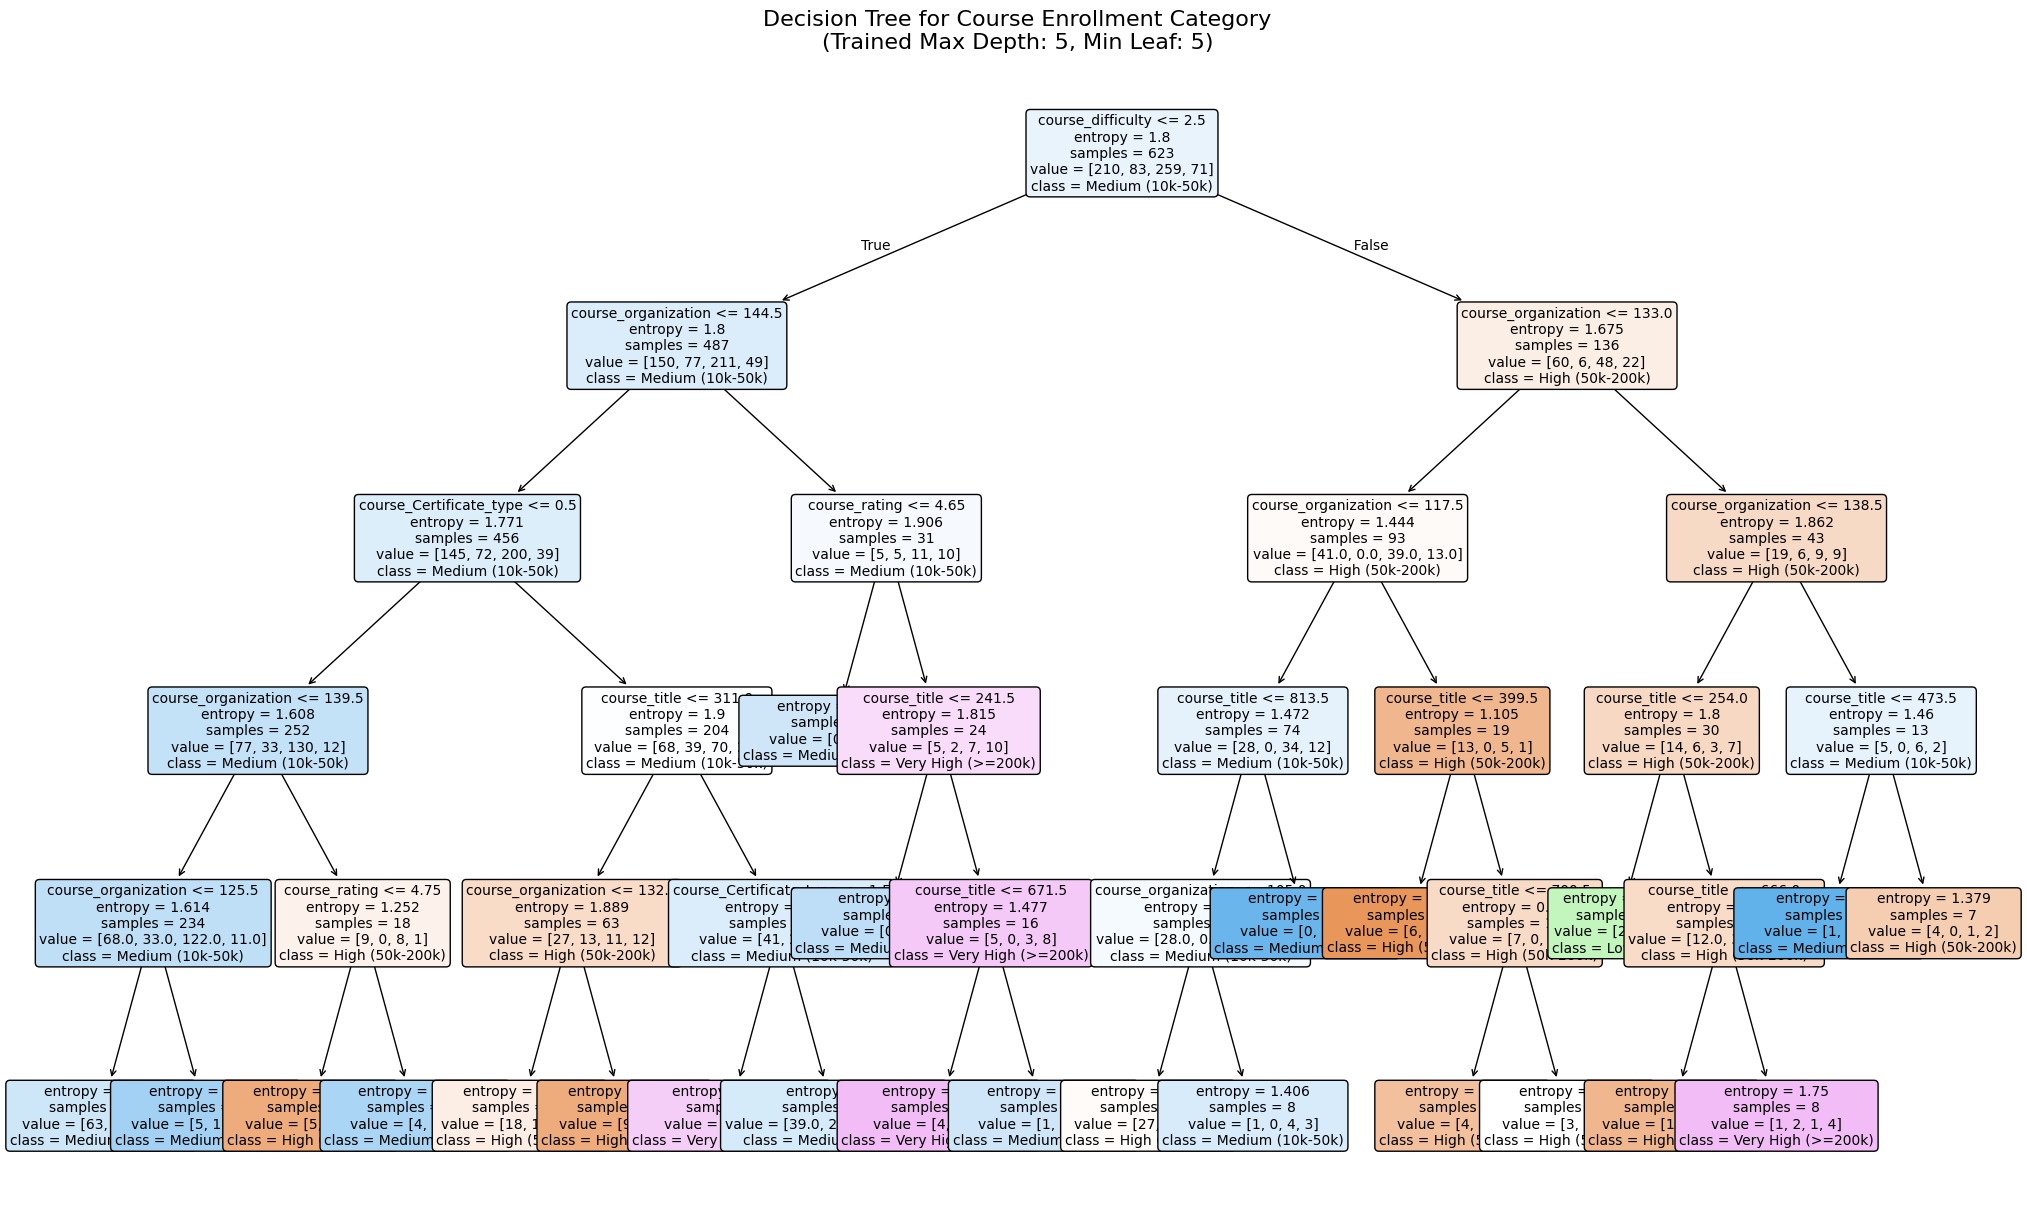


--- Script Finished ---


In [ ]:
#@title Decision Tree Generator for Coursera Data

# Step 1: Install necessary libraries (usually pre-installed in Colab)
# !pip install scikit-learn pandas matplotlib

# Step 2: Import libraries
import pandas as pd
from google.colab import files
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

print("--------------------------------------------------")
print("Coursera Course Enrollment Decision Tree Generator")
print("--------------------------------------------------\n")

# Step 3: Upload the CSV file
print("Please upload the 'Copy of Coursera.csv' file:")
uploaded = files.upload()

if not uploaded:
    print("\nNo file uploaded. Exiting.")
else:
    # Get the filename (assuming only one file is uploaded)
    filename = list(uploaded.keys())[0]
    print(f"\nUploaded file '{filename}' successfully.")

    # Step 4: Load Data into pandas DataFrame
    try:
        print("\nLoading and processing data...")
        # Read the raw bytes, decode, find header, read CSV
        data_string = uploaded[filename].decode('utf-8')

        # Find the actual header line (starts with ',course_title')
        header_line_index = -1
        lines = data_string.splitlines()
        for i, line in enumerate(lines):
            # Use strip() to handle potential leading/trailing whitespace
            if line.strip().startswith(',course_title,'):
                header_line_index = i
                break

        if header_line_index == -1:
             raise ValueError("Could not find the CSV header line starting with ',course_title,'. Please check the file format.")

        # Read the CSV using io.StringIO, skipping lines before the header
        # Use the first column (index) as the DataFrame index
        df = pd.read_csv(io.StringIO('\n'.join(lines[header_line_index:])), index_col=0)

        print("\nData loaded successfully. First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
        print("\nChecking for initial missing values:")
        print(df.isnull().sum())

    except Exception as e:
        print(f"\nError loading or parsing the CSV file: {e}")
        print("Please ensure the file is a valid CSV and matches the expected format.")
        df = None # Set df to None to prevent further processing

    if df is not None:
        # Step 5: Target Variable Preprocessing (course_students_enrolled)
        print("\n--- Preprocessing Target Variable: course_students_enrolled ---")
        target_col_original = 'course_students_enrolled'
        target_col_numeric = 'enrollment_numeric'
        target_col_category = 'enrollment_category'

        def parse_enrollment(enrollment_str):
            """Converts enrollment strings like '5.3k', '130k', '3.2m' to numbers."""
            if isinstance(enrollment_str, (int, float)): # Handle if already numeric
                 return enrollment_str
            if not isinstance(enrollment_str, str):
                 return np.nan # Handle non-string types gracefully

            num_str = enrollment_str.lower().strip()
            if 'k' in num_str:
                return float(num_str.replace('k', '')) * 1000
            elif 'm' in num_str:
                return float(num_str.replace('m', '')) * 1000000
            else:
                try:
                    # Try converting directly if no 'k' or 'm'
                    return float(num_str)
                except ValueError:
                    # Return NaN if conversion fails
                    return np.nan

        # Apply the conversion function
        df[target_col_numeric] = df[target_col_original].apply(parse_enrollment)

        # Handle potential NaNs from conversion
        if df[target_col_numeric].isnull().any():
            print(f"\nWarning: Found {df[target_col_numeric].isnull().sum()} missing or unparseable values in '{target_col_original}'.")
            median_enrollment = df[target_col_numeric].median()
            print(f"Filling these missing values with the median enrollment: {median_enrollment:.0f}")
            df[target_col_numeric].fillna(median_enrollment, inplace=True)
        else:
            print(f"Successfully converted '{target_col_original}' to numeric.")

        print("\nNumeric enrollment summary:")
        print(df[target_col_numeric].describe())

        # --- Binning the target variable for Classification ---
        # Define bins (Modify these edges based on your desired categories)
        # Example: <10k, 10k-50k, 50k-200k, >=200k
        # Using right=False includes the left edge: [min, max)
        bins = [0, 10000, 50000, 200000, np.inf]
        labels = ['Low (<10k)', 'Medium (10k-50k)', 'High (50k-200k)', 'Very High (>=200k)']
        print(f"\nBinning numeric enrollment into categories: {labels}")

        df[target_col_category] = pd.cut(df[target_col_numeric], bins=bins, labels=labels, right=False)

        # Check if binning resulted in any NaNs (e.g., if min value wasn't covered)
        if df[target_col_category].isnull().any():
            print("\nWarning: Some rows did not fall into the defined enrollment categories after binning.")
            print("Distribution before dropping NaNs:\n", df[target_col_category].value_counts(dropna=False))
            # Option: Drop rows that couldn't be binned
            df.dropna(subset=[target_col_category], inplace=True)
            print("Rows with unbinnable enrollment have been dropped.")
        else:
            print("\nEnrollment category distribution:")
            print(df[target_col_category].value_counts())


        # Step 6: Feature Preprocessing (Encoding Categorical Features)
        print("\n--- Preprocessing Features ---")

        # Identify categorical features (object type) and numerical features to keep
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = ['course_rating'] # Keep 'course_rating' as a numerical feature

        # Remove the original target column if it's still in the list
        if target_col_original in categorical_cols:
            categorical_cols.remove(target_col_original)

        print(f"Identified Categorical Features for Encoding: {categorical_cols}")
        print(f"Numerical Features to Keep: {numerical_cols}")

        # Apply Label Encoding
        encoders = {}
        df_encoded = df.copy() # Work on a copy to keep original df intact

        for col in categorical_cols:
            # Handle potential NaNs *before* encoding
            if df_encoded[col].isnull().any():
                print(f"Note: Filling {df_encoded[col].isnull().sum()} NaNs in '{col}' with 'Missing' before encoding.")
                df_encoded[col].fillna('Missing', inplace=True)

            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoders[col] = le # Store encoder if needed later
            print(f"Encoded '{col}'.")

        print("\nData after encoding (showing first 5 rows of relevant columns):")
        display_cols = numerical_cols + categorical_cols + [target_col_category]
        print(df_encoded[display_cols].head())


        # Step 7: Define Features (X) and Target (y) and Split Data
        print("\n--- Splitting Data ---")
        feature_cols = numerical_cols + categorical_cols # Combine selected numerical and encoded categorical
        X = df_encoded[feature_cols]
        y = df_encoded[target_col_category]

        print(f"Using Features: {feature_cols}")
        print(f"Using Target: {target_col_category}")

        # Check if target has enough samples per class for stratification
        min_class_count = y.value_counts().min()
        stratify_flag = y if min_class_count > 1 else None # Stratify only if all classes have at least 2 samples

        if stratify_flag is None and len(y.unique()) > 1 :
             print("\nWarning: Cannot stratify due to classes with only one sample. Performing non-stratified split.")

        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=stratify_flag
            )
            print(f"\nSplit data into {len(X_train)} training and {len(X_test)} testing samples.")
            if stratify_flag is not None:
                print("Stratification applied.")
            print("Training set target distribution:\n", y_train.value_counts(normalize=True))
            print("\nTest set target distribution:\n", y_test.value_counts(normalize=True))
        except Exception as e:
             print(f"\nError during train/test split: {e}")
             # Fallback or exit if splitting fails critically
             X_train, X_test, y_train, y_test = None, None, None, None


        if X_train is not None:
            # Step 8: Train the Decision Tree Classifier
            print("\n--- Training Decision Tree ---")
            # --- Hyperparameters ---
            # You can adjust max_depth. Lower values give simpler trees. None means nodes expand until pure.
            # criterion='entropy' uses information gain for splits. 'gini' is another option.
            # min_samples_leaf=5 means a leaf node must have at least 5 samples. Helps prevent overfitting.
            tree_max_depth = 5
            min_samples_leaf = 5
            # ---

            dt_classifier = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=tree_max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            dt_classifier.fit(X_train, y_train)
            print(f"Decision Tree Classifier trained with max_depth={tree_max_depth}, min_samples_leaf={min_samples_leaf}.")


            # Step 9: Evaluate the Model
            print("\n--- Evaluating Model Performance ---")
            y_pred_train = dt_classifier.predict(X_train)
            y_pred_test = dt_classifier.predict(X_test)

            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)

            print(f"Training Accuracy: {train_accuracy:.4f}")
            print(f"Test Accuracy:     {test_accuracy:.4f}")

            print("\nClassification Report (Test Set):")
            # Use zero_division=0 to prevent warnings if a class has 0 predictions/support
            print(classification_report(y_test, y_pred_test, target_names=labels, zero_division=0))


            # Step 10: Visualize the Decision Tree
            print("\n--- Visualizing Decision Tree ---")
            try:
                plt.figure(figsize=(25, 15)) # Adjust figure size as needed

                # Use the actual class names learned by the classifier (handles potential encoding order differences)
                learned_class_names = dt_classifier.classes_.tolist()

                plot_tree(
                    dt_classifier,
                    filled=True,              # Color nodes by majority class
                    rounded=True,             # Use rounded rectangles
                    feature_names=X.columns.tolist(), # Use feature names
                    class_names=learned_class_names,  # Use class names in order
                    fontsize=10,              # Adjust font size
                    # max_depth=3             # Optionally limit plot depth for very large trees
                )
                plt.title((f"Decision Tree for Course Enrollment Category\n"
                          f"(Trained Max Depth: {dt_classifier.max_depth}, Min Leaf: {dt_classifier.min_samples_leaf})"),
                          fontsize=16)
                plt.show()
            except Exception as e:
                print(f"\nError during tree visualization: {e}")
                print("The tree might be too large to plot effectively, or there might be an issue with plot settings.")

print("\n--- Script Finished ---")

--------------------------------------------------------
Coursera Course Enrollment Decision Tree Regressor
--------------------------------------------------------

Please upload the 'Copy of Coursera.csv' file:


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data (1).csv

Uploaded file 'Copy of Coursera - CourseEra Data (1).csv' successfully.

Loading and processing data...

Data loaded successfully. First 5 rows:
                                          course_title  \
134  (ISC)² Systems Security Certified Practitioner...   
743  A Crash Course in Causality:  Inferring Causal...   
874                     A Crash Course in Data Science   
413                            A Law Student's Toolkit   
635                A Life of Happiness and Fulfillment   

            course_organization course_Certificate_type  course_rating  \
134                      (ISC)²          SPECIALIZATION            4.7   
743  University of Pennsylvania                  COURSE            4.7   
874    Johns Hopkins University                  COURSE            4.5   
413             Yale University                  COURSE            4.7   
635   Indian School of Business              

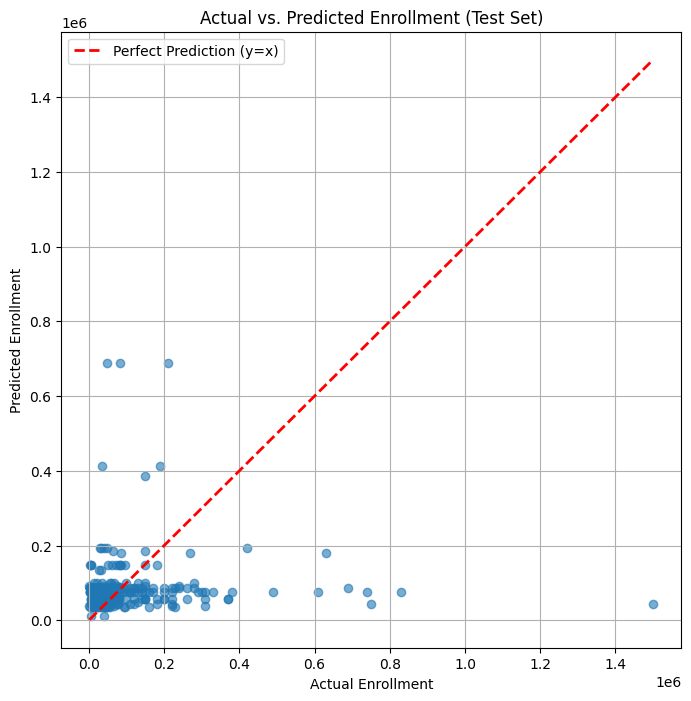


--- Visualizing Decision Tree Regressor ---
(Note: 'value' in each node now represents the predicted average enrollment for samples in that node)


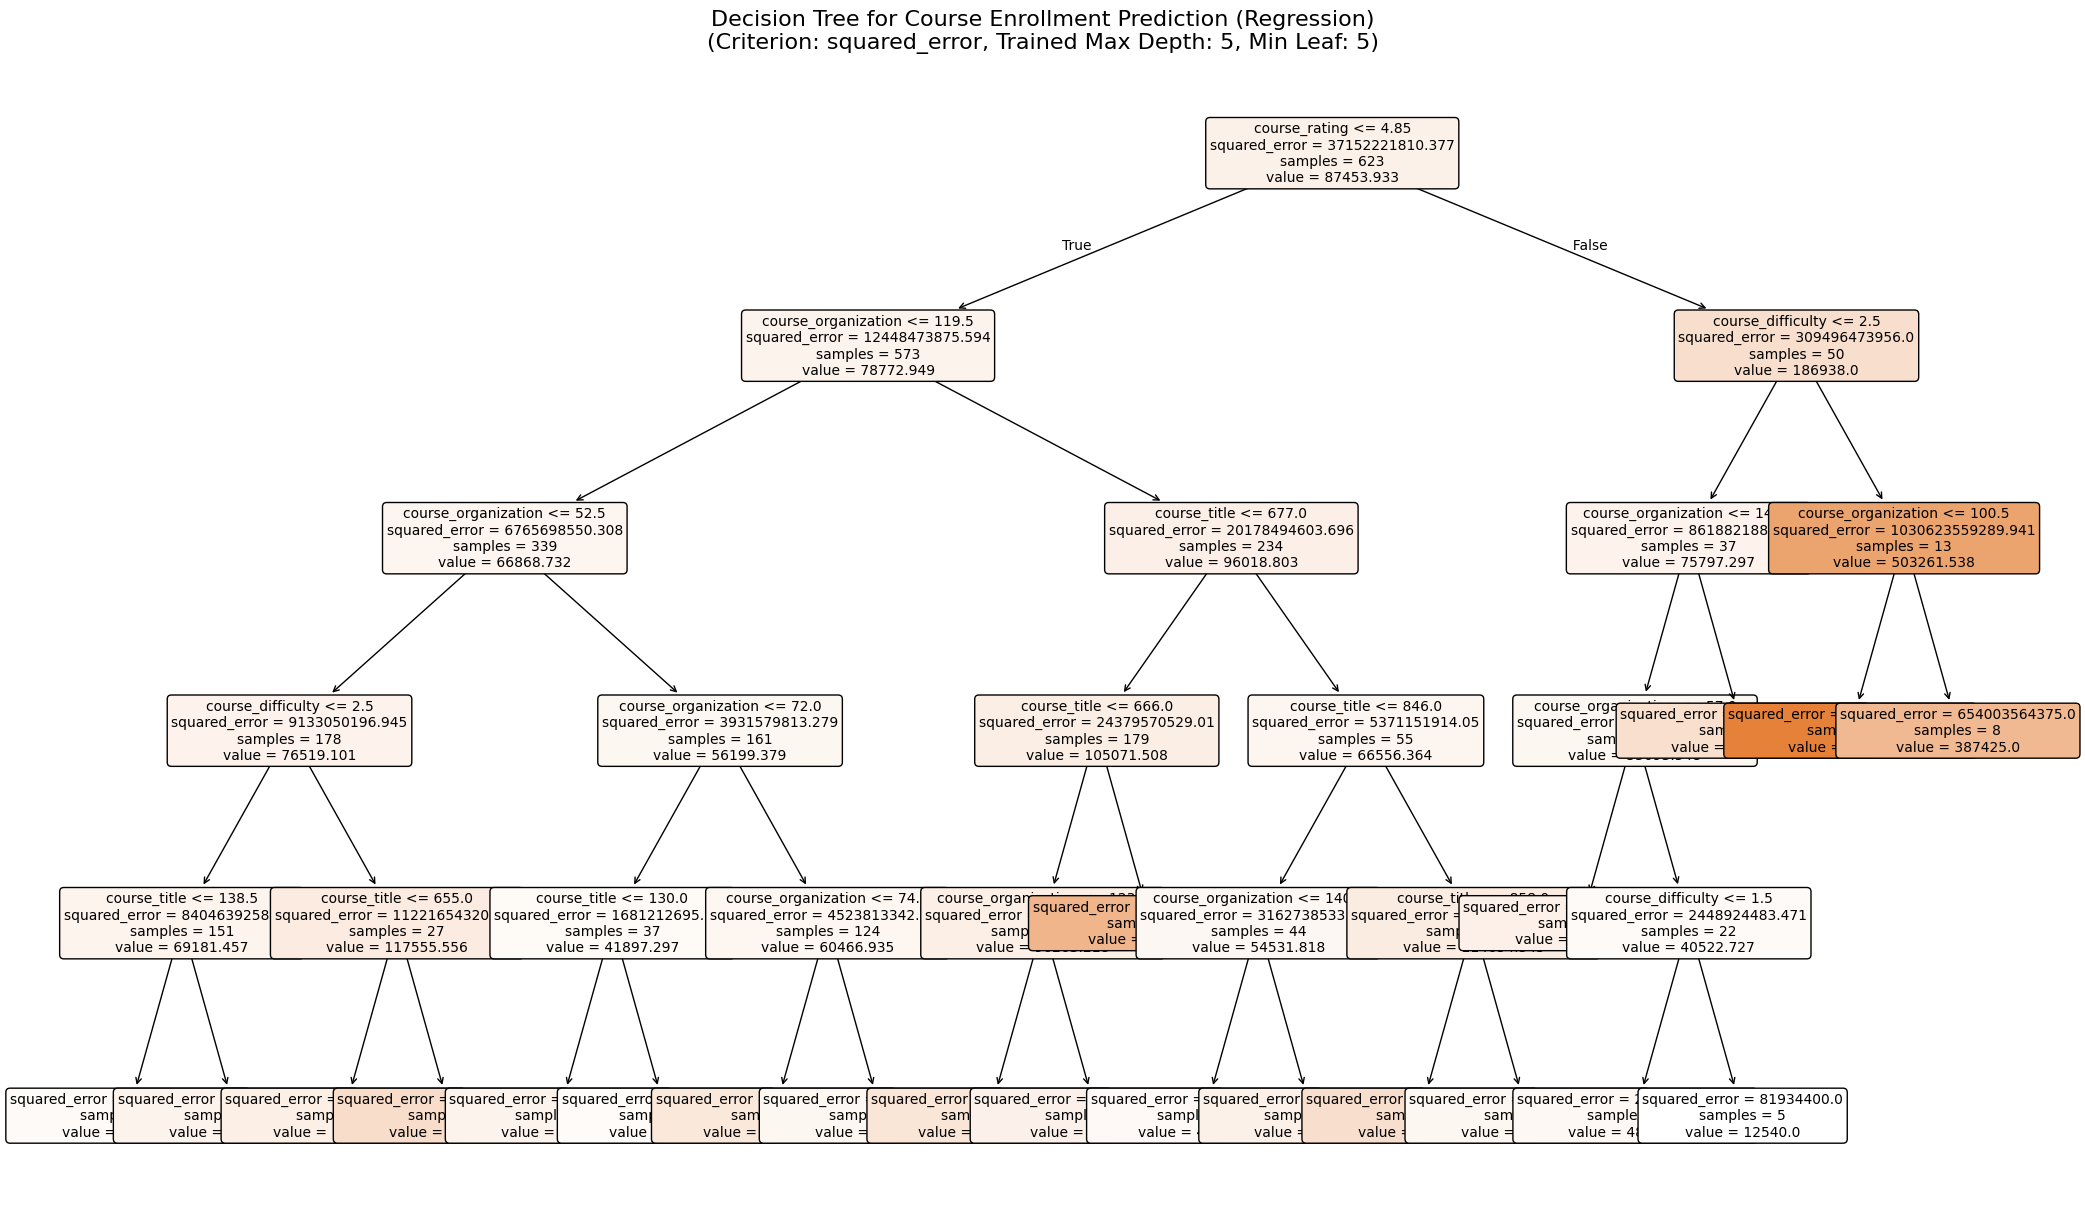


--- Script Finished ---


In [ ]:
#@title Decision Tree Regressor for Coursera Enrollment Prediction

# Step 1: Install necessary libraries (usually pre-installed in Colab)
# !pip install scikit-learn pandas matplotlib

# Step 2: Import libraries
import pandas as pd
from google.colab import files
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree # Changed to Regressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Regression metrics
import matplotlib.pyplot as plt
import math # For sqrt

print("--------------------------------------------------------")
print("Coursera Course Enrollment Decision Tree Regressor")
print("--------------------------------------------------------\n")

# Step 3: Upload the CSV file
print("Please upload the 'Copy of Coursera.csv' file:")
uploaded = files.upload()

if not uploaded:
    print("\nNo file uploaded. Exiting.")
else:
    # Get the filename (assuming only one file is uploaded)
    filename = list(uploaded.keys())[0]
    print(f"\nUploaded file '{filename}' successfully.")

    # Step 4: Load Data into pandas DataFrame
    try:
        print("\nLoading and processing data...")
        # Read the raw bytes, decode, find header, read CSV
        data_string = uploaded[filename].decode('utf-8')

        # Find the actual header line
        header_line_index = -1
        lines = data_string.splitlines()
        for i, line in enumerate(lines):
            if line.strip().startswith(',course_title,'):
                header_line_index = i
                break

        if header_line_index == -1:
             raise ValueError("Could not find the CSV header line starting with ',course_title,'. Please check the file format.")

        # Read the CSV using io.StringIO
        df = pd.read_csv(io.StringIO('\n'.join(lines[header_line_index:])), index_col=0)

        print("\nData loaded successfully. First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
        print("\nChecking for initial missing values:")
        print(df.isnull().sum())

    except Exception as e:
        print(f"\nError loading or parsing the CSV file: {e}")
        print("Please ensure the file is a valid CSV and matches the expected format.")
        df = None

    if df is not None:
        # Step 5: Target Variable Preprocessing (course_students_enrolled) - NUMERIC TARGET
        print("\n--- Preprocessing Target Variable (Numeric): course_students_enrolled ---")
        target_col_original = 'course_students_enrolled'
        target_col_numeric = 'enrollment_numeric' # This will be our y

        def parse_enrollment(enrollment_str):
            """Converts enrollment strings like '5.3k', '130k', '3.2m' to numbers."""
            if isinstance(enrollment_str, (int, float)):
                 return enrollment_str
            if not isinstance(enrollment_str, str):
                 return np.nan

            num_str = enrollment_str.lower().strip()
            if 'k' in num_str:
                return float(num_str.replace('k', '')) * 1000
            elif 'm' in num_str:
                return float(num_str.replace('m', '')) * 1000000
            else:
                try:
                    return float(num_str)
                except ValueError:
                    return np.nan

        # Apply the conversion function
        df[target_col_numeric] = df[target_col_original].apply(parse_enrollment)

        # Handle potential NaNs from conversion
        if df[target_col_numeric].isnull().any():
            print(f"\nWarning: Found {df[target_col_numeric].isnull().sum()} missing or unparseable values in '{target_col_original}'.")
            median_enrollment = df[target_col_numeric].median()
            print(f"Filling these missing values with the median enrollment: {median_enrollment:.0f}")
            df[target_col_numeric].fillna(median_enrollment, inplace=True)
        else:
            print(f"Successfully converted '{target_col_original}' to numeric.")

        print("\nNumeric enrollment summary (Target Variable):")
        print(df[target_col_numeric].describe())

        # --- NO BINNING for Regression Target ---

        # Step 6: Feature Preprocessing (Encoding Categorical Features) - Same as before
        print("\n--- Preprocessing Features ---")

        # Identify features
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = ['course_rating'] # Keep 'course_rating' as a numerical feature

        if target_col_original in categorical_cols:
            categorical_cols.remove(target_col_original) # Remove original string target

        print(f"Identified Categorical Features for Encoding: {categorical_cols}")
        print(f"Numerical Features to Keep: {numerical_cols}")

        # Apply Label Encoding
        encoders = {}
        df_encoded = df.copy()

        for col in categorical_cols:
            if df_encoded[col].isnull().any():
                print(f"Note: Filling {df_encoded[col].isnull().sum()} NaNs in '{col}' with 'Missing' before encoding.")
                df_encoded[col].fillna('Missing', inplace=True)

            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoders[col] = le
            print(f"Encoded '{col}'.")

        print("\nData after encoding (showing first 5 rows of relevant columns):")
        display_cols = numerical_cols + categorical_cols + [target_col_numeric]
        print(df_encoded[display_cols].head())

        # Step 7: Define Features (X) and Target (y) and Split Data
        print("\n--- Splitting Data ---")
        feature_cols = numerical_cols + categorical_cols
        X = df_encoded[feature_cols]
        y = df_encoded[target_col_numeric] # Use the numeric enrollment as target

        print(f"Using Features: {feature_cols}")
        print(f"Using Target (Numeric): {target_col_numeric}")

        # Split data (Stratification is not applicable for regression)
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )
            print(f"\nSplit data into {len(X_train)} training and {len(X_test)} testing samples.")
            print(f"Target variable range in training set: {y_train.min():.0f} - {y_train.max():.0f}")
            print(f"Target variable range in test set:     {y_test.min():.0f} - {y_test.max():.0f}")
        except Exception as e:
             print(f"\nError during train/test split: {e}")
             X_train, X_test, y_train, y_test = None, None, None, None

        if X_train is not None:
            # Step 8: Train the Decision Tree Regressor
            print("\n--- Training Decision Tree Regressor ---")
            # --- Hyperparameters ---
            tree_max_depth = 5      # Controls tree complexity
            min_samples_leaf = 5    # Minimum samples in a leaf node
            # Regressor criterion: 'squared_error' (MSE), 'friedman_mse', 'absolute_error' (MAE), 'poisson'
            criterion_reg = 'squared_error' # Default and common for regression
            # ---

            dt_regressor = DecisionTreeRegressor(
                criterion=criterion_reg,
                max_depth=tree_max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            dt_regressor.fit(X_train, y_train)
            print(f"Decision Tree Regressor trained with criterion='{criterion_reg}', max_depth={tree_max_depth}, min_samples_leaf={min_samples_leaf}.")

            # Step 9: Evaluate the Model using Regression Metrics
            print("\n--- Evaluating Model Performance (Regression Metrics) ---")
            y_pred_train = dt_regressor.predict(X_train)
            y_pred_test = dt_regressor.predict(X_test)

            # Calculate metrics for Test Set
            mae_test = mean_absolute_error(y_test, y_pred_test)
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = math.sqrt(mse_test)
            r2_test = r2_score(y_test, y_pred_test)

            # Calculate metrics for Train Set (to check for overfitting)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = math.sqrt(mse_train)
            r2_train = r2_score(y_train, y_pred_train)

            print("\nPerformance Metrics:")
            print(f"  Metric          | Train Set          | Test Set")
            print(f"------------------|--------------------|--------------------")
            print(f"  MAE             | {mae_train:18,.0f} | {mae_test:18,.0f}")
            print(f"  MSE             | {mse_train:18,.0f} | {mse_test:18,.0f}")
            print(f"  RMSE            | {rmse_train:18,.0f} | {rmse_test:18,.0f}")
            print(f"  R-squared (R²)  | {r2_train:18.4f} | {r2_test:18.4f}")

            print("\nInterpretation:")
            print(f"- MAE (Test): On average, the model's prediction is off by ~{mae_test:,.0f} students.")
            print(f"- R² (Test): The model explains ~{r2_test:.1%} of the variance in the test set enrollment numbers.")
            print("  (R²=1 is perfect, R²=0 means model is no better than predicting the average, R²<0 is worse)")


            # Optional: Scatter plot of Actual vs Predicted
            print("\n--- Visualizing Predictions vs Actual (Test Set) ---")
            plt.figure(figsize=(8, 8))
            plt.scatter(y_test, y_pred_test, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction (y=x)')
            plt.xlabel("Actual Enrollment")
            plt.ylabel("Predicted Enrollment")
            plt.title("Actual vs. Predicted Enrollment (Test Set)")
            plt.legend()
            # Consider log scale if range is very wide
            # plt.xscale('log')
            # plt.yscale('log')
            plt.grid(True)
            plt.show()


            # Step 10: Visualize the Decision Tree Regressor
            print("\n--- Visualizing Decision Tree Regressor ---")
            print("(Note: 'value' in each node now represents the predicted average enrollment for samples in that node)")
            try:
                plt.figure(figsize=(25, 15)) # Adjust figure size as needed
                plot_tree(
                    dt_regressor,
                    filled=True,
                    rounded=True,
                    feature_names=X.columns.tolist(),
                    fontsize=10,
                    # No class_names for regression
                    # Value in nodes is the predicted average target value for that node
                    # Criterion in nodes (e.g., squared_error) shows the impurity measure used
                )
                plt.title((f"Decision Tree for Course Enrollment Prediction (Regression)\n"
                          f"(Criterion: {criterion_reg}, Trained Max Depth: {dt_regressor.max_depth}, Min Leaf: {min_samples_leaf})"),
                          fontsize=16)
                plt.show()
            except Exception as e:
                print(f"\nError during tree visualization: {e}")
                print("The tree might be too large to plot effectively, or there might be an issue with plot settings.")

print("\n--- Script Finished ---")

Please upload your Coursera dataset CSV file.


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data.csv

Uploaded file: Copy of Coursera - CourseEra Data.csv

Dataset loaded successfully. First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_enrolled  

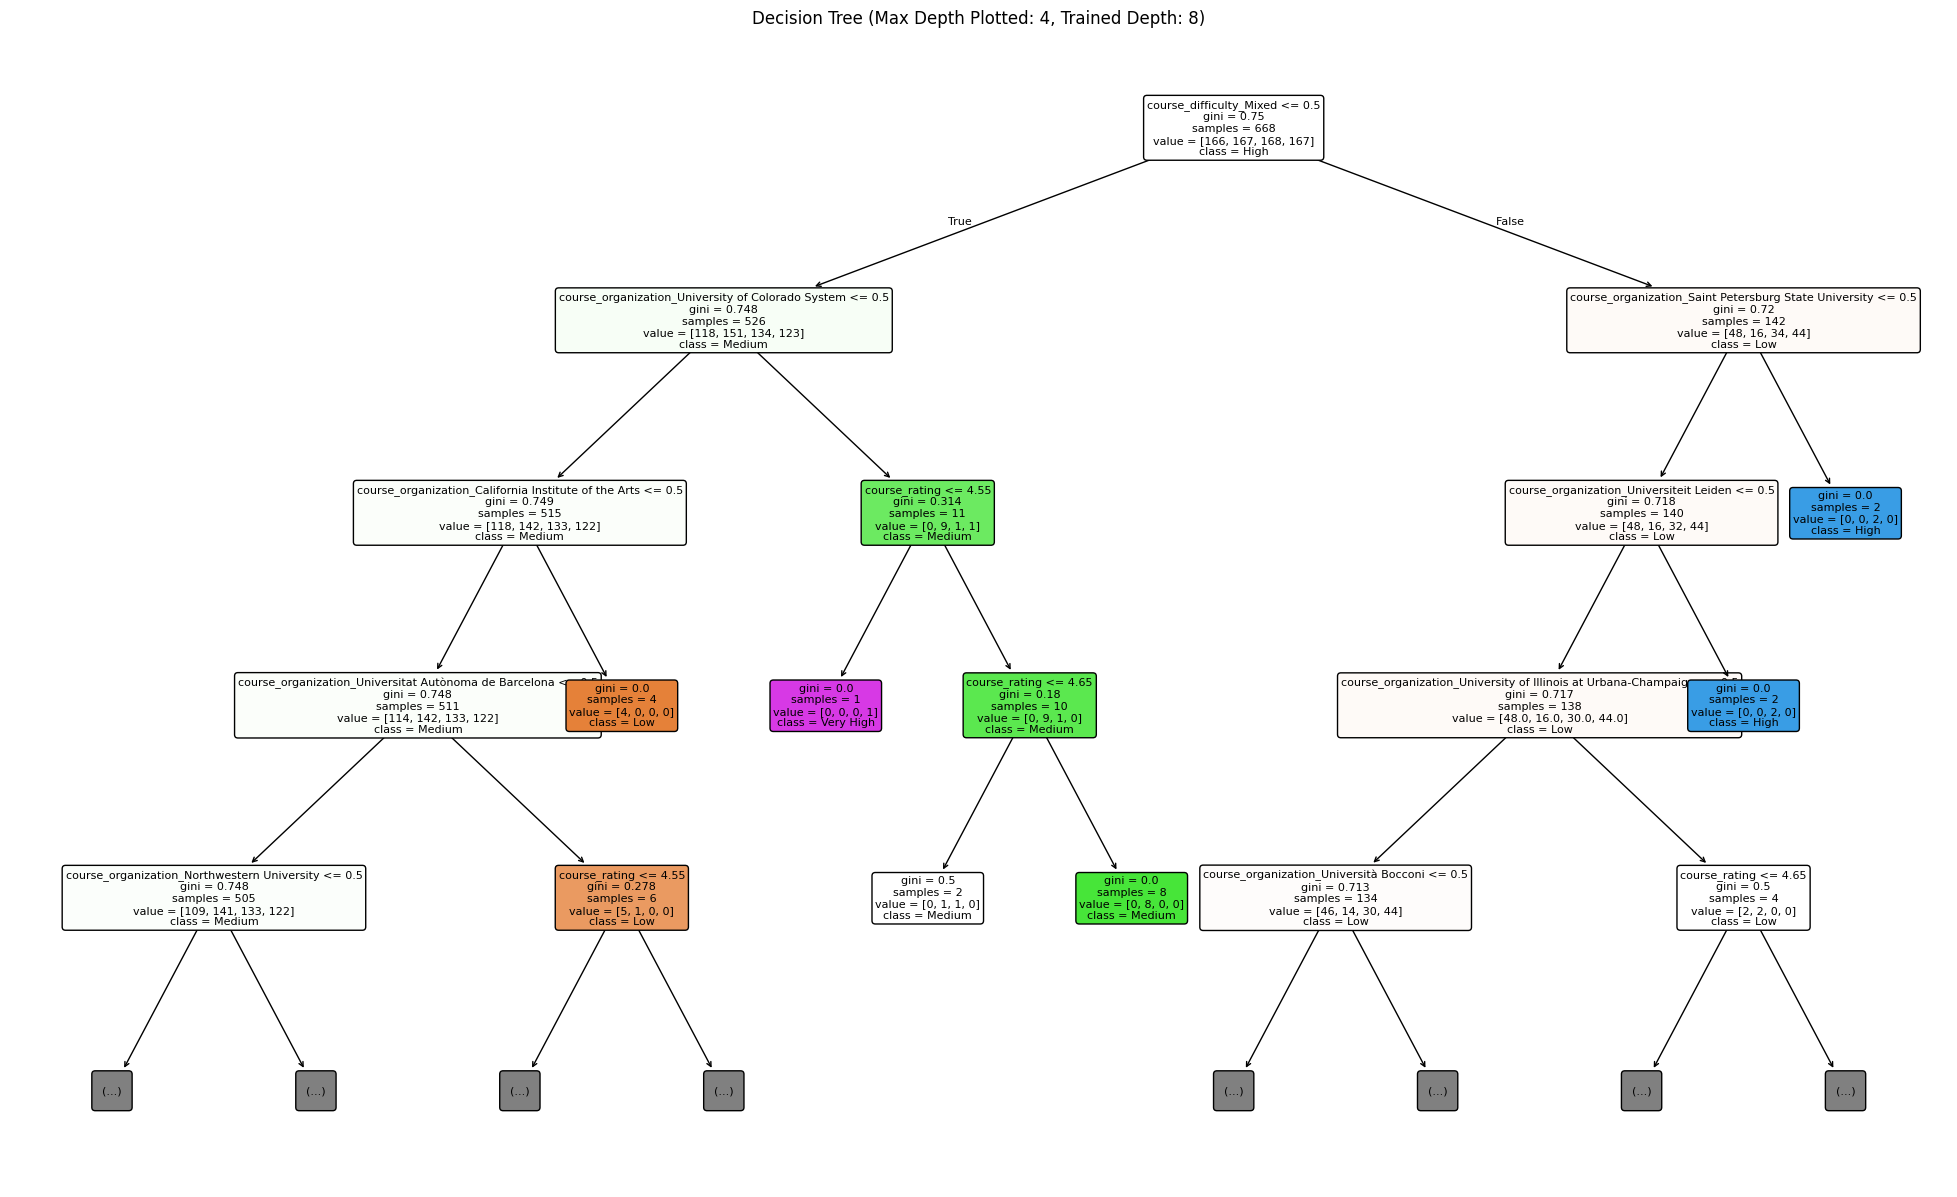

In [ ]:
import pandas as pd
import numpy as np
import io
import re # For parsing enrollment numbers
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("Please upload your Coursera dataset CSV file.")
uploaded = files.upload()

# Assuming the user uploads one file, get its name
file_name = list(uploaded.keys())[0]
print(f"\nUploaded file: {file_name}")

# --- 1. Load Data ---
try:
    # Read the uploaded CSV data directly from bytes
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print("\nDataset loaded successfully. First 5 rows:")
    print(df.head())
    print(f"\nDataset shape: {df.shape}")
    print("\nColumn Info:")
    df.info()

except Exception as e:
    print(f"\nError loading or reading the CSV file: {e}")
    # Stop execution if file loading fails
    exit()

# --- 2. Preprocess Target Variable ('course_students_enrolled') ---

# Function to convert 'k' and 'm' suffixes to numbers
def parse_enrollment(enrollment_str):
    if isinstance(enrollment_str, (int, float)):
        return float(enrollment_str) # Already numeric
    if pd.isna(enrollment_str):
        return np.nan

    enrollment_str = str(enrollment_str).lower().strip()
    num_part = re.findall(r"[\d\.]+", enrollment_str) # Find numbers (including decimals)

    if not num_part:
        return np.nan # Cannot parse

    num = float(num_part[0])

    if 'k' in enrollment_str:
        return num * 1000
    elif 'm' in enrollment_str:
        return num * 1000000
    else:
        # Assume it's just a number if no suffix (handle potential errors)
        try:
            return float(enrollment_str)
        except ValueError:
            return np.nan # If it wasn't just a number

# Apply the parsing function
target_col = 'course_students_enrolled'
df['enrollment_numeric'] = df[target_col].apply(parse_enrollment)

# Handle potential NaN values created during parsing or already existing
df.dropna(subset=['enrollment_numeric'], inplace=True) # Drop rows where enrollment couldn't be parsed
print(f"\nShape after dropping rows with unparseable enrollment: {df.shape}")


# Bin the numeric enrollment into categories for classification
# Using quantiles (e.g., 4 bins: Low, Medium, High, Very High)
try:
    # Define labels for the bins
    bin_labels = ['Low', 'Medium', 'High', 'Very High']
    df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=4, labels=bin_labels, duplicates='drop')
    print("\nEnrollment counts per category:")
    print(df['enrollment_category'].value_counts())
    y = df['enrollment_category'] # Our target variable for classification
except ValueError as e:
     print(f"\nError binning enrollment (maybe too few unique values or issues with quantiles): {e}")
     # Alternative: Use fewer bins or manually define thresholds if qcut fails
     try:
        bin_labels_alt = ['Low', 'Medium', 'High']
        df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=3, labels=bin_labels_alt, duplicates='drop')
        print("\nUsing 3 bins instead due to previous error. Enrollment counts per category:")
        print(df['enrollment_category'].value_counts())
        y = df['enrollment_category']
     except Exception as e2:
        print(f"Could not bin enrollment even with fewer bins. Error: {e2}")
        print("Cannot proceed with classification without a valid target variable.")
        exit()


# --- 3. Define Features (X) and Preprocess ---

# Drop original target, numeric target, and high-cardinality title
X = df.drop(columns=[target_col, 'enrollment_numeric', 'enrollment_category', 'course_title'])

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features identified: {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")

# Create preprocessing pipelines for numerical and categorical features
# For Decision Trees, scaling numerical features isn't strictly necessary, but doesn't hurt.
# OneHotEncoder is essential for categorical features. 'handle_unknown='ignore'' prevents errors if test set has categories not seen in train set.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Or use StandardScaler() if scaling is desired
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop' # Drop any columns not explicitly handled
)


# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Stratify helps maintain class proportion

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

# --- 5. Create and Train the Decision Tree Model ---

# Create the full pipeline including preprocessing and the classifier
# Limiting max_depth can help prevent overfitting and make the tree visualizable
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42, max_depth=8))]) # Adjust max_depth as needed

# Train the model
print("\nTraining the Decision Tree model...")
dt_pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred = dt_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0)) # Add zero_division=0 to handle cases with no predicted samples for a class

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# --- 7. Visualize the Tree (Optional) ---
print("\nGenerating Decision Tree visualization (might take a moment)...")

try:
    # Get the actual classifier step from the pipeline
    tree_model = dt_pipeline.named_steps['classifier']

    # Get the feature names *after* OneHotEncoding from the preprocessor step
    # Access the fitted ColumnTransformer to get the transformed feature names
    feature_names_transformed = list(numerical_features) # Start with numerical (if passthrough)

    # Add names from OneHotEncoder
    onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1] # Access the OneHotEncoder
    onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
    feature_names_transformed.extend(onehot_features)

    plt.figure(figsize=(25, 15)) # Adjust size as needed
    plot_tree(tree_model,
              filled=True,
              rounded=True,
              class_names=list(y.cat.categories), # Use category names from the target
              feature_names=feature_names_transformed,
              max_depth=4, # Limit plot depth for readability, doesn't affect the trained model
              fontsize=8) # Adjust fontsize
    plt.title(f"Decision Tree (Max Depth Plotted: 4, Trained Depth: {tree_model.get_depth()})")
    plt.show()
except Exception as e:
    print(f"\nCould not plot the tree. Error: {e}")
    print("Tree might be too large to visualize easily, or there might be an issue with feature names.")

Please upload your Coursera dataset CSV file.


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data (1).csv

Uploaded file: Copy of Coursera - CourseEra Data (1).csv

Dataset loaded successfully. First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_en

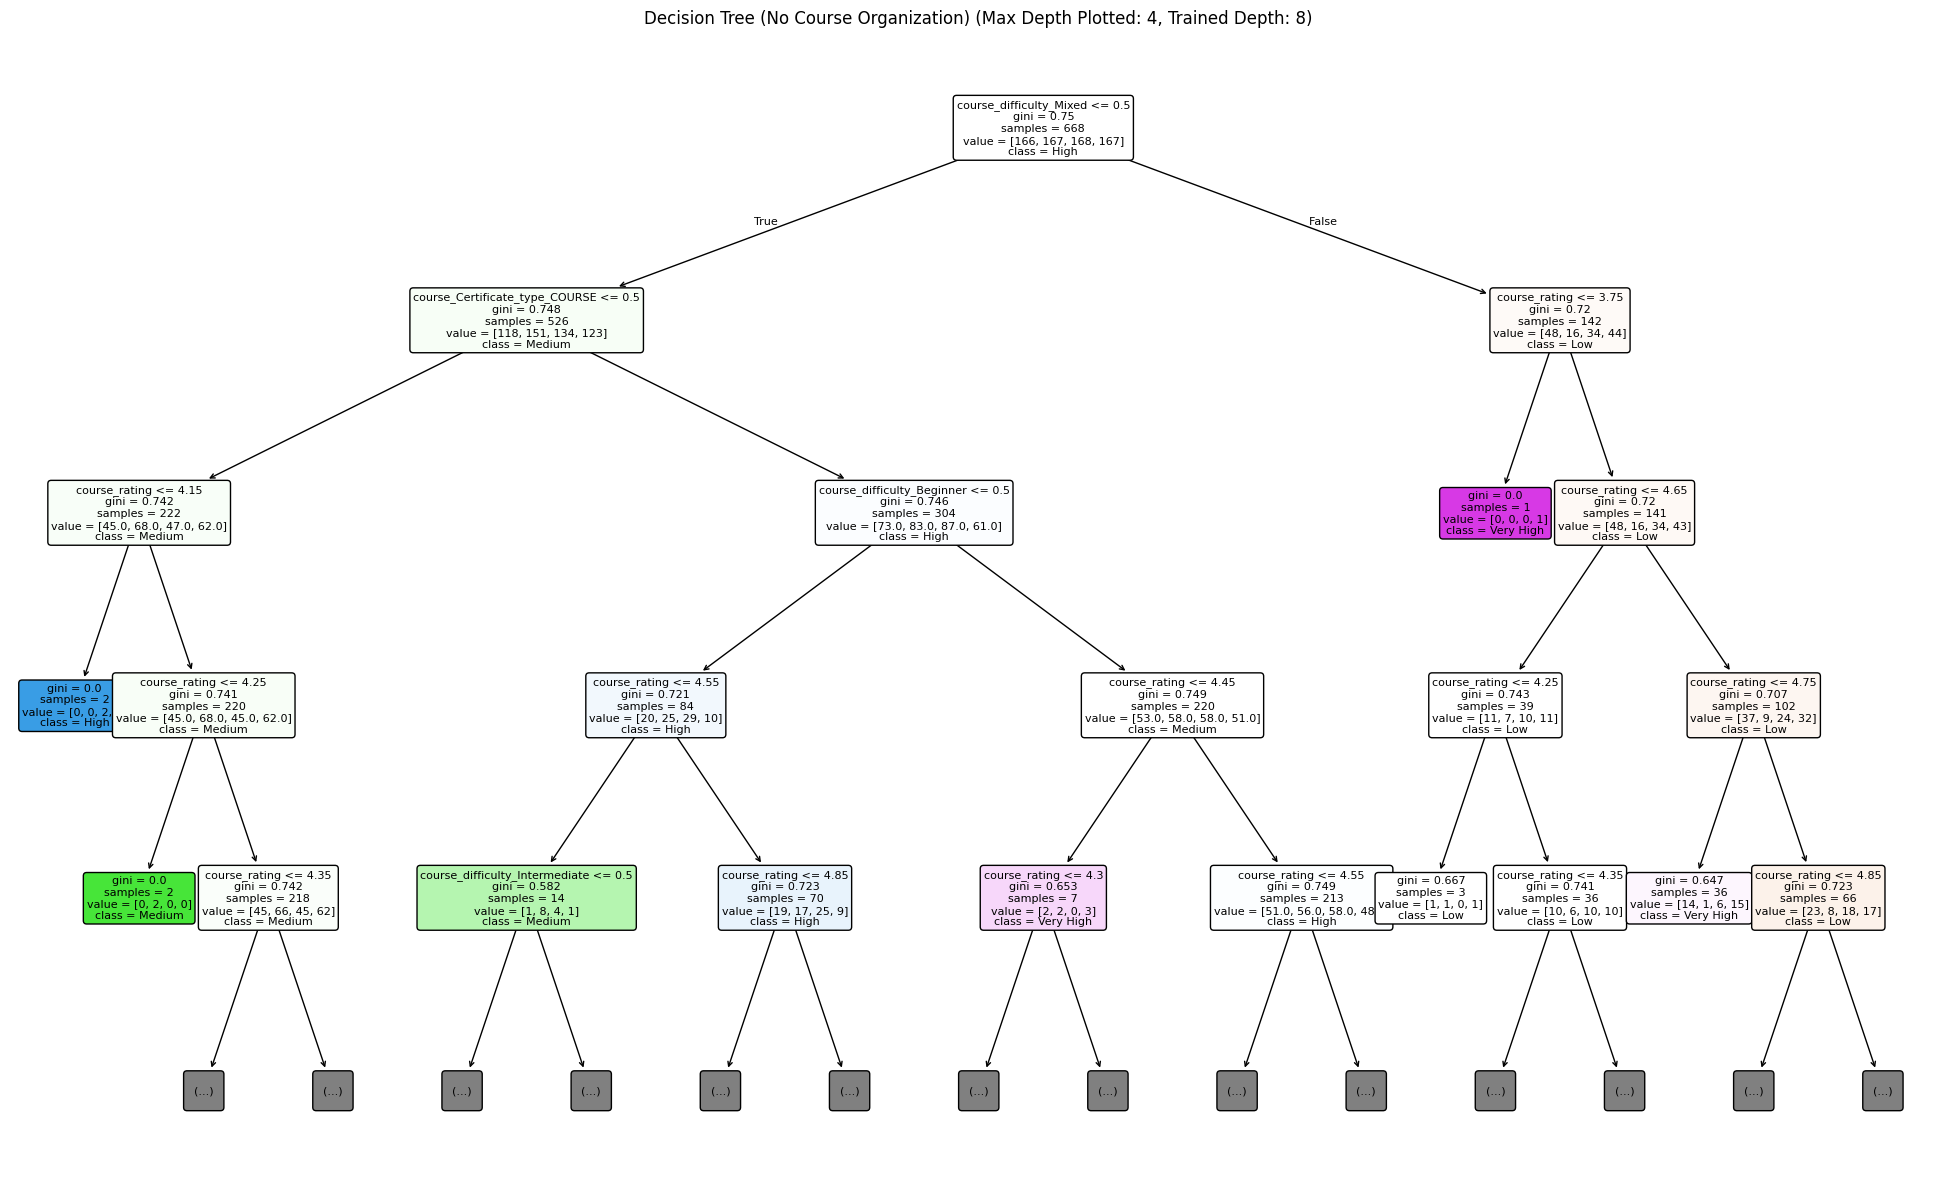

In [ ]:
import pandas as pd
import numpy as np
import io
import re # For parsing enrollment numbers
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder # Keep for other categorical features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("Please upload your Coursera dataset CSV file.")
uploaded = files.upload()

# Assuming the user uploads one file, get its name
file_name = list(uploaded.keys())[0]
print(f"\nUploaded file: {file_name}")

# --- 1. Load Data ---
try:
    # Read the uploaded CSV data directly from bytes
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print("\nDataset loaded successfully. First 5 rows:")
    print(df.head())
    print(f"\nDataset shape: {df.shape}")
    print("\nColumn Info:")
    df.info()

except Exception as e:
    print(f"\nError loading or reading the CSV file: {e}")
    # Stop execution if file loading fails
    exit()

# --- 2. Preprocess Target Variable ('course_students_enrolled') ---

# Function to convert 'k' and 'm' suffixes to numbers
def parse_enrollment(enrollment_str):
    if isinstance(enrollment_str, (int, float)):
        return float(enrollment_str) # Already numeric
    if pd.isna(enrollment_str):
        return np.nan

    enrollment_str = str(enrollment_str).lower().strip()
    num_part = re.findall(r"[\d\.]+", enrollment_str) # Find numbers (including decimals)

    if not num_part:
        return np.nan # Cannot parse

    num = float(num_part[0])

    if 'k' in enrollment_str:
        return num * 1000
    elif 'm' in enrollment_str:
        return num * 1000000
    else:
        # Assume it's just a number if no suffix (handle potential errors)
        try:
            return float(enrollment_str)
        except ValueError:
            return np.nan # If it wasn't just a number

# Apply the parsing function
target_col = 'course_students_enrolled'
df['enrollment_numeric'] = df[target_col].apply(parse_enrollment)

# Handle potential NaN values created during parsing or already existing
df.dropna(subset=['enrollment_numeric'], inplace=True) # Drop rows where enrollment couldn't be parsed
print(f"\nShape after dropping rows with unparseable enrollment: {df.shape}")


# Bin the numeric enrollment into categories for classification
try:
    bin_labels = ['Low', 'Medium', 'High', 'Very High']
    df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=4, labels=bin_labels, duplicates='drop')
    print("\nEnrollment counts per category:")
    print(df['enrollment_category'].value_counts())
    y = df['enrollment_category'] # Our target variable for classification
except ValueError as e:
     print(f"\nError binning enrollment (maybe too few unique values or issues with quantiles): {e}")
     try:
        bin_labels_alt = ['Low', 'Medium', 'High']
        df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=3, labels=bin_labels_alt, duplicates='drop')
        print("\nUsing 3 bins instead due to previous error. Enrollment counts per category:")
        print(df['enrollment_category'].value_counts())
        y = df['enrollment_category']
     except Exception as e2:
        print(f"Could not bin enrollment even with fewer bins. Error: {e2}")
        print("Cannot proceed with classification without a valid target variable.")
        exit()


# --- 3. Define Features (X) and Preprocess ---

# Drop original target, numeric target, title, AND 'course_organization'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# MODIFICATION HERE: Added 'course_organization' to the drop list
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X = df.drop(columns=[target_col, 'enrollment_numeric', 'enrollment_category', 'course_title', 'course_organization'])
print("\nFeatures (X) after dropping target, helper columns, title, and organization:")
print(X.head())


# Identify remaining categorical and numerical features
# 'course_organization' will no longer be in this list
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features identified (excluding organization): {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")

# Create preprocessing pipelines for numerical and remaining categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        # OneHotEncoder will now only apply to remaining categorical features (e.g., certificate type, difficulty)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)


# --- 4. Split Data ---
# Stratification might be less effective if classes become very unbalanced after removing a key feature, but still good practice.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

# --- 5. Create and Train the Decision Tree Model ---

# The pipeline remains the same structure, but the preprocessor step will handle fewer features
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              # Using a slightly deeper tree potentially, as organization is removed
                              ('classifier', DecisionTreeClassifier(random_state=42, max_depth=8))]) # Adjust max_depth if needed

# Train the model
print("\nTraining the Decision Tree model (without course_organization)...")
dt_pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred = dt_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}") # Expect accuracy to likely decrease

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# --- 7. Visualize the Tree (Optional) ---
print("\nGenerating Decision Tree visualization (without course_organization)...")

try:
    tree_model = dt_pipeline.named_steps['classifier']

    # Get the feature names *after* OneHotEncoding (excluding organization)
    feature_names_transformed = list(numerical_features)
    if categorical_features.any(): # Check if there are any categorical features left
      onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
      onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
      feature_names_transformed.extend(onehot_features)

    plt.figure(figsize=(25, 15))
    plot_tree(tree_model,
              filled=True,
              rounded=True,
              class_names=list(y.cat.categories),
              feature_names=feature_names_transformed, # Will not contain organization features
              max_depth=4, # Keep plot depth manageable
              fontsize=8)
    plt.title(f"Decision Tree (No Course Organization) (Max Depth Plotted: 4, Trained Depth: {tree_model.get_depth()})")
    plt.show()
except Exception as e:
    print(f"\nCould not plot the tree. Error: {e}")

Please upload your Coursera dataset CSV file.


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data.csv

Uploaded file: Copy of Coursera - CourseEra Data.csv

Dataset loaded successfully. First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_enrolled  

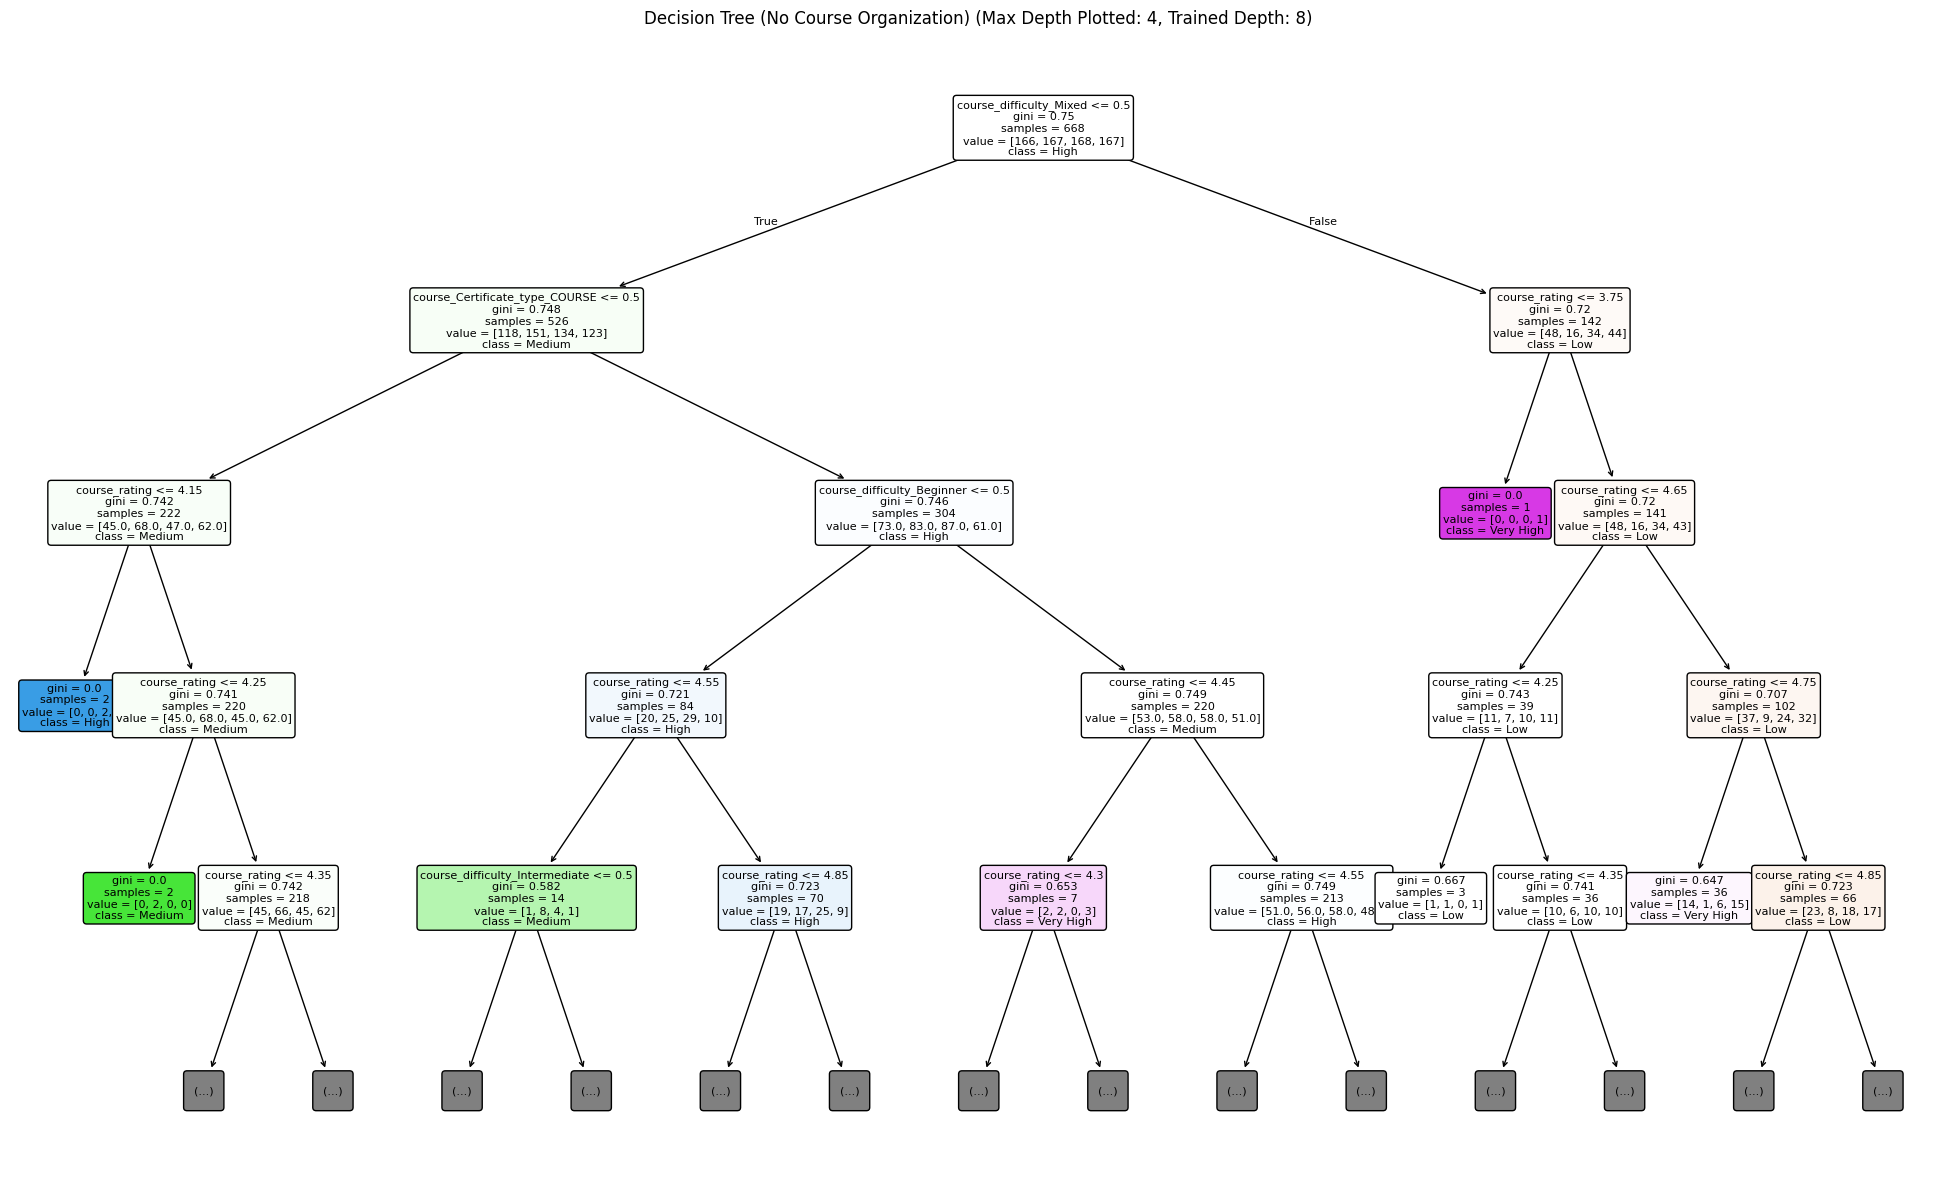

In [ ]:
import pandas as pd
import numpy as np
import io
import re # For parsing enrollment numbers
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder # Keep for other categorical features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("Please upload your Coursera dataset CSV file.")
uploaded = files.upload()

# Assuming the user uploads one file, get its name
file_name = list(uploaded.keys())[0]
print(f"\nUploaded file: {file_name}")

# --- 1. Load Data ---
try:
    # Read the uploaded CSV data directly from bytes
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print("\nDataset loaded successfully. First 5 rows:")
    print(df.head())
    print(f"\nDataset shape: {df.shape}")
    print("\nColumn Info:")
    df.info()

except Exception as e:
    print(f"\nError loading or reading the CSV file: {e}")
    # Stop execution if file loading fails
    exit()

# --- 2. Preprocess Target Variable ('course_students_enrolled') ---

# Function to convert 'k' and 'm' suffixes to numbers
def parse_enrollment(enrollment_str):
    if isinstance(enrollment_str, (int, float)):
        return float(enrollment_str) # Already numeric
    if pd.isna(enrollment_str):
        return np.nan

    enrollment_str = str(enrollment_str).lower().strip()
    num_part = re.findall(r"[\d\.]+", enrollment_str) # Find numbers (including decimals)

    if not num_part:
        return np.nan # Cannot parse

    num = float(num_part[0])

    if 'k' in enrollment_str:
        return num * 1000
    elif 'm' in enrollment_str:
        return num * 1000000
    else:
        # Assume it's just a number if no suffix (handle potential errors)
        try:
            return float(enrollment_str)
        except ValueError:
            return np.nan # If it wasn't just a number

# Apply the parsing function
target_col = 'course_students_enrolled'
df['enrollment_numeric'] = df[target_col].apply(parse_enrollment)

# Handle potential NaN values created during parsing or already existing
df.dropna(subset=['enrollment_numeric'], inplace=True) # Drop rows where enrollment couldn't be parsed
print(f"\nShape after dropping rows with unparseable enrollment: {df.shape}")


# Bin the numeric enrollment into categories for classification
try:
    bin_labels = ['Low', 'Medium', 'High', 'Very High']
    df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=4, labels=bin_labels, duplicates='drop')
    print("\nEnrollment counts per category:")
    print(df['enrollment_category'].value_counts())
    y = df['enrollment_category'] # Our target variable for classification
except ValueError as e:
     print(f"\nError binning enrollment (maybe too few unique values or issues with quantiles): {e}")
     try:
        bin_labels_alt = ['Low', 'Medium', 'High']
        df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=3, labels=bin_labels_alt, duplicates='drop')
        print("\nUsing 3 bins instead due to previous error. Enrollment counts per category:")
        print(df['enrollment_category'].value_counts())
        y = df['enrollment_category']
     except Exception as e2:
        print(f"Could not bin enrollment even with fewer bins. Error: {e2}")
        print("Cannot proceed with classification without a valid target variable.")
        exit()


# --- 3. Define Features (X) and Preprocess ---

# Drop original target, numeric target, title, AND 'course_organization'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# MODIFICATION HERE: Added 'course_organization' to the drop list
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X = df.drop(columns=[target_col, 'enrollment_numeric', 'enrollment_category', 'course_title', 'course_organization'])
print("\nFeatures (X) after dropping target, helper columns, title, and organization:")
print(X.head())


# Identify remaining categorical and numerical features
# 'course_organization' will no longer be in this list
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features identified (excluding organization): {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")

# Create preprocessing pipelines for numerical and remaining categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        # OneHotEncoder will now only apply to remaining categorical features (e.g., certificate type, difficulty)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)


# --- 4. Split Data ---
# Stratification might be less effective if classes become very unbalanced after removing a key feature, but still good practice.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

# --- 5. Create and Train the Decision Tree Model ---

# The pipeline remains the same structure, but the preprocessor step will handle fewer features
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              # Using a slightly deeper tree potentially, as organization is removed
                              ('classifier', DecisionTreeClassifier(random_state=42, max_depth=8))]) # Adjust max_depth if needed

# Train the model
print("\nTraining the Decision Tree model (without course_organization)...")
dt_pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred = dt_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}") # Expect accuracy to likely decrease

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# --- ADD THIS CODE AFTER MODEL EVALUATION (STEP 6) ---

print("\n--- Decision Tree Paths (Text Rules) ---")

# Get the trained tree object and components
tree_model = dt_pipeline.named_steps['classifier']
tree_ = tree_model.tree_

# Get feature names AFTER transformation
feature_names_transformed = list(numerical_features) # Start with numerical (if passthrough)
if categorical_features.any(): # Check if there are any categorical features left
    try:
        onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
        onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
        feature_names_transformed.extend(onehot_features)
    except IndexError: # Handle case where there were no categorical features
         print("No categorical features found for one-hot encoding names.")


# Get class names
class_names = list(y.cat.categories) # Or use tree_model.classes_

# --- Recursive function to print paths ---
def print_tree_paths(node_id, current_path):
    # Check if it's a leaf node
    if tree_.children_left[node_id] == tree_.children_right[node_id]:
        # Leaf node: print the path and the prediction
        prediction_values = tree_.value[node_id][0] # Get class counts
        predicted_class_index = prediction_values.argmax()
        predicted_class = class_names[predicted_class_index]
        path_str = " -> ".join(current_path)
        print(f"Path: {path_str} => Predict: {predicted_class} (Counts: {prediction_values.astype(int)})")
        return

    # Internal node: get split details
    feature_index = tree_.feature[node_id]
    threshold = tree_.threshold[node_id]
    feature_name = feature_names_transformed[feature_index]

    # --- Interpret the rule based on feature type ---
    # Check if it looks like a one-hot encoded feature
    is_one_hot_encoded = any(f"{cat}_" in feature_name for cat in categorical_features) and '_' in feature_name

    # Left branch rule (<= threshold)
    if is_one_hot_encoded:
         # For OHE, <= 0.5 means the category is NOT present
        rule_left = f"{feature_name} <= {threshold:.2f} (Category NOT Present)"
    else:
        # For numerical features
        rule_left = f"{feature_name} <= {threshold:.2f}"

    # Recurse down the left branch (True condition)
    print_tree_paths(tree_.children_left[node_id], current_path + [rule_left])

    # Right branch rule (> threshold)
    if is_one_hot_encoded:
        # For OHE, > 0.5 means the category IS present
         rule_right = f"{feature_name} > {threshold:.2f} (Category IS Present)"
    else:
        # For numerical features
        rule_right = f"{feature_name} > {threshold:.2f}"

    # Recurse down the right branch (False condition)
    print_tree_paths(tree_.children_right[node_id], current_path + [rule_right])

# Start the process from the root node (node 0)
try:
    print_tree_paths(0, [])
except Exception as e:
    print(f"\nError generating text paths: {e}")
    print("Ensure feature names and class names were correctly retrieved.")

# --- CONTINUE WITH STEP 7 (VISUALIZATION) IF DESIRED ---
# ... (rest of your visualization code) ...
# --- 7. Visualize the Tree (Optional) ---
print("\nGenerating Decision Tree visualization (without course_organization)...")

try:
    tree_model = dt_pipeline.named_steps['classifier']

    # Get the feature names *after* OneHotEncoding (excluding organization)
    feature_names_transformed = list(numerical_features)
    if categorical_features.any(): # Check if there are any categorical features left
      onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
      onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
      feature_names_transformed.extend(onehot_features)

    plt.figure(figsize=(25, 15))
    plot_tree(tree_model,
              filled=True,
              rounded=True,
              class_names=list(y.cat.categories),
              feature_names=feature_names_transformed, # Will not contain organization features
              max_depth=4, # Keep plot depth manageable
              fontsize=8)
    plt.title(f"Decision Tree (No Course Organization) (Max Depth Plotted: 4, Trained Depth: {tree_model.get_depth()})")
    plt.show()
except Exception as e:
    print(f"\nCould not plot the tree. Error: {e}")

Please upload your Coursera dataset CSV file.


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data (1).csv

Uploaded file: Copy of Coursera - CourseEra Data (1).csv

Dataset loaded successfully. First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_difficulty course_students_en

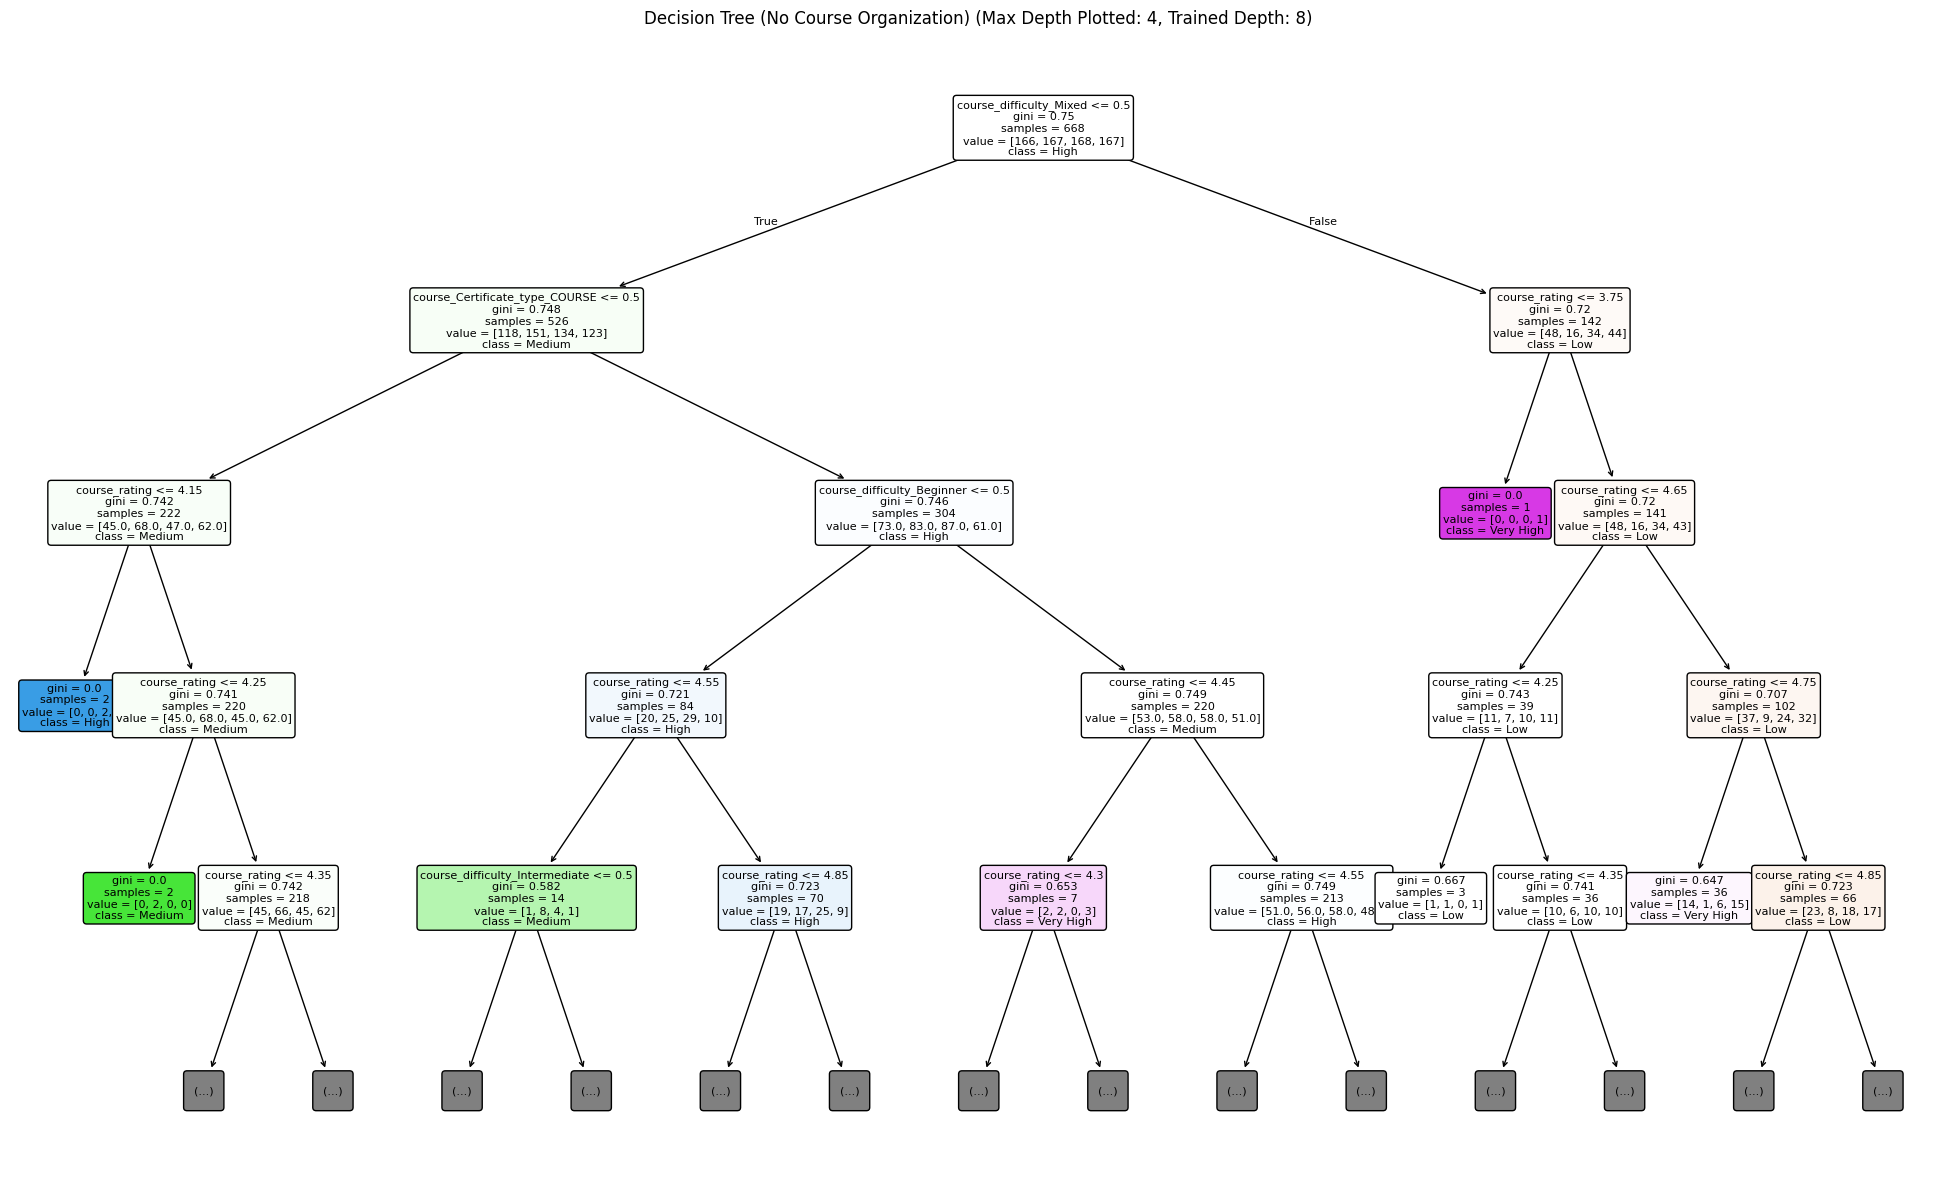


Generating Simplified Decision Tree visualization...
Displaying plot...


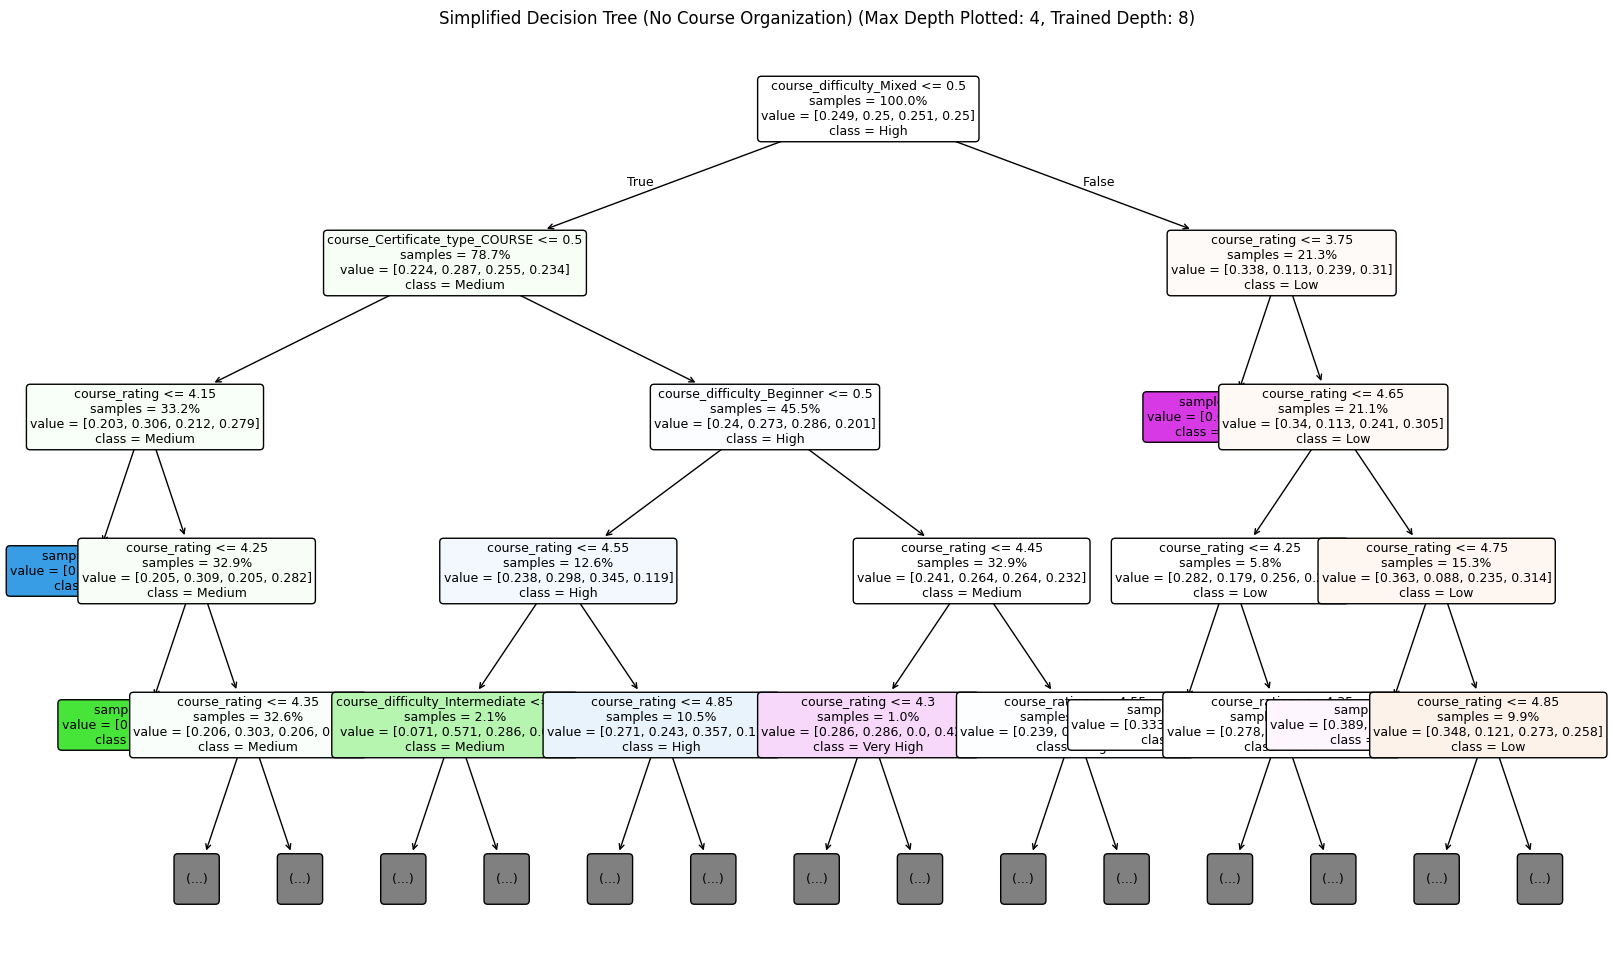


Note: This simplified plot hides impurity and uses proportions.
Scikit-learn's plot_tree doesn't natively support showing *only* the class name in leaves.


In [ ]:
# --- Assumes you have already run the previous code blocks for: ---
# 1. Imports (pandas, sklearn, matplotlib, etc.)
# 2. File Upload and Data Loading (df)
# 3. Target Variable Preprocessing (y created)
# 4. Feature Selection (X created, excluding organization)
# 5. Preprocessing Setup (ColumnTransformer - preprocessor)
# 6. Train-Test Split
# 7. Pipeline Creation and Training (dt_pipeline.fit(X_train, y_train))
# ----------------------------------------------------------------
import pandas as pd
import numpy as np
import io
import re # For parsing enrollment numbers
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder # Keep for other categorical features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("Please upload your Coursera dataset CSV file.")
uploaded = files.upload()

# Assuming the user uploads one file, get its name
file_name = list(uploaded.keys())[0]
print(f"\nUploaded file: {file_name}")

# --- 1. Load Data ---
try:
    # Read the uploaded CSV data directly from bytes
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print("\nDataset loaded successfully. First 5 rows:")
    print(df.head())
    print(f"\nDataset shape: {df.shape}")
    print("\nColumn Info:")
    df.info()

except Exception as e:
    print(f"\nError loading or reading the CSV file: {e}")
    # Stop execution if file loading fails
    exit()

# --- 2. Preprocess Target Variable ('course_students_enrolled') ---

# Function to convert 'k' and 'm' suffixes to numbers
def parse_enrollment(enrollment_str):
    if isinstance(enrollment_str, (int, float)):
        return float(enrollment_str) # Already numeric
    if pd.isna(enrollment_str):
        return np.nan

    enrollment_str = str(enrollment_str).lower().strip()
    num_part = re.findall(r"[\d\.]+", enrollment_str) # Find numbers (including decimals)

    if not num_part:
        return np.nan # Cannot parse

    num = float(num_part[0])

    if 'k' in enrollment_str:
        return num * 1000
    elif 'm' in enrollment_str:
        return num * 1000000
    else:
        # Assume it's just a number if no suffix (handle potential errors)
        try:
            return float(enrollment_str)
        except ValueError:
            return np.nan # If it wasn't just a number

# Apply the parsing function
target_col = 'course_students_enrolled'
df['enrollment_numeric'] = df[target_col].apply(parse_enrollment)

# Handle potential NaN values created during parsing or already existing
df.dropna(subset=['enrollment_numeric'], inplace=True) # Drop rows where enrollment couldn't be parsed
print(f"\nShape after dropping rows with unparseable enrollment: {df.shape}")


# Bin the numeric enrollment into categories for classification
try:
    bin_labels = ['Low', 'Medium', 'High', 'Very High']
    df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=4, labels=bin_labels, duplicates='drop')
    print("\nEnrollment counts per category:")
    print(df['enrollment_category'].value_counts())
    y = df['enrollment_category'] # Our target variable for classification
except ValueError as e:
     print(f"\nError binning enrollment (maybe too few unique values or issues with quantiles): {e}")
     try:
        bin_labels_alt = ['Low', 'Medium', 'High']
        df['enrollment_category'] = pd.qcut(df['enrollment_numeric'], q=3, labels=bin_labels_alt, duplicates='drop')
        print("\nUsing 3 bins instead due to previous error. Enrollment counts per category:")
        print(df['enrollment_category'].value_counts())
        y = df['enrollment_category']
     except Exception as e2:
        print(f"Could not bin enrollment even with fewer bins. Error: {e2}")
        print("Cannot proceed with classification without a valid target variable.")
        exit()


# --- 3. Define Features (X) and Preprocess ---

# Drop original target, numeric target, title, AND 'course_organization'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# MODIFICATION HERE: Added 'course_organization' to the drop list
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X = df.drop(columns=[target_col, 'enrollment_numeric', 'enrollment_category', 'course_title', 'course_organization'])
print("\nFeatures (X) after dropping target, helper columns, title, and organization:")
print(X.head())


# Identify remaining categorical and numerical features
# 'course_organization' will no longer be in this list
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features identified (excluding organization): {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")

# Create preprocessing pipelines for numerical and remaining categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        # OneHotEncoder will now only apply to remaining categorical features (e.g., certificate type, difficulty)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)


# --- 4. Split Data ---
# Stratification might be less effective if classes become very unbalanced after removing a key feature, but still good practice.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

# --- 5. Create and Train the Decision Tree Model ---

# The pipeline remains the same structure, but the preprocessor step will handle fewer features
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              # Using a slightly deeper tree potentially, as organization is removed
                              ('classifier', DecisionTreeClassifier(random_state=42, max_depth=8))]) # Adjust max_depth if needed

# Train the model
print("\nTraining the Decision Tree model (without course_organization)...")
dt_pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Evaluate the Model ---
print("\nEvaluating the model on the test set...")
y_pred = dt_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}") # Expect accuracy to likely decrease

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# --- 7. Visualize the Tree (Optional) ---
print("\nGenerating Decision Tree visualization (without course_organization)...")

try:
    tree_model = dt_pipeline.named_steps['classifier']

    # Get the feature names *after* OneHotEncoding (excluding organization)
    feature_names_transformed = list(numerical_features)
    if categorical_features.any(): # Check if there are any categorical features left
      onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
      onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
      feature_names_transformed.extend(onehot_features)

    plt.figure(figsize=(25, 15))
    plot_tree(tree_model,
              filled=True,
              rounded=True,
              class_names=list(y.cat.categories),
              feature_names=feature_names_transformed, # Will not contain organization features
              max_depth=4, # Keep plot depth manageable
              fontsize=8)
    plt.title(f"Decision Tree (No Course Organization) (Max Depth Plotted: 4, Trained Depth: {tree_model.get_depth()})")
    plt.show()
except Exception as e:
    print(f"\nCould not plot the tree. Error: {e}")
print("\nGenerating Simplified Decision Tree visualization...")

try:
    # Get the trained classifier and components
    tree_model = dt_pipeline.named_steps['classifier']
    class_names = list(y.cat.categories) # Or use tree_model.classes_

    # Get feature names AFTER transformation
    feature_names_transformed = list(numerical_features)
    if categorical_features.any():
        try:
            onehot_encoder = dt_pipeline.named_steps['preprocessor'].transformers_[1][1]
            onehot_features = onehot_encoder.get_feature_names_out(categorical_features)
            feature_names_transformed.extend(onehot_features)
        except IndexError:
            print("No categorical features found for one-hot encoding names.")


    plt.figure(figsize=(20, 12)) # Adjust size as needed

    # --- Modifications for simpler plot ---
    plot_tree(tree_model,
              filled=True,
              rounded=True,
              class_names=class_names,
              feature_names=feature_names_transformed,
              max_depth=4,          # Keep plot depth manageable
              impurity=False,       # <<< Hides Gini impurity >>>
              proportion=True,      # <<< Shows proportions instead of counts in 'value' line >>>
              fontsize=9)           # Adjust fontsize if needed

    plt.title(f"Simplified Decision Tree (No Course Organization) (Max Depth Plotted: 4, Trained Depth: {tree_model.get_depth()})")
    print("Displaying plot...")
    plt.show()
    print("\nNote: This simplified plot hides impurity and uses proportions.")
    print("Scikit-learn's plot_tree doesn't natively support showing *only* the class name in leaves.")

except Exception as e:
    print(f"\nCould not plot the tree. Error: {e}")

Please upload your 'Copy of Coursera' CSV file:


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data (2).csv

Successfully uploaded Copy of Coursera - CourseEra Data (2).csv

Dataset loaded successfully.
Original DataFrame shape: (891, 6)
First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8 

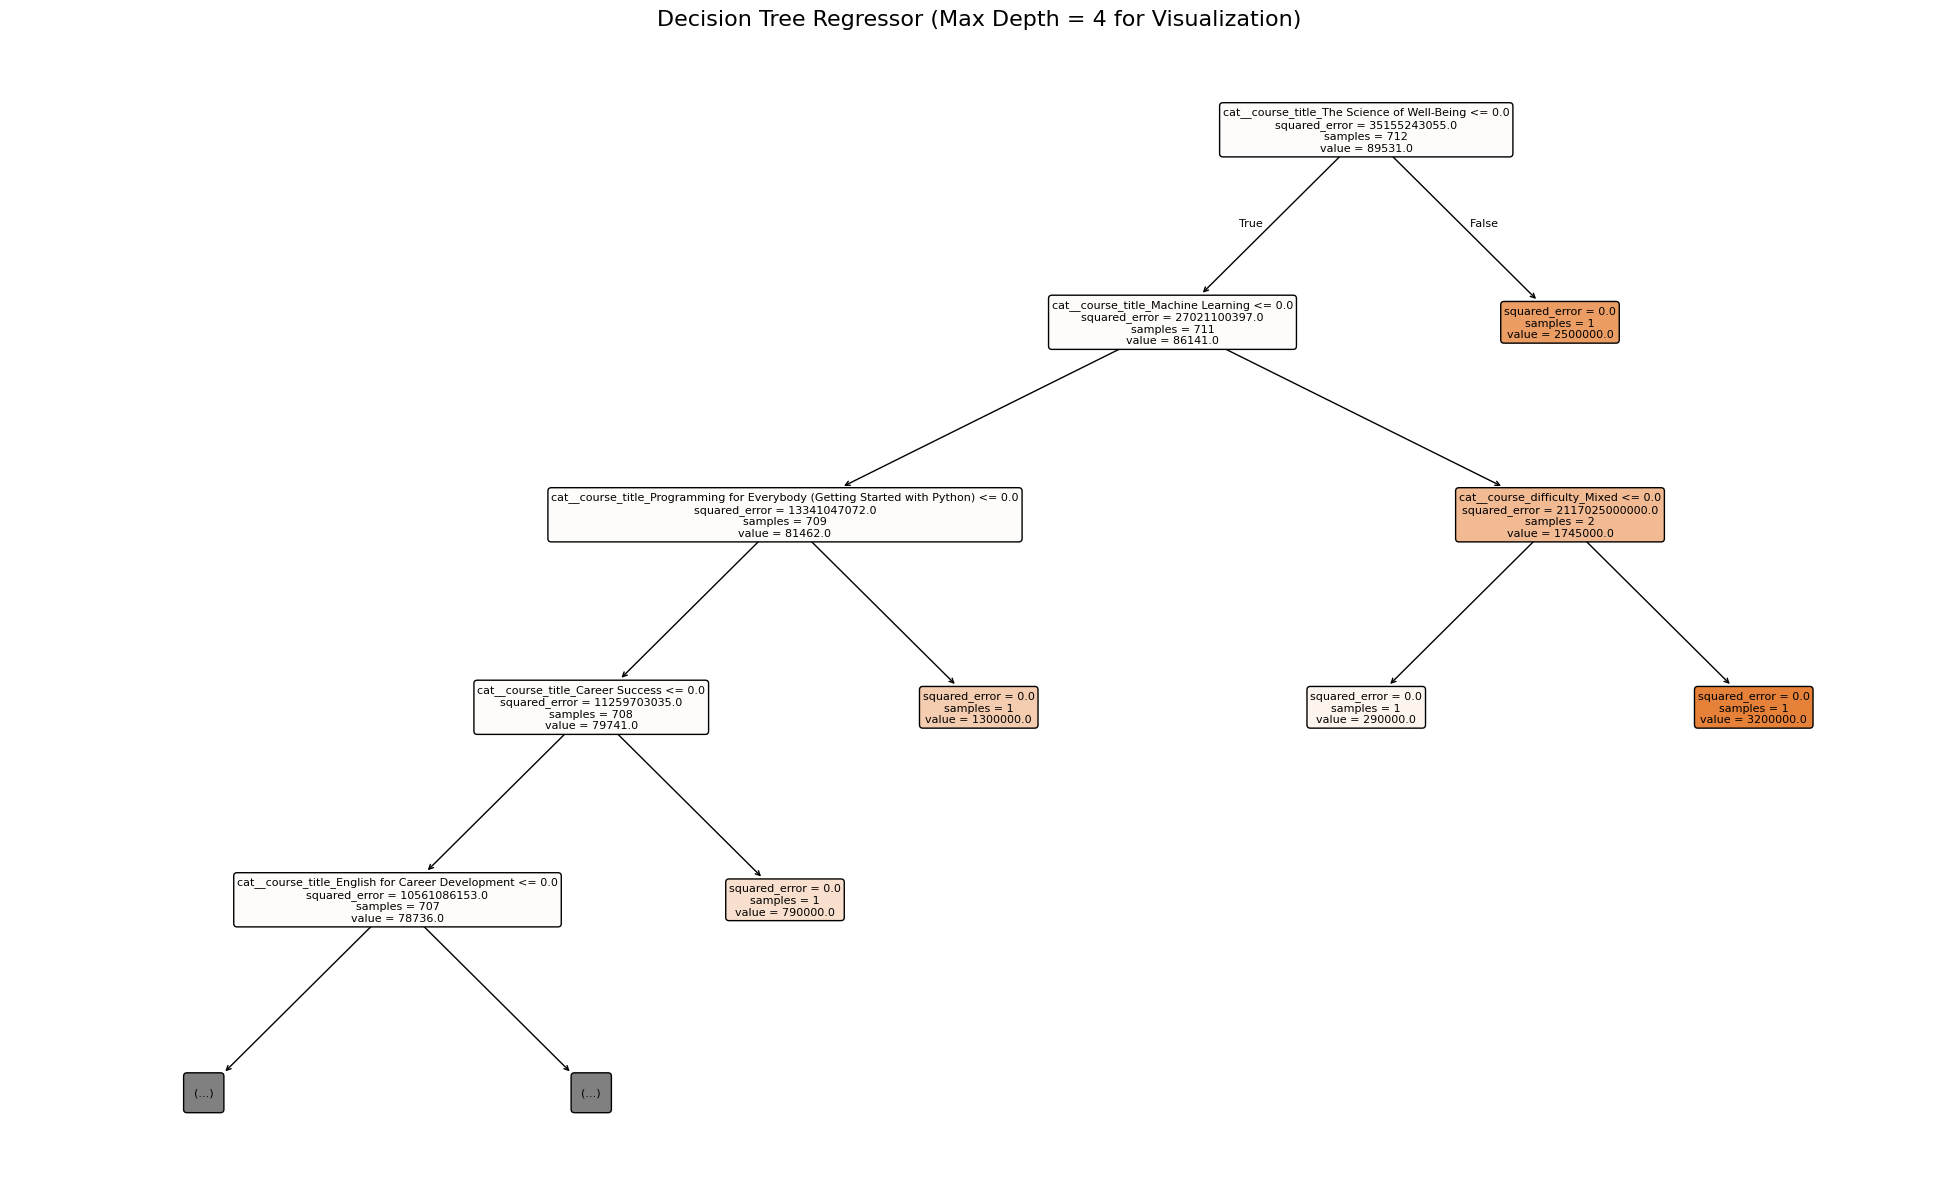


Tree node explanation:
- Each node shows the splitting condition (feature and threshold).
- 'samples' is the number of training samples reaching that node.
- 'value' is the average 'course_students_enrolled_numeric' for those samples.
- Leaf nodes (no further splits) represent the final prediction for samples ending there.

Code execution finished.


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. File Upload ---
print("Please upload your 'Copy of Coursera' CSV file:")
uploaded = files.upload()

# Assuming the uploaded file name is stored (usually the first key)
try:
    file_name = list(uploaded.keys())[0]
    print(f"\nSuccessfully uploaded {file_name}")
except IndexError:
    print("No file uploaded. Please run the cell again and upload the file.")
    # Exit or raise an error if no file is uploaded
    raise SystemExit("File upload cancelled or failed.")

# --- 2. Load Data ---
# Use io.BytesIO to read the uploaded bytes content into pandas
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
print("\nDataset loaded successfully.")
print("Original DataFrame shape:", df.shape)
print("First 5 rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())

# --- 3. Preprocess Target Variable ---
def convert_enrollment(value):
    """Converts strings like '5.3k' or '2.5m' to numerical values."""
    value = str(value).lower().strip()
    if pd.isna(value) or value == '':
        return np.nan
    try:
        if 'k' in value:
            return float(value.replace('k', '')) * 1000
        elif 'm' in value:
            return float(value.replace('m', '')) * 1000000
        else:
            # Handle cases that might already be numeric or have no suffix
            return float(value)
    except ValueError:
        # Handle cases where conversion is not possible
        print(f"Warning: Could not convert '{value}' to numeric. Returning NaN.")
        return np.nan

print("\nProcessing 'course_students_enrolled' into numerical format...")
df['course_students_enrolled_numeric'] = df['course_students_enrolled'].apply(convert_enrollment)

# Check for and remove rows where conversion failed
initial_rows = df.shape[0]
df.dropna(subset=['course_students_enrolled_numeric'], inplace=True)
rows_dropped = initial_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows due to conversion errors in enrollment.")

# Convert target to integer (optional, but often makes sense for counts)
df['course_students_enrolled_numeric'] = df['course_students_enrolled_numeric'].astype(int)

print("Processed 'course_students_enrolled':")
print(df[['course_students_enrolled', 'course_students_enrolled_numeric']].head())
print("DataFrame shape after processing target:", df.shape)


# --- 4. Prepare Features (X) and Target (y) ---
target = 'course_students_enrolled_numeric'
# Exclude the original target, the organization, and the processed target itself from features
features_to_exclude = ['course_organization', 'course_students_enrolled', target]
features = [col for col in df.columns if col not in features_to_exclude]

X = df[features]
y = df[target]

print(f"\nFeatures (X) columns: {X.columns.tolist()}")
print(f"Target (y) variable: {target}")

# --- 5. Identify Feature Types ---
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns # course_rating

print(f"\nIdentified Categorical Features: {categorical_features.tolist()}")
print(f"Identified Numerical Features: {numerical_features.tolist()}")

# --- 6. Create Preprocessor ---
# Use OneHotEncoder for categorical features
# 'passthrough' for numerical features (no scaling needed for basic decision trees)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep any other columns if they exist (shouldn't in this setup)
)

# --- 7. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 8. Define the Model ---
# We use DecisionTreeRegressor because enrollment is a continuous value
dt_regressor = DecisionTreeRegressor(random_state=42)
# You might want to limit tree depth later to prevent overfitting, e.g.:
# dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=5)

# --- 9. Create Pipeline ---
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', dt_regressor)])

# --- 10. Train Model ---
print("\nTraining the Decision Tree Regressor...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# --- 11. Evaluate Model ---
print("\nEvaluating the model on the test set...")
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}") # Closer to 1 is better

# --- 12. Visualize Tree ---
print("\nVisualizing the Decision Tree (limited depth)...")

# Get feature names after one-hot encoding from the fitted preprocessor
try:
    feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    # Fallback for older scikit-learn versions (less likely needed now)
    print("Warning: Could not automatically get feature names after encoding. Using generic names.")
    # Create generic names if needed (less informative)
    enc = pipeline.named_steps['preprocessor'].transformers_[1][1] # The OneHotEncoder
    encoded_cat_names = enc.get_feature_names_out(categorical_features)
    feature_names_out = np.concatenate([numerical_features, encoded_cat_names])


# Access the actual regressor model within the pipeline
regressor_model = pipeline.named_steps['regressor']

# Check tree size - It might be HUGE due to 'course_title'
full_depth = regressor_model.get_depth()
n_leaves = regressor_model.get_n_leaves()
print(f"\nFull tree depth: {full_depth}")
print(f"Full tree number of leaves: {n_leaves}")
print("\nWARNING: The 'course_title' feature likely has many unique values,")
print("which can lead to a very large, potentially overfit tree.")
print("The visualization below is limited to max_depth=4 for readability.")

plt.figure(figsize=(25, 15)) # Make figure larger
plot_tree(regressor_model,
          filled=True,
          feature_names=feature_names_out,
          max_depth=4, # Limit depth for visualization clarity! Increase if needed but risk unreadability
          fontsize=8,  # Adjust font size
          rounded=True,
          precision=0) # Show integer values for enrollment prediction
plt.title("Decision Tree Regressor (Max Depth = 4 for Visualization)", fontsize=16)
plt.show()

print("\nTree node explanation:")
print("- Each node shows the splitting condition (feature and threshold).")
print("- 'samples' is the number of training samples reaching that node.")
print("- 'value' is the average 'course_students_enrolled_numeric' for those samples.")
print("- Leaf nodes (no further splits) represent the final prediction for samples ending there.")

print("\nCode execution finished.")

Please upload your Coursera dataset CSV file.


Saving Copy of Coursera - CourseEra Data.csv to Copy of Coursera - CourseEra Data (3).csv

File 'Copy of Coursera - CourseEra Data (3).csv' uploaded successfully.

--- Dataset Loaded ---
Shape: (891, 6)

First 5 rows:
                                        course_title  \
0  (ISC)² Systems Security Certified Practitioner...   
1  A Crash Course in Causality:  Inferring Causal...   
2                     A Crash Course in Data Science   
3                            A Law Student's Toolkit   
4                A Life of Happiness and Fulfillment   

          course_organization course_Certificate_type  course_rating  \
0                      (ISC)²          SPECIALIZATION            4.7   
1  University of Pennsylvania                  COURSE            4.7   
2    Johns Hopkins University                  COURSE            4.5   
3             Yale University                  COURSE            4.7   
4   Indian School of Business                  COURSE            4.8   

  course_dif

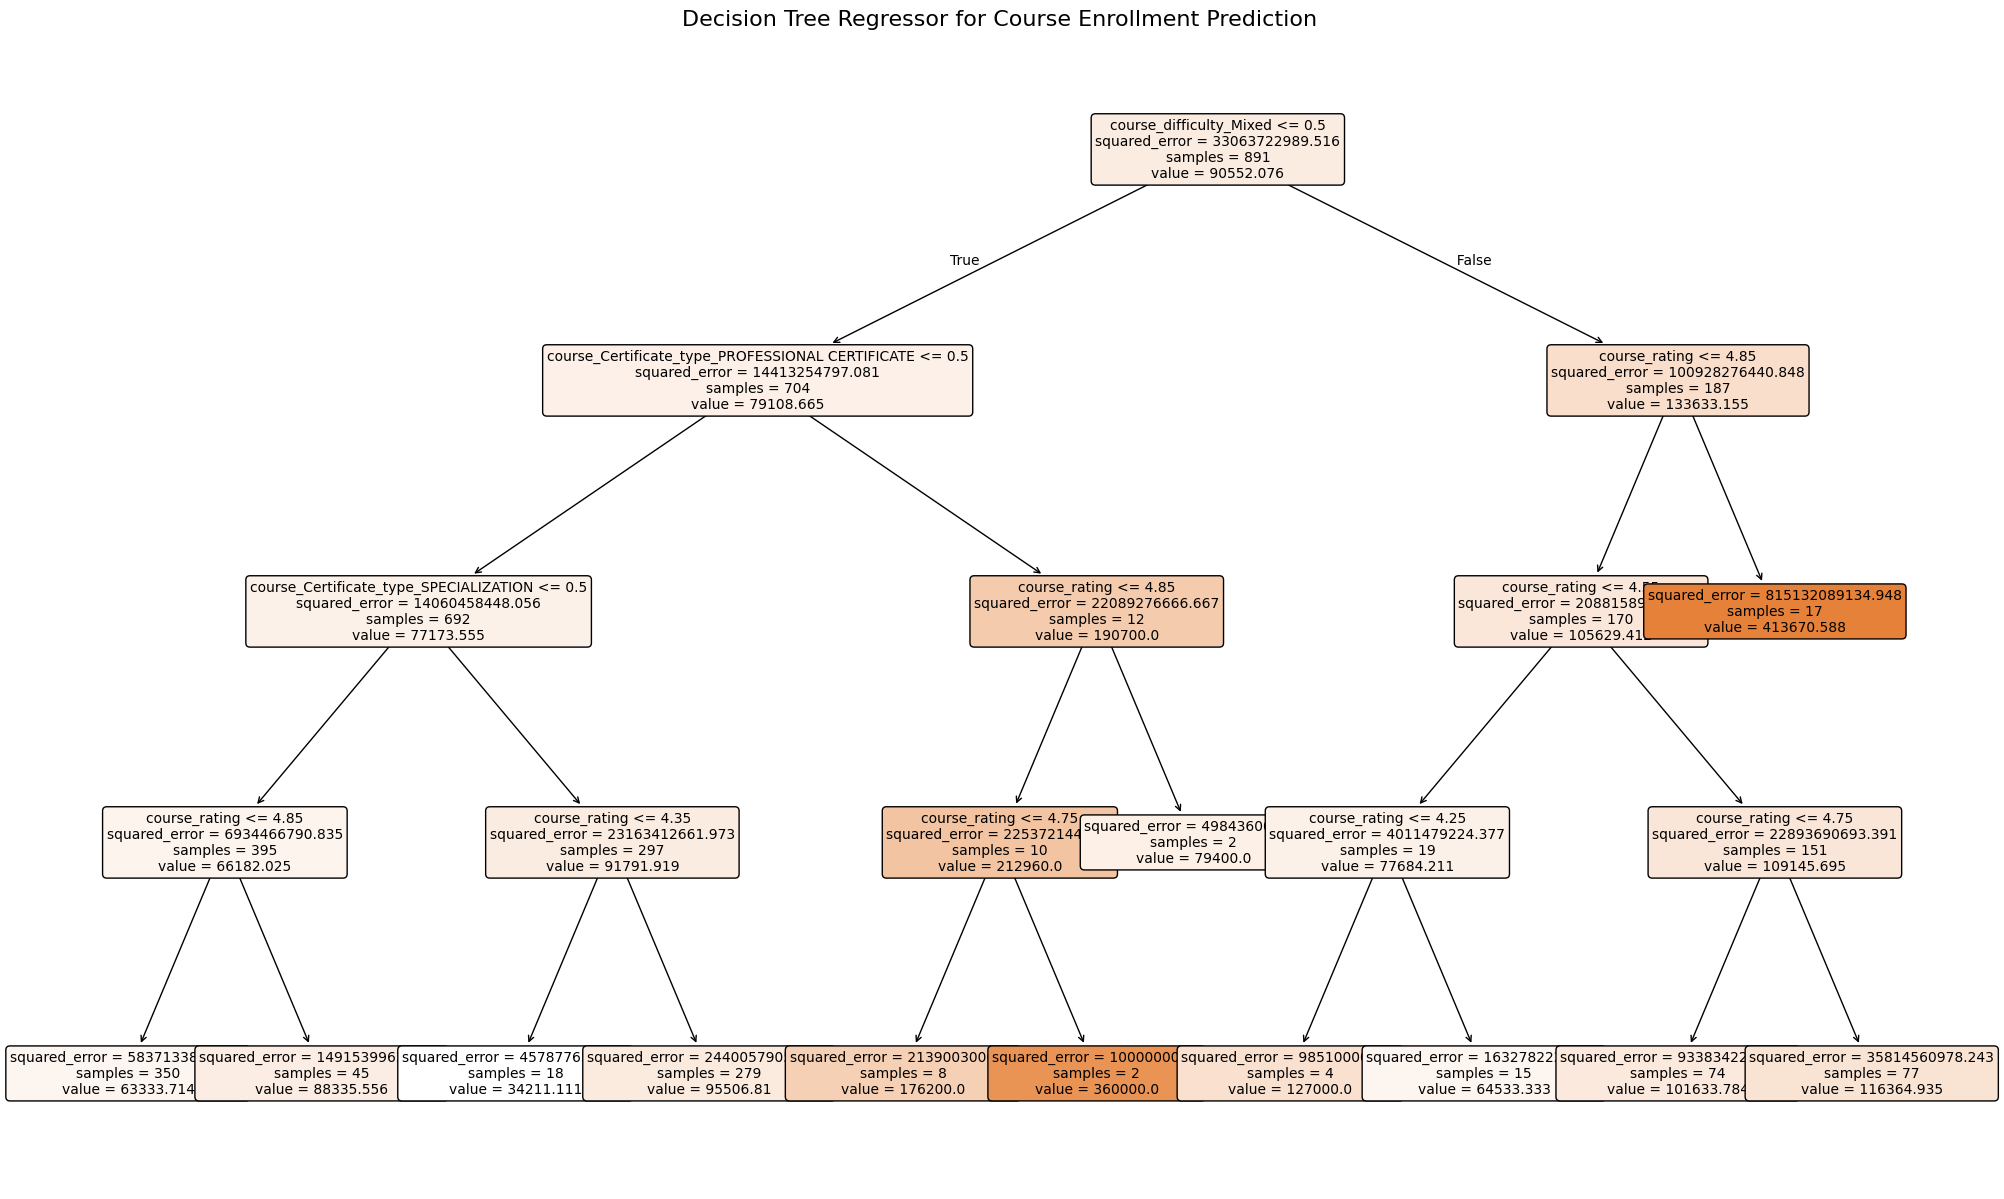


 Leaf node 'value' represents the predicted average enrollment for samples reaching that node.


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split # Although we fit on all data, useful for context
import matplotlib.pyplot as plt
import re # For cleaning enrollment numbers

# Function to parse the enrollment string (e.g., '5.3k', '3.2m') into numbers
def parse_enrollment(enrollment_str):
    """Converts enrollment strings like '5.3k' or '2.5m' to numeric."""
    if isinstance(enrollment_str, (int, float)):
        return float(enrollment_str) # Already numeric
    if not isinstance(enrollment_str, str):
        return np.nan # Handle unexpected types

    enrollment_str = enrollment_str.lower().strip()
    multiplier = 1

    if 'k' in enrollment_str:
        multiplier = 1000
        enrollment_str = enrollment_str.replace('k', '')
    elif 'm' in enrollment_str:
        multiplier = 1000000
        enrollment_str = enrollment_str.replace('m', '')

    try:
        # Use regex to find the first number (handles potential extra chars)
        num_match = re.match(r"[-+]?\d*\.?\d+", enrollment_str)
        if num_match:
             num_part = float(num_match.group(0))
             return num_part * multiplier
        else:
             return np.nan # No number found
    except (ValueError, TypeError):
        return np.nan # Return NaN if conversion fails

# --- Main Execution ---

print("Please upload your Coursera dataset CSV file.")
uploaded = files.upload()

# Assuming the uploaded file name contains 'Coursera'
# Get the actual filename (there should only be one file uploaded)
try:
    file_name = list(uploaded.keys())[0]
    print(f"\nFile '{file_name}' uploaded successfully.")
except IndexError:
    print("Error: No file was uploaded.")
    # Exit or handle error appropriately
    file_name = None

df = None
if file_name:
    try:
        # Read the uploaded CSV file into a pandas DataFrame
        df = pd.read_csv(io.BytesIO(uploaded[file_name]))
        print("\n--- Dataset Loaded ---")
        print(f"Shape: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nData Types:")
        print(df.info())

    except Exception as e:
        print(f"\nError reading CSV file: {e}")
        df = None # Ensure df is None if loading fails

if df is not None:
    print("\n--- Preprocessing Data ---")

    # 1. Exclude specified columns
    columns_to_drop = ['course_title', 'course_organization']
    # Check if columns exist before dropping
    columns_present = [col for col in columns_to_drop if col in df.columns]
    if columns_present:
         df = df.drop(columns=columns_present)
         print(f"Dropped columns: {columns_present}")
    else:
         print(f"Columns to drop ({columns_to_drop}) not found in the dataset.")


    # 2. Clean the target variable: 'course_students_enrolled'
    if 'course_students_enrolled' in df.columns:
        print("Cleaning 'course_students_enrolled' column...")
        original_nan_count = df['course_students_enrolled'].isnull().sum()
        df['course_students_enrolled'] = df['course_students_enrolled'].apply(parse_enrollment)
        cleaned_nan_count = df['course_students_enrolled'].isnull().sum()
        if cleaned_nan_count > original_nan_count:
            print(f"Warning: {cleaned_nan_count - original_nan_count} rows had unparseable enrollment values and are now NaN.")

        # Optionally, handle NaNs created during cleaning (e.g., drop rows)
        # df = df.dropna(subset=['course_students_enrolled'])
        # print(f"Dropped {cleaned_nan_count - original_nan_count} rows with NaN enrollment values.")

        # Convert to integer (if no NaNs remain or after handling them)
        # If you keep NaNs, it should remain float. DecisionTreeRegressor handles float targets.
        # df['course_students_enrolled'] = df['course_students_enrolled'].astype(int)
    else:
        print("Error: 'course_students_enrolled' column not found. Cannot proceed.")
        df = None # Stop processing


    # 3. Clean 'course_rating' (ensure it's numeric, handle potential errors)
    if df is not None and 'course_rating' in df.columns:
         print("Cleaning 'course_rating' column...")
         df['course_rating'] = pd.to_numeric(df['course_rating'], errors='coerce') # Coerce makes non-numeric NaN


    # 4. Handle any remaining missing values (e.g., drop rows or impute)
    # For simplicity, let's drop rows with any NaN value after cleaning
    if df is not None:
        initial_rows = df.shape[0]
        df = df.dropna()
        final_rows = df.shape[0]
        if initial_rows > final_rows:
            print(f"Dropped {initial_rows - final_rows} rows containing NaN values after cleaning.")


    # Proceed only if data cleaning was successful and data remains
    if df is not None and not df.empty:

        # 5. Separate features (X) and target (y)
        target_column = 'course_students_enrolled'
        X = df.drop(columns=[target_column])
        y = df[target_column]

        print("\n--- Feature Engineering ---")
        # 6. Identify categorical and numerical features
        categorical_features = X.select_dtypes(include=['object', 'category']).columns
        numerical_features = X.select_dtypes(include=np.number).columns

        print(f"Categorical features: {list(categorical_features)}")
        print(f"Numerical features: {list(numerical_features)}")

        # 7. Apply one-hot encoding to categorical features
        if not categorical_features.empty:
            print("Applying one-hot encoding...")
            X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True) # drop_first helps reduce multicollinearity
            print("Encoding complete.")
        else:
            X_encoded = X # No categorical features to encode

        print("\nFinal features used for training:")
        print(list(X_encoded.columns))
        print(f"\nShape of features (X_encoded): {X_encoded.shape}")
        print(f"Shape of target (y): {y.shape}")


        # --- Model Training ---
        print("\n--- Training Decision Tree Regressor ---")
        # Instantiate the Decision Tree Regressor
        # We use a Regressor because 'course_students_enrolled' is a number we want to predict.
        # Setting max_depth can prevent overfitting and make the tree visualization readable.
        # You can adjust max_depth or remove it to let the tree grow fully.
        dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=4) # Example max_depth

        # Fit the model on the entire prepared dataset
        dt_regressor.fit(X_encoded, y)
        print("Model training complete.")

        # --- Visualization ---
        print("\n--- Visualizing Decision Tree ---")
        plt.figure(figsize=(25, 15)) # Adjust figure size as needed
        plot_tree(
            dt_regressor,
            feature_names=X_encoded.columns.tolist(), # Use column names from the encoded DataFrame
            filled=True,       # Color nodes based on value/impurity
            rounded=True,      # Use rounded corners for nodes
            fontsize=10,       # Adjust font size
            # max_depth=3      # You can also limit depth here for visualization
        )
        plt.title("Decision Tree Regressor for Course Enrollment Prediction", fontsize=16)
        plt.show()
        print("\n Leaf node 'value' represents the predicted average enrollment for samples reaching that node.")

    elif df is not None and df.empty:
        print("\nDataset is empty after cleaning NaNs. Cannot build model.")
    else:
        print("\nCould not proceed due to errors in loading or preprocessing.")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load the data
df = pd.read_excel("coursera_courses.xlsx")

# 2. Parse enrollment strings into numeric counts
def parse_enrollment(x):
    """
    Convert strings like '5.3m', '17k', '4m' into floats.
    """
    if isinstance(x, str):
        x = x.strip().lower()
        if x.endswith('m'):
            return float(x[:-1]) * 1e6
        elif x.endswith('k'):
            return float(x[:-1]) * 1e3
        else:
            # no suffix: assume raw number
            try:
                return float(x)
            except:
                return pd.NA
    return x

df['course_students_enrolled'] = df['course_students_enrolled'].apply(parse_enrollment)

# Drop any rows with missing target
df = df.dropna(subset=['course_students_enrolled'])

# 3. Drop text columns
X = df.drop(columns=['course_title', 'course_organization', 'course_students_enrolled'])
y = df['course_students_enrolled']

# 4. Set up a preprocessing + model pipeline
categorical_cols = ['course_Certificate_type', 'course_difficulty']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_cols)
    ],
    remainder='passthrough'  # leave any other columns (none here) untouched
)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the model
pipeline.fit(X_train, y_train)

# 7. Evaluate
y_pred = pipeline.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R²:  ", r2_score(y_test, y_pred))

# (Optional) Export the tree visualization:
from sklearn import tree
import matplotlib.pyplot as plt

# Retrieve the trained tree
dt = pipeline.named_steps['model']
feature_names = pipeline.named_steps['preproc'].get_feature_names_out()

plt.figure(figsize=(20,10))
tree.plot_tree(dt, feature_names=feature_names, filled=True, rounded=True, max_depth=3)
plt.show()


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

MSE:  27321795932.455437
R²:   -0.10508271599785424


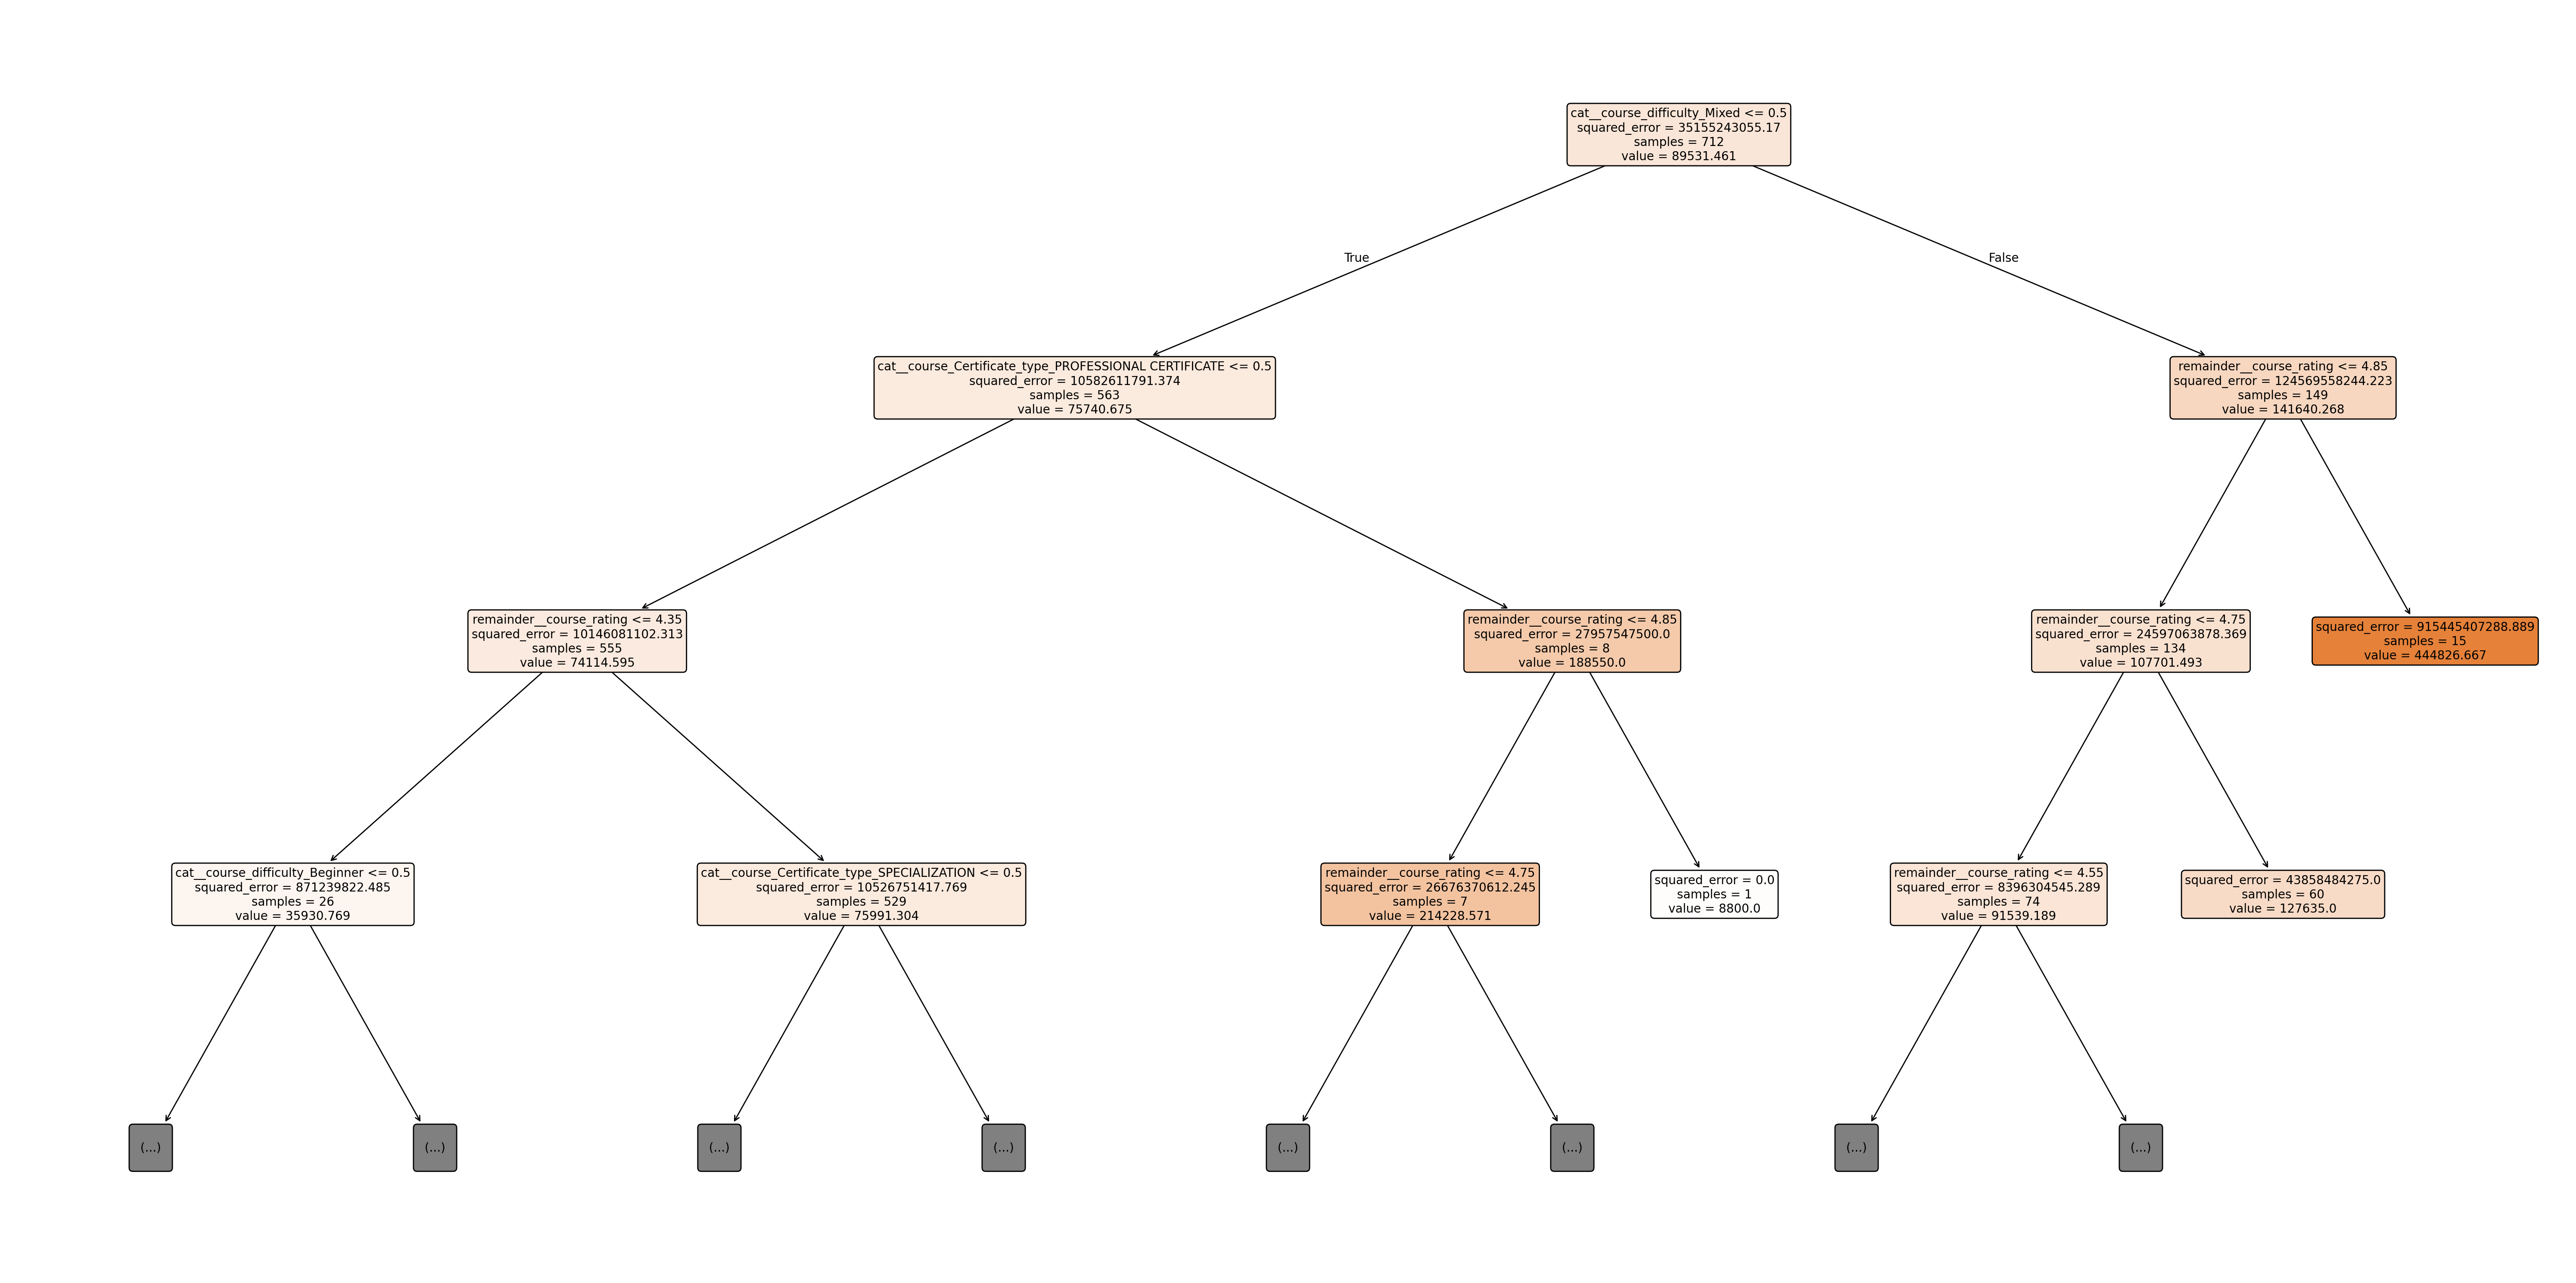

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
import matplotlib.pyplot as plt

# 1. Load the data
df = pd.read_excel("coursera_courses.xlsx")

# 2. Parse enrollment strings into numeric counts
def parse_enrollment(x):
    if isinstance(x, str):
        x = x.strip().lower()
        if x.endswith('m'):
            return float(x[:-1]) * 1e6
        elif x.endswith('k'):
            return float(x[:-1]) * 1e3
        else:
            try:
                return float(x)
            except:
                return pd.NA
    return x

df['course_students_enrolled'] = df['course_students_enrolled'].apply(parse_enrollment)
df = df.dropna(subset=['course_students_enrolled'])

# 3. Set up features and target
X = df.drop(columns=['course_title', 'course_organization', 'course_students_enrolled'])
y = df['course_students_enrolled']

# 4. Preprocessing + model pipeline
categorical_cols = ['course_Certificate_type', 'course_difficulty']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit the model
pipeline.fit(X_train, y_train)

# 7. Evaluate
y_pred = pipeline.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R²:  ", r2_score(y_test, y_pred))


# Retrieve trained tree and feature names
dt = pipeline.named_steps['model']
feature_names = pipeline.named_steps['preproc'].get_feature_names_out()

# Enlarge figure and resolution
plt.figure(figsize=(30, 15), dpi=200)

tree.plot_tree(
    dt,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,      # you can increase or remove to see more levels
    fontsize=10       # bump up font size
)

plt.tight_layout()
plt.show()



In [ ]:
pip install pandas openpyxl scikit-learn matplotlib

Successfully loaded data from coursera_courses.xlsx
Initial data shape: (891, 6)

Cleaning 'course_students_enrolled' column...

Handling missing values...
No missing values found in 'course_rating'.

Created binned target variable 'course_students_enrolled_binned':
course_students_enrolled_binned
Medium (10k-50k)     371
High (50k-200k)      301
Low (0-10k)          118
Very High (200k+)    101
Name: count, dtype: int64

Selected features (X shape): (891, 3)
Selected target (y shape): (891,)

Encoding categorical features using One-Hot Encoding...
Data shape after encoding: (891, 8)

Splitting data into Training and Testing sets (80/20 split)...
Training set shape: X=(712, 8), y=(712,)
Testing set shape: X=(179, 8), y=(179,)

Training Decision Tree Classifier...

Calculating Feature Importances...

Feature Importances (from Decision Tree):
                                            Feature  Importance
0                                     course_rating    0.483186
7                  

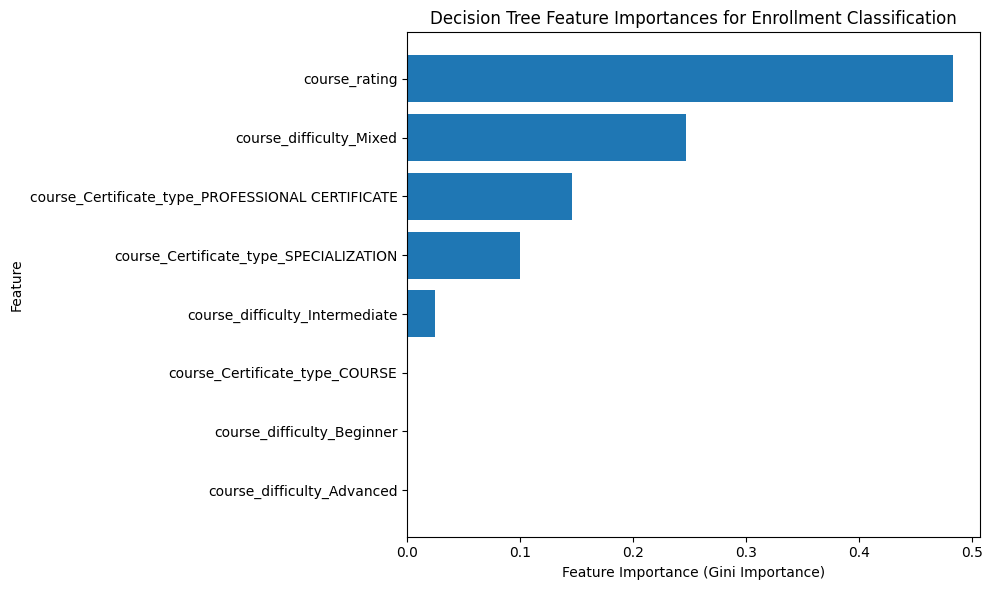

Training complete.

Evaluating model on the Test set...

Accuracy: 0.4078

Classification Report:
                   precision    recall  f1-score   support

      Low (0-10k)       0.38      0.25      0.30        60
 Medium (10k-50k)       0.00      0.00      0.00        24
  High (50k-200k)       0.42      0.77      0.54        75
Very High (200k+)       0.00      0.00      0.00        20

         accuracy                           0.41       179
        macro avg       0.20      0.26      0.21       179
     weighted avg       0.30      0.41      0.33       179


Confusion Matrix:
                   Low (0-10k)  Medium (10k-50k)  High (50k-200k)  \
Low (0-10k)                  0                22                2   
Medium (10k-50k)             0                58               17   
High (50k-200k)              0                45               15   
Very High (200k+)            0                14                6   

                   Very High (200k+)  
Low (0-10k)            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


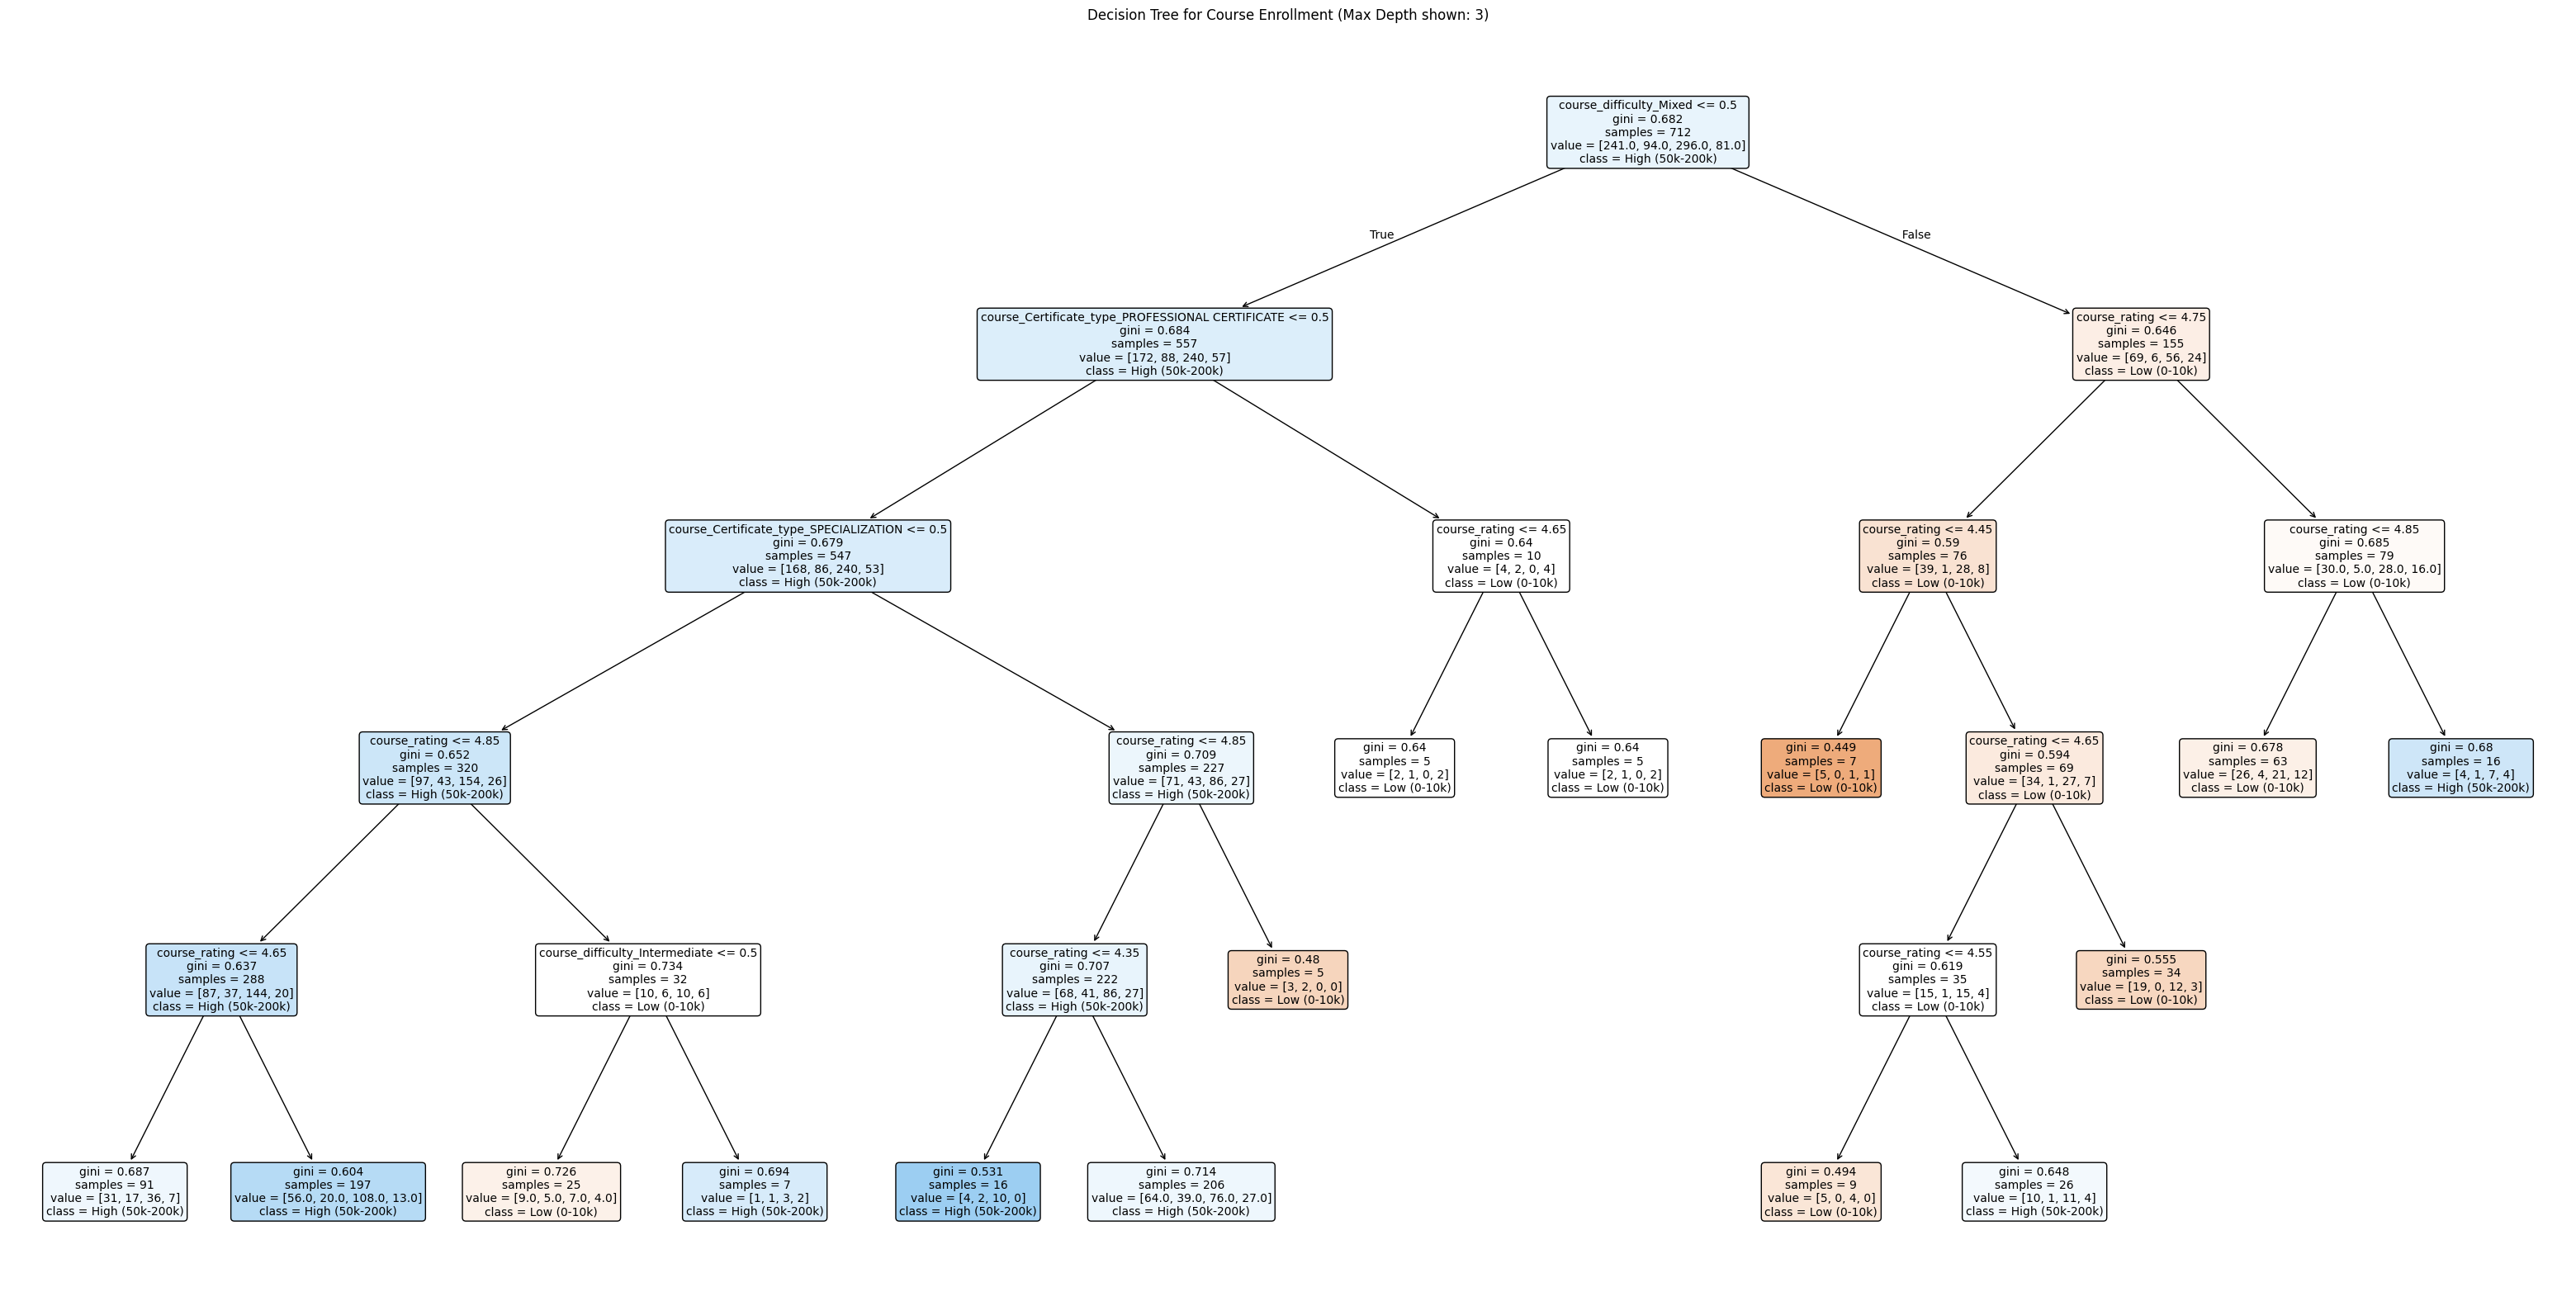


--- Process Complete ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import re # For cleaning enrollment numbers

# --- Configuration ---
file_path = 'coursera_courses.xlsx'  # <--- CHANGE THIS TO YOUR ACTUAL FILE PATH
target_column = 'course_students_enrolled'
columns_to_drop = ['course_title', 'course_organization', target_column] # Drop original target later
categorical_features = ['course_Certificate_type', 'course_difficulty']
numerical_features = ['course_rating']

# --- Functions ---
def clean_enrollment(enrollment_str):
    """Converts enrollment strings (e.g., '5.3k', '130k', '8.1m') to numbers."""
    if isinstance(enrollment_str, (int, float)):
        return enrollment_str # Already numeric
    if not isinstance(enrollment_str, str):
        return np.nan # Handle unexpected types

    enrollment_str = enrollment_str.lower().strip()
    num_part = re.findall(r"[\d\.]+", enrollment_str) # Find numeric part (including decimal)

    if not num_part:
        return np.nan # No number found

    num = float(num_part[0])

    if 'k' in enrollment_str:
        return num * 1000
    elif 'm' in enrollment_str:
        return num * 1000000
    else:
        # Assuming it's a raw number if no k or m (though sample suggests k/m is common)
        return num # Or return np.nan if only k/m expected

# --- 1. Load Data ---
try:
    df = pd.read_excel(file_path)
    print(f"Successfully loaded data from {file_path}")
    print(f"Initial data shape: {df.shape}")
    # print("Initial columns:", df.columns.tolist())
    # print("\nFirst 5 rows:")
    # print(df.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- 2. Clean Enrollment Data ---
print(f"\nCleaning '{target_column}' column...")
df[target_column] = df[target_column].apply(clean_enrollment)
# Drop rows where enrollment couldn't be parsed or is missing
initial_rows = len(df)
df.dropna(subset=[target_column], inplace=True)
if len(df) < initial_rows:
     print(f"Dropped {initial_rows - len(df)} rows due to missing/unparseable enrollment values.")
df[target_column] = df[target_column].astype(int) # Convert to integer after cleaning
# print(f"\nCleaned '{target_column}' examples:")
# print(df[target_column].head())

# --- 3. Handle Missing Values (Example: course_rating) ---
print("\nHandling missing values...")
# Check for missing ratings specifically
if df['course_rating'].isnull().any():
    median_rating = df['course_rating'].median()
    print(f"Filling {df['course_rating'].isnull().sum()} missing ratings with median value: {median_rating}")
    df['course_rating'].fillna(median_rating, inplace=True)
else:
    print("No missing values found in 'course_rating'.")

# General check for other NaNs in selected feature columns
feature_cols = categorical_features + numerical_features
if df[feature_cols].isnull().any().any():
    print(f"Warning: Found NaNs in other feature columns. Dropping rows with any NaN in features.")
    initial_rows = len(df)
    df.dropna(subset=feature_cols, inplace=True)
    print(f"Dropped {initial_rows - len(df)} rows.")


# --- 4. Create Target Variable (Bins) ---
# Define enrollment bins (adjust thresholds as needed)
# You might want to analyze the distribution of df[target_column].describe() to set better bins
bins = [-1, 9999, 49999, 199999, float('inf')] # Bins: <10k, 10k-50k, 50k-200k, 200k+
labels = ['Low (0-10k)', 'Medium (10k-50k)', 'High (50k-200k)', 'Very High (200k+)']
target_binned_col = target_column + '_binned'
df[target_binned_col] = pd.cut(df[target_column], bins=bins, labels=labels, right=True)

print(f"\nCreated binned target variable '{target_binned_col}':")
print(df[target_binned_col].value_counts())

# --- 5. Select Features and Target ---
X = df[categorical_features + numerical_features].copy() # Features
y = df[target_binned_col] # Target (the binned categories)

if X.empty or y.empty:
    print("\nError: No data remaining after cleaning and preprocessing. Check input file and cleaning steps.")
    exit()

print(f"\nSelected features (X shape): {X.shape}")
print(f"Selected target (y shape): {y.shape}")
# print("Features head:\n", X.head())
# print("Target head:\n", y.head())

# --- 6. Encode Categorical Features ---
print("\nEncoding categorical features using One-Hot Encoding...")
X = pd.get_dummies(X, columns=categorical_features, drop_first=False) # drop_first=False is often safer for trees
print(f"Data shape after encoding: {X.shape}")
# print("Features after encoding head:\n", X.head())

# Store feature names *after* encoding for tree visualization
feature_names_encoded = X.columns.tolist()

# --- 7. Split Data ---
print("\nSplitting data into Training and Testing sets (80/20 split)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify helps maintain class proportions
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

# --- 8. Train Decision Tree ---
print("\nTraining Decision Tree Classifier...")
# Initialize the classifier (you can tune parameters like max_depth, min_samples_leaf)
# Setting max_depth can help prevent overfitting and make the tree more interpretable
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)

# Train the model
dt_classifier.fit(X_train, y_train)
# --- Add this section after dt_classifier.fit(X_train, y_train) ---

print("\nCalculating Feature Importances...")

# Get feature importances
importances = dt_classifier.feature_importances_

# Create a pandas DataFrame for easier viewing
# feature_names_encoded should be the list of column names AFTER one-hot encoding
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_encoded,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (from Decision Tree):")
print(feature_importance_df)

# --- Optional: Create a bar plot for visualization (Figure AA) ---
print("\nGenerating Feature Importance Plot (Figure AA)...")

# Select top N features to plot (e.g., top 10 or all if not too many)
top_n = len(feature_importance_df) # Plot all features, adjust if needed e.g., top_n = 10
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n], align='center')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Decision Tree Feature Importances for Enrollment Classification")
plt.tight_layout() # Adjust layout
plt.show() # Display the plot
print("Training complete.")

# --- 9. Evaluate Model ---
print("\nEvaluating model on the Test set...")
y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels)) # Use original labels here

print("\nConfusion Matrix:")
# Use pd.DataFrame for better readability of confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# --- 10. Visualize Tree (Optional) ---
print("\nGenerating decision tree plot (may take a moment for large trees)...")
plt.figure(figsize=(40, 20)) # Adjust figure size as needed
plot_tree(dt_classifier,
          filled=True,
          rounded=True,
          class_names=labels, # Use the explicit labels for class names
          feature_names=feature_names_encoded, # Use the encoded feature names
          max_depth=5, # Limit plot depth for readability, adjust as needed
          fontsize=10)
plt.title(f"Decision Tree for Course Enrollment (Max Depth shown: {min(3, dt_classifier.get_depth())})")
plt.show() # Display the plot

print("\n--- Process Complete ---")

In [ ]:
pip install pandas openpyxl

In [ ]:
import pandas as pd
import numpy as np
import re # Using regex for slightly more robust matching

# --- Configuration ---
input_file_path = 'coursera_courses.xlsx'  # <--- CHANGE THIS TO YOUR ACTUAL FILE PATH
output_file_path = 'coursera_data_classified_v1.xlsx' # Output file name

# --- Define Computing Keywords ---
# List of keywords (lowercase) indicative of computing courses.
# REVIEW AND REFINE THIS LIST CAREFULLY!
computing_keywords = [
    # Programming & Core CS
    'python', 'java', 'javascript', 'c++', ' c ', 'programming', 'coding', 'developer', 'development',
    'computer science', 'algorithm', 'data structure', 'computational', 'computing',
    'software', ' app ', # Added spaces around 'app'
    'operating system', 'linux', 'scripting', 'kotlin', 'scala', 'swift', 'matlab', 'vba',

    # Data Science & AI/ML
    'data science', 'machine learning', 'artificial intelligence', ' ai ', 'deep learning', 'neural network',
    'analytics', 'data mining', 'data analysis', 'data visualization', 'statistics', 'quantitative modeling',
    'sql', 'database', 'big data', 'tableau', 'pandas', 'numpy', 'scikit-learn', 'tensorflow', 'pytorch',
    'natural language processing', 'nlp', 'reinforcement learning', 'ibm data', 'sas ', 'spss',

    # Web Development & Design
    'web ', 'front-end', 'back-end', 'html', 'css', 'react', 'angular', 'node.js', 'php', 'ruby',
    'ux', 'ui', 'user experience', 'user interface', 'design thinking', # Design thinking often related in tech

    # Cybersecurity & Networking
    'cybersecurity', 'security', 'information security', 'network', 'networking', 'cisco',
    'cryptography', 'penetration testing', 'ethical hacking', 'access control',

    # Cloud & Infrastructure
    'cloud', 'aws', 'azure', 'google cloud', 'gcp', 'cloud architecture', 'serverless', 'docker',
    'kubernetes', 'devops', 'infrastructure', 'system administration', 'site reliability',

    # Hardware & IoT
    'iot', 'internet of things', 'embedded systems', 'raspberry pi', 'arduino', 'fpga', 'hardware',
    'robotics', 'robot',

    # Specific Tools/Platforms often in Computing context
    'atlassian', 'jira', 'git', 'unity', 'autodesk cad', # CAD can be borderline, but often linked

    # Specific Course Titles/Phrases (Use sparingly)
    'applied data science', 'ibm ai', 'google it'
]

# --- Function to Classify Domain ---
def classify_domain(title):
    """Classifies a course title as 'Computing' or 'Undefined'."""
    if pd.isna(title):
        return 'Undefined'
    title_lower = str(title).lower()

    for keyword in computing_keywords:
        # Using word boundaries for more accuracy (matches whole words or keywords with spaces)
        # Escape handles potential special regex chars in keywords like C++
        pattern = r'\b' + re.escape(keyword.strip()) + r'\b'
        if re.search(pattern, title_lower):
            return 'Computing' # Found a keyword, classify and exit function

    # If no computing keywords were found after checking all of them
    return 'Undefined'

# --- Main Execution ---
# 1. Load Data
try:
    df = pd.read_excel(input_file_path)
    print(f"Successfully loaded data from '{input_file_path}' ({len(df)} rows)")
except FileNotFoundError:
    print(f"Error: Input file not found at '{input_file_path}'")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# 2. Classify Domains
print("Classifying courses based on title keywords...")
df['domain_category'] = df['course_title'].apply(classify_domain)

# 3. Print Counts
print("\nDomain Classification Counts:")
category_counts = df['domain_category'].value_counts()
print(category_counts)

# 4. Save Classified Data to New Excel File
print(f"\nSaving classified data to '{output_file_path}'...")
try:
    # Use index=False to avoid writing the pandas index as a column in Excel
    df.to_excel(output_file_path, index=False, engine='openpyxl') # Specify engine if needed
    print("Successfully saved classified data.")
except Exception as e:
    print(f"Error saving data to Excel: {e}")
    print("Please ensure you have 'openpyxl' installed (`pip install openpyxl`)")

print("\n--- Process Complete ---")
print(f"Please review the file '{output_file_path}' to verify the 'domain_category' column.")
print("You can then manually correct any misclassifications in that file if needed for the next step.")

Successfully loaded data from 'coursera_courses.xlsx' (891 rows)
Classifying courses based on title keywords...

Domain Classification Counts:
domain_category
Undefined    616
Computing    275
Name: count, dtype: int64

Saving classified data to 'coursera_data_classified_v1.xlsx'...
Successfully saved classified data.

--- Process Complete ---
Please review the file 'coursera_data_classified_v1.xlsx' to verify the 'domain_category' column.
You can then manually correct any misclassifications in that file if needed for the next step.


https://docs.google.com/spreadsheets/d/1bjwBEpQCBD4OTebxPS0e8tjbO4H-j_3umHQ_0i8YNtM

Please upload your XLSX dataset file:


Saving xx.xlsx to xx (2).xlsx

Uploaded file 'xx (2).xlsx'
Successfully loaded data from xx (2).xlsx
Initial data shape: (30, 8)

Selected relevant columns. Shape: (30, 7)

--- Starting Data Preprocessing ---

Checking for missing values...
Institution                               0
Domain                                    0
Honor Code Certificates                   0
Median Age                                0
% Male                                    0
% Bachelor's Degree or Higher             0
Participants (Course Content Accessed)    0
dtype: int64

Missing value handling complete.

Binning the target variable: 'Participants (Course Content Accessed)'

Distribution of target variable:
count        30.000000
mean      50911.133333
std       72823.868447
min         322.000000
25%       13361.750000
50%       21040.000000
75%       56450.500000
max      301082.000000
Name: Participants (Course Content Accessed), dtype: float64

Created binned target variable 'Participants (Course 

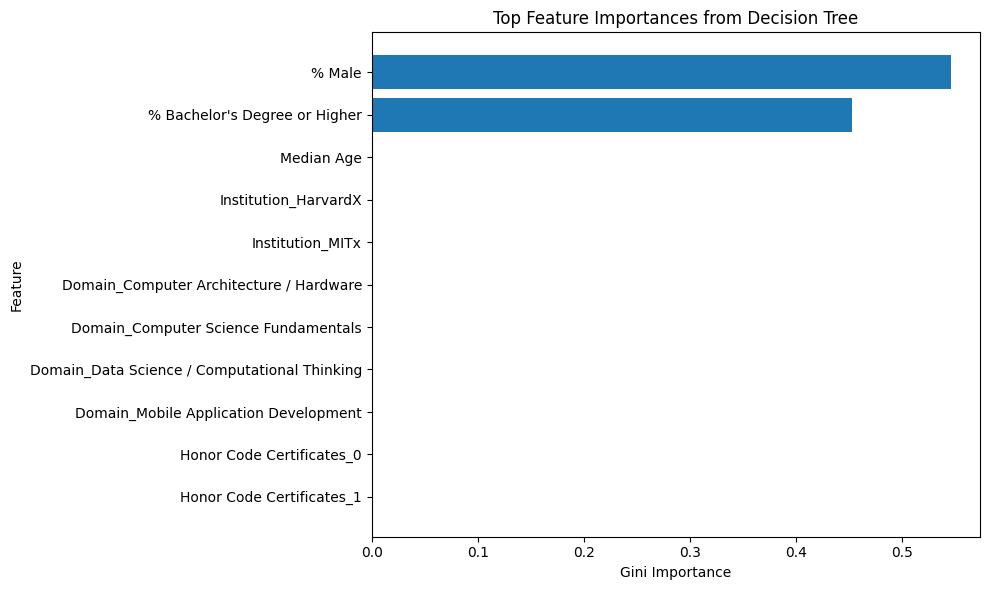


--- Visualizing Decision Tree ---


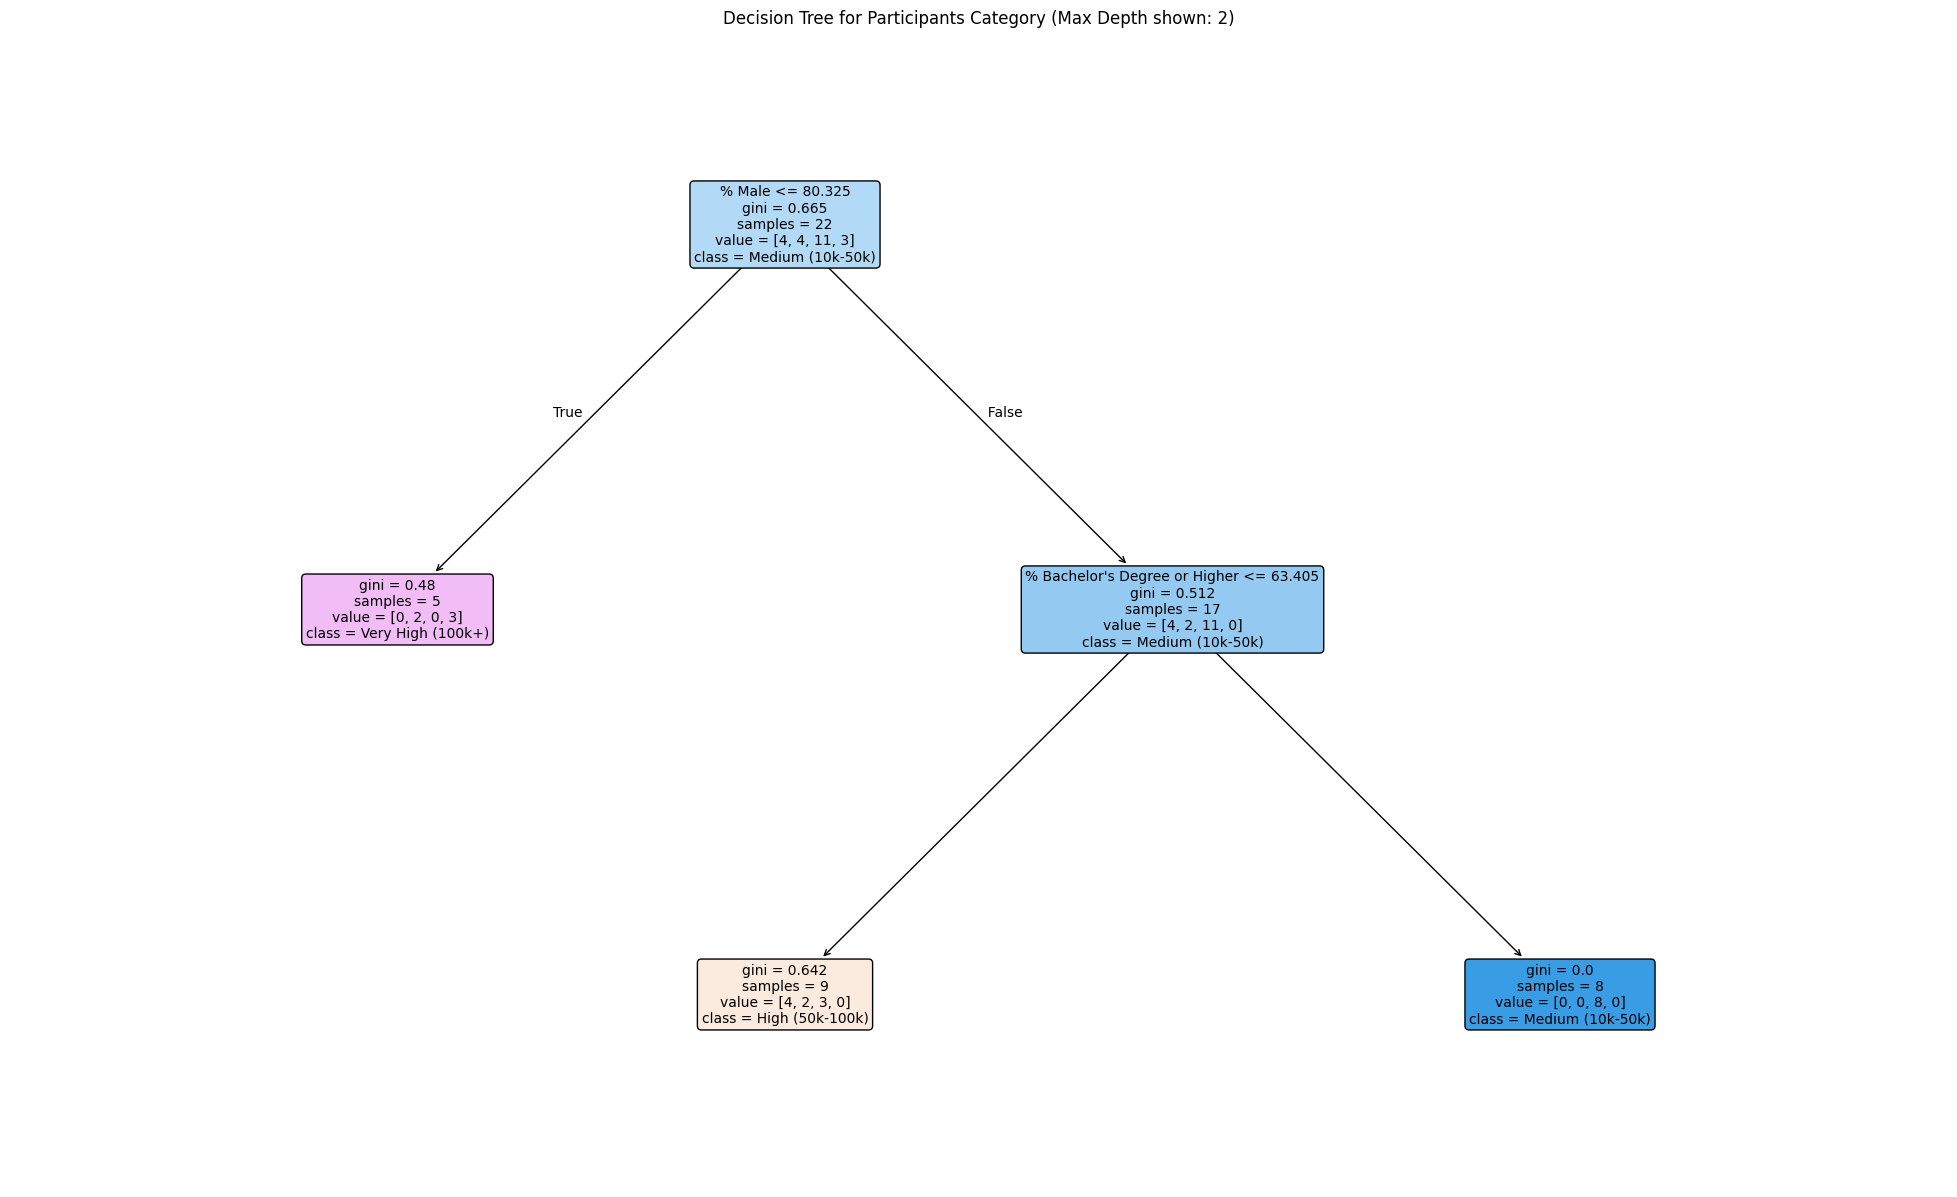


--- Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder # Although pandas.get_dummies is easier here
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. File Upload ---
print("Please upload your XLSX dataset file:")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("\nNo file uploaded. Please run the cell again and upload the file.")
else:
    # Get the filename (assuming only one file uploaded)
    file_name = next(iter(uploaded))
    print(f"\nUploaded file '{file_name}'")

    # --- 2. Load Data ---
    try:
        # Read the uploaded bytes into a pandas DataFrame
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        print(f"Successfully loaded data from {file_name}")
        print(f"Initial data shape: {df.shape}")
        # print("Initial columns:", df.columns.tolist())
        # print("\nFirst 5 rows:")
        # print(df.head())
    except Exception as e:
        print(f"\nError loading data from {file_name}: {e}")
        df = None # Ensure df is None if loading fails

# Proceed only if data loading was successful
if df is not None:

    # --- 3. Configuration & Column Selection ---
    target_column_raw = 'Participants (Course Content Accessed)'
    target_column_binned = target_column_raw + '_binned'

    # Define predictor columns based on final decision
    categorical_features = [
        'Institution',
        'Domain',
        'Honor Code Certificates' # Treat as categorical 0/1
    ]
    numerical_features = [
        'Median Age',
        '% Male',
        # '% Female' is excluded as it's redundant with % Male
        "% Bachelor's Degree or Higher"
    ]
    features_to_use = categorical_features + numerical_features

    # Select only necessary columns + target
    columns_to_keep = features_to_use + [target_column_raw]
    # Check if all columns exist
    missing_req_cols = [col for col in columns_to_keep if col not in df.columns]
    if missing_req_cols:
        print(f"\nError: The following required columns are missing from the dataset: {missing_req_cols}")
        df = None # Stop processing
    else:
        df_selected = df[columns_to_keep].copy()
        print(f"\nSelected relevant columns. Shape: {df_selected.shape}")


# Proceed only if column selection was successful
if df is not None and 'df_selected' in locals():

    # --- 4. Data Preprocessing ---
    print("\n--- Starting Data Preprocessing ---")

    # --- 4a. Handle Missing Values (Example: Median Imputation for Numerical) ---
    print("\nChecking for missing values...")
    print(df_selected.isnull().sum())

    # Impute numerical features with median (adjust strategy if needed)
    for col in numerical_features:
        if df_selected[col].isnull().any():
            median_val = df_selected[col].median()
            df_selected[col].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{col}' with median ({median_val}).")

    # Impute categorical features with mode (or drop rows if few missing)
    for col in categorical_features:
         if df_selected[col].isnull().any():
            mode_val = df_selected[col].mode()[0] # Get the most frequent value
            df_selected[col].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in '{col}' with mode ('{mode_val}').")

    # Final check
    if df_selected.isnull().any().any():
        print("\nWarning: Missing values might still exist after imputation. Review data.")
    else:
        print("\nMissing value handling complete.")

    # --- 4b. Bin the Target Variable ---
    print(f"\nBinning the target variable: '{target_column_raw}'")
    # Analyze distribution to set bins (crucial step!)
    print("\nDistribution of target variable:")
    print(df_selected[target_column_raw].describe())

    # DEFINE BINS AND LABELS (ADJUST THESE BASED ON 'describe()' OUTPUT AND YOUR GOALS)
    # Example bins: <10k, 10k-50k, 50k-100k, 100k+
    # You MUST look at your data's min/max/quartiles from describe() to set meaningful bins
    bins = [-1, 9999, 49999, 99999, float('inf')]
    labels = ['Low (<10k)', 'Medium (10k-50k)', 'High (50k-100k)', 'Very High (100k+)'] # Adjust labels to match bins

    # Alternative: Use quantiles for potentially more balanced bins
    # try:
    #     df_selected[target_column_binned], bins = pd.qcut(df_selected[target_column_raw], q=4, labels=False, retbins=True, duplicates='drop')
    #     # Create labels based on returned bins
    #     labels = [f'Q{i+1} ({bins[i]:.0f}-{bins[i+1]:.0f})' for i in range(len(bins)-1)]
    #     # Apply labels (need to map integer output of qcut back to labels if labels=False was used)
    #     label_map = {i: label for i, label in enumerate(labels)}
    #     df_selected[target_column_binned] = df_selected[target_column_binned].map(label_map)
    #     print(f"Created 4 bins using quantiles (pd.qcut).")
    # except Exception as e:
    #     print(f"Could not create quantile bins (maybe too few data points or duplicate edges): {e}")
    #     print("Falling back to fixed bins. DEFINE FIXED BINS MANUALLY.")
    #     # DEFINE FIXED BINS HERE IF qcut FAILS OR IS NOT DESIRED
    #     bins = [-1, 9999, 49999, 99999, float('inf')]
    #     labels = ['Low (<10k)', 'Medium (10k-50k)', 'High (50k-100k)', 'Very High (100k+)'] # Adjust labels to match bins
    #     df_selected[target_column_binned] = pd.cut(df_selected[target_column_raw], bins=bins, labels=labels, right=True)


    # Apply fixed bins (DEFAULT - uncomment qcut section above to use quantiles instead)
    df_selected[target_column_binned] = pd.cut(df_selected[target_column_raw], bins=bins, labels=labels, right=True)


    print(f"\nCreated binned target variable '{target_column_binned}':")
    print(df_selected[target_column_binned].value_counts())

    # Check if any rows failed binning (became NaN)
    if df_selected[target_column_binned].isnull().any():
        print("\nWarning: Some rows could not be binned. Check bin definitions and data.")
        # Option: Drop rows that couldn't be binned
        # df_selected.dropna(subset=[target_column_binned], inplace=True)
        # print("Dropped rows that could not be binned.")


    # --- 4c. One-Hot Encode Categorical Features ---
    print("\nEncoding categorical features using One-Hot Encoding...")
    # Use drop_first=False which is often safer for trees, although True saves one dimension
    df_processed = pd.get_dummies(df_selected, columns=categorical_features, drop_first=False, dtype=int)
    print(f"Data shape after encoding: {df_processed.shape}")
    # print("Columns after encoding:", df_processed.columns.tolist())

    # --- 4d. Define Final Features (X) and Target (y) ---
    X = df_processed.drop(columns=[target_column_raw, target_column_binned]) # Drop original target and binned target
    y = df_processed[target_column_binned]

    # Store feature names *after* encoding for importance/plotting
    feature_names_encoded = X.columns.tolist()

    # --- 5. Train-Test Split ---
    print("\n--- Splitting Data ---")
    # Stratify ensures class proportions are similar in train/test sets
    # random_state ensures reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    print("\nTraining set target distribution:")
    print(y_train.value_counts(normalize=True))
    print("\nTesting set target distribution:")
    print(y_test.value_counts(normalize=True))


    # --- 6. Train Decision Tree Model ---
    print("\n--- Training Decision Tree Classifier ---")
    # Initialize the classifier
    # Parameters to tune: max_depth, min_samples_leaf, criterion ('gini' or 'entropy')
    dt_classifier = DecisionTreeClassifier(
        criterion='gini',       # Splitting criterion ('gini' or 'entropy' for information gain based)
        max_depth=5,            # Max depth to prevent overfitting (tune this)
        min_samples_leaf=5,     # Min samples in a leaf node (tune this)
        random_state=42
    )

    # Train the model
    dt_classifier.fit(X_train, y_train)
    print("Training complete.")

    # --- 7. Evaluate Model ---
    print("\n--- Evaluating Model on Test Set ---")
    y_pred = dt_classifier.predict(X_test)

    # --- 7a. Accuracy ---
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")

    # --- 7b. Classification Report ---
    print("\nClassification Report:")
    # Ensure labels used here match the ones created during binning
    # Use unique labels present in y_test or y if there were issues
    report_labels = sorted(y.astype(str).unique())
    try:
        print(classification_report(y_test, y_pred, target_names=report_labels, zero_division=0))
    except ValueError as ve:
        print(f"Warning generating classification report: {ve}")
        print("Using default integer labels instead.")
        print(classification_report(y_test, y_pred, zero_division=0))


    # --- 7c. Confusion Matrix ---
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=report_labels)
    # Display nicely using pandas DataFrame
    cm_df = pd.DataFrame(cm, index=report_labels, columns=report_labels)
    print(cm_df)

    # --- 8. Feature Importance (Gini Importance) ---
    print("\n--- Feature Importance (Gini Importance / Mean Decrease in Impurity) ---")
    importances = dt_classifier.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_encoded,
        'Importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(feature_importance_df)

    # --- 8a. Plot Feature Importances ---
    plt.figure(figsize=(10, 6)) # Adjust size as needed
    plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15]) # Plot top 15
    plt.xlabel("Gini Importance")
    plt.ylabel("Feature")
    plt.title("Top Feature Importances from Decision Tree")
    plt.gca().invert_yaxis() # Display highest importance at the top
    plt.tight_layout()
    plt.show()


    # --- 9. Visualize Decision Tree ---
    print("\n--- Visualizing Decision Tree ---")
    plt.figure(figsize=(25, 15)) # Adjust figure size significantly for readability

    plot_tree(dt_classifier,
              filled=True,              # Color nodes by majority class
              rounded=True,             # Use rounded rectangles
              class_names=report_labels,# Display class names for majority class
              feature_names=feature_names_encoded, # Display feature names used for splitting
              max_depth=3,              # Limit plot depth for readability (doesn't affect trained tree)
              fontsize=10)              # Adjust font size

    plt.title(f"Decision Tree for Participants Category (Max Depth shown: {min(3, dt_classifier.get_depth())})")
    plt.show()

    print("\n--- Analysis Complete ---")

Please upload your XLSX dataset file:


Saving xx.xlsx to xx (3).xlsx

Uploaded file 'xx (3).xlsx'
Successfully loaded data from xx (3).xlsx
Initial data shape: (30, 8)

Selected relevant columns. Shape: (30, 7)

--- Starting Data Preprocessing ---

Checking for missing values...
No missing values found in selected columns.

Binning the target variable: 'Participants (Course Content Accessed)'

Distribution of target variable (for choosing bins):
count        30.000000
mean      50911.133333
std       72823.868447
min         322.000000
25%       13361.750000
50%       21040.000000
75%       56450.500000
max      301082.000000
Name: Participants (Course Content Accessed), dtype: float64

Using bins: [-1, 15000, 60000, 150000, inf] with labels: ['Low (<15k)', 'Medium (15k-60k)', 'High (60k-150k)', 'Very High (150k+)']

Created binned target variable 'Participants (Course Content Accessed)_binned':
Participants (Course Content Accessed)_binned
Medium (15k-60k)     13
Low (<15k)           10
High (60k-150k)       4
Very High (1

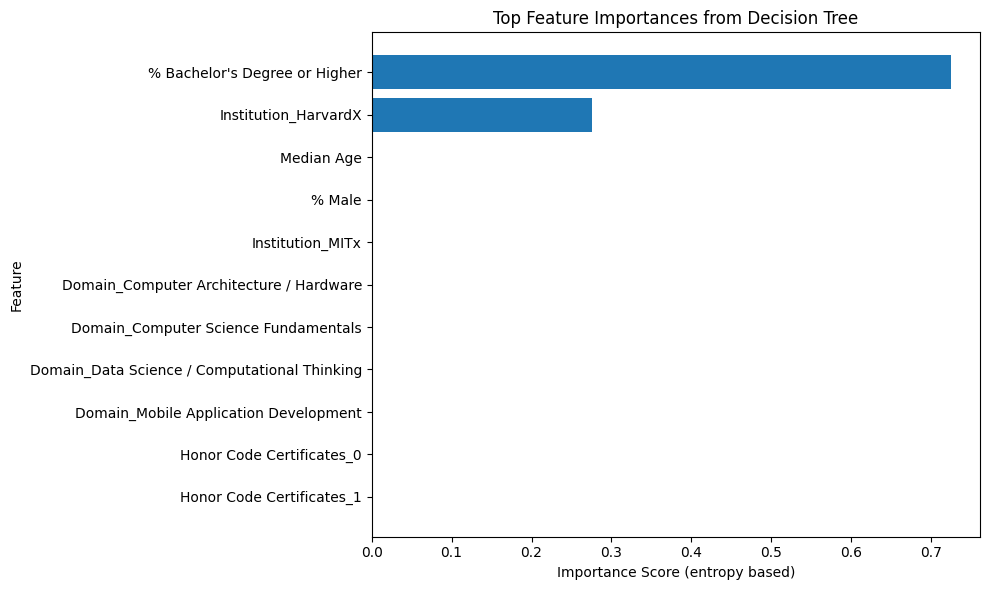


--------------------------------------------------
Note: Gini Index / Entropy (for Information Gain) per Node
--------------------------------------------------
The Entropy value calculated at each node (used for splitting) is displayed
within the nodes of the decision tree visualization below.
(Lower values indicate higher purity within the node).

--- Visualizing Decision Tree ---


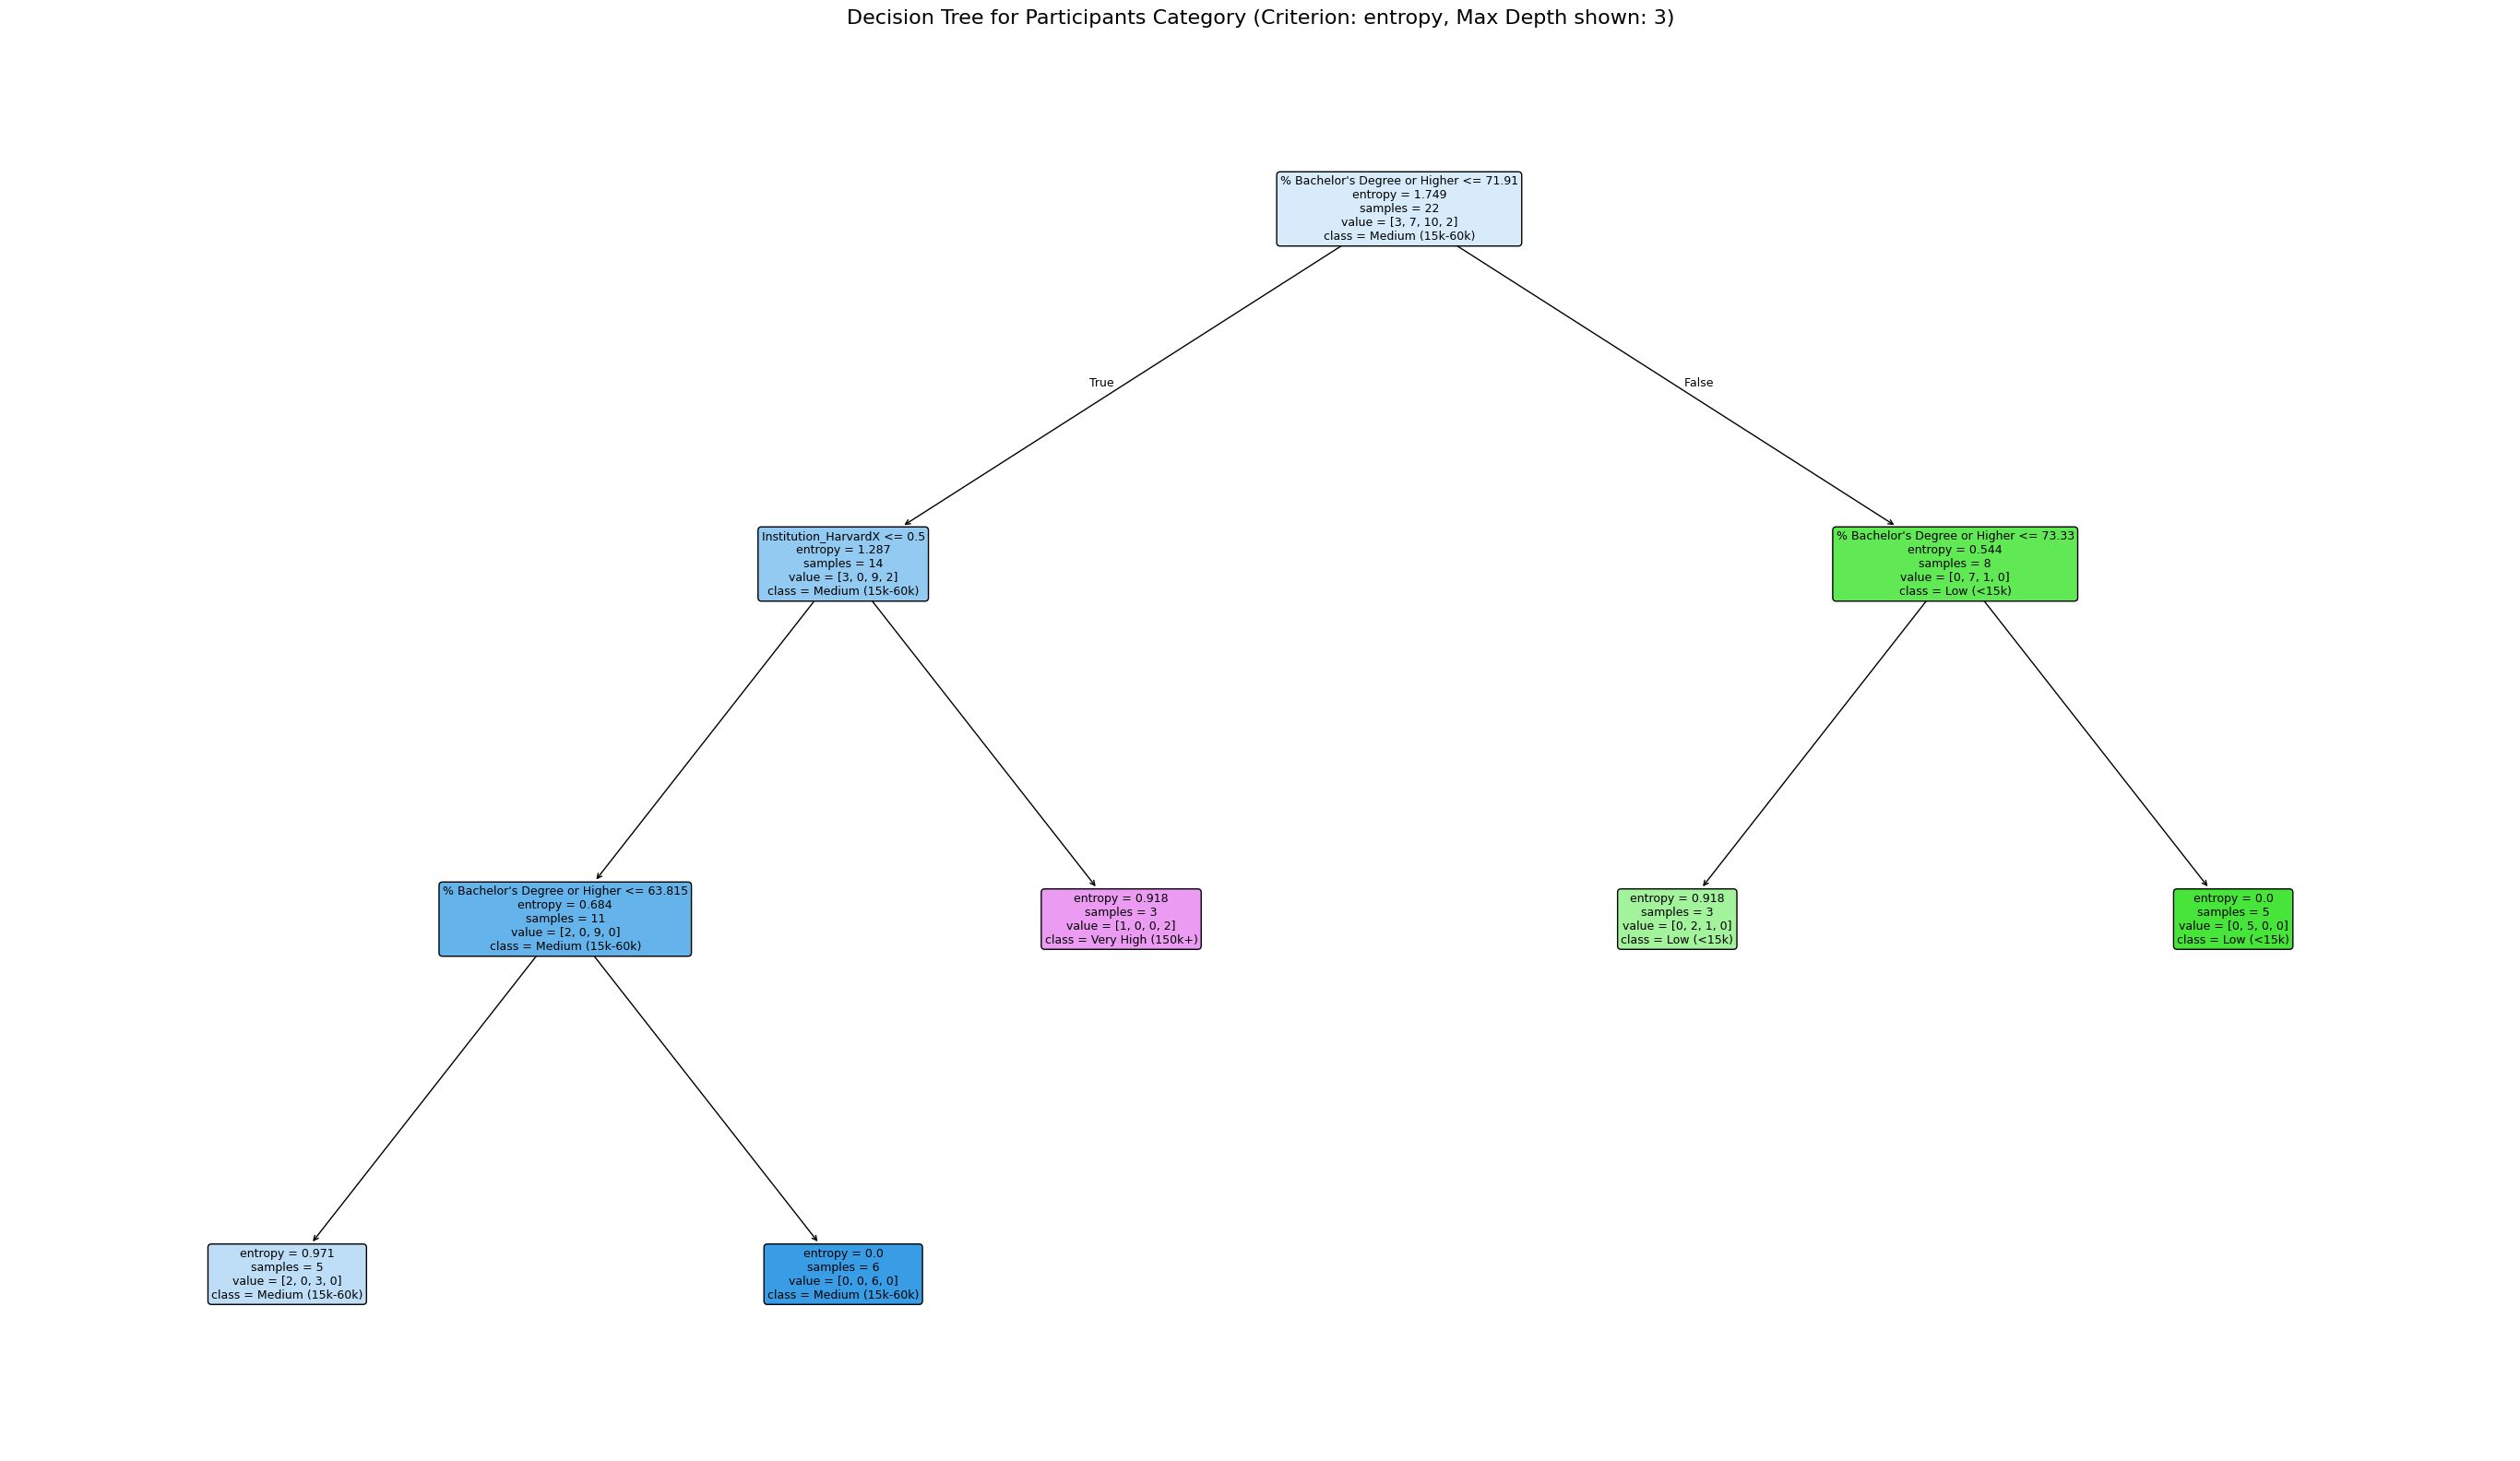


--- Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import graphviz # Optional, but needed for some plot_tree details if not using matplotlib backend directly

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. File Upload ---
print("Please upload your XLSX dataset file:")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("\nNo file uploaded. Please run the cell again and upload the file.")
else:
    # Get the filename (assuming only one file uploaded)
    file_name = next(iter(uploaded))
    print(f"\nUploaded file '{file_name}'")

    # --- 2. Load Data ---
    try:
        # Read the uploaded bytes into a pandas DataFrame
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        print(f"Successfully loaded data from {file_name}")
        print(f"Initial data shape: {df.shape}")
    except Exception as e:
        print(f"\nError loading data from {file_name}: {e}")
        df = None # Ensure df is None if loading fails

# Proceed only if data loading was successful
if df is not None:

    # --- 3. Configuration & Column Selection ---
    target_column_raw = 'Participants (Course Content Accessed)'
    target_column_binned = target_column_raw + '_binned'

    # Define predictor columns based on final decision (INSTITUTION ADDED)
    categorical_features = [
        'Institution', # Added as requested
        'Domain',
        'Honor Code Certificates' # Treat as categorical 0/1
    ]
    numerical_features = [
        'Median Age',
        '% Male',
        # '% Female' is excluded as it's redundant with % Male
        "% Bachelor's Degree or Higher"
    ]
    features_to_use = categorical_features + numerical_features

    # Select only necessary columns + target
    columns_to_keep = features_to_use + [target_column_raw]
    # Check if all columns exist
    missing_req_cols = [col for col in columns_to_keep if col not in df.columns]
    if missing_req_cols:
        print(f"\nError: The following required columns are missing from the dataset: {missing_req_cols}")
        df = None # Stop processing
    else:
        df_selected = df[columns_to_keep].copy()
        print(f"\nSelected relevant columns. Shape: {df_selected.shape}")


# Proceed only if column selection was successful
if df is not None and 'df_selected' in locals():

    # --- 4. Data Preprocessing ---
    print("\n--- Starting Data Preprocessing ---")

    # --- 4a. Handle Missing Values ---
    print("\nChecking for missing values...")
    # print(df_selected.isnull().sum()) # Less verbose for final script

    imputed_cols_count = 0
    # Impute numerical features with median
    for col in numerical_features:
        if df_selected[col].isnull().any():
            median_val = df_selected[col].median()
            df_selected[col].fillna(median_val, inplace=True)
            # print(f"Imputed missing values in '{col}' with median ({median_val}).")
            imputed_cols_count+=1

    # Impute categorical features with mode
    for col in categorical_features:
         if df_selected[col].isnull().any():
            mode_val = df_selected[col].mode()[0] # Get the most frequent value
            df_selected[col].fillna(mode_val, inplace=True)
            # print(f"Imputed missing values in '{col}' with mode ('{mode_val}').")
            imputed_cols_count+=1

    if imputed_cols_count > 0:
         print(f"Missing values handled via imputation (median/mode) in {imputed_cols_count} column(s).")
    else:
         print("No missing values found in selected columns.")

    # --- 4b. Bin the Target Variable ---
    print(f"\nBinning the target variable: '{target_column_raw}'")
    # Analyze distribution to set bins (crucial step!)
    print("\nDistribution of target variable (for choosing bins):")
    print(df_selected[target_column_raw].describe())

    # !!!!!!!!!! USER ACTION REQUIRED !!!!!!!!!!
    # DEFINE BINS AND LABELS BASED ON 'describe()' OUTPUT AND YOUR GOALS
    # Example bins (adjust based on your data's min/max/quartiles):
    bins = [-1, 15000, 60000, 150000, float('inf')] # Example based on provided data's quartiles roughly
    labels = ['Low (<15k)', 'Medium (15k-60k)', 'High (60k-150k)', 'Very High (150k+)'] # Adjust labels to match bins
    print(f"\nUsing bins: {bins} with labels: {labels}")
    # !!!!!!!!!! END USER ACTION !!!!!!!!!!

    df_selected[target_column_binned] = pd.cut(df_selected[target_column_raw], bins=bins, labels=labels, right=True)

    print(f"\nCreated binned target variable '{target_column_binned}':")
    print(df_selected[target_column_binned].value_counts())

    # Check if any rows failed binning (became NaN)
    if df_selected[target_column_binned].isnull().any():
        print("\nWarning: Some rows could not be binned. Check bin definitions and data.")
        initial_rows = len(df_selected)
        df_selected.dropna(subset=[target_column_binned], inplace=True)
        print(f"Dropped {initial_rows - len(df_selected)} rows that could not be binned.")


    # --- 4c. One-Hot Encode Categorical Features ---
    print("\nEncoding categorical features using One-Hot Encoding...")
    df_processed = pd.get_dummies(df_selected, columns=categorical_features, drop_first=False, dtype=int)
    print(f"Data shape after encoding: {df_processed.shape}")

    # --- 4d. Define Final Features (X) and Target (y) ---
    X = df_processed.drop(columns=[target_column_raw, target_column_binned]) # Drop original target and binned target
    y = df_processed[target_column_binned]

    # Store feature names *after* encoding for importance/plotting
    feature_names_encoded = X.columns.tolist()

    # --- 5. Train-Test Split ---
    print("\n--- Splitting Data ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

    # --- 6. Train Decision Tree Model ---
    print("\n--- Training Decision Tree Classifier ---")

    # !!!!! CHOOSE CRITERION !!!!!
    # criterion_choice = 'gini' # Use Gini Index for splitting
    criterion_choice = 'entropy' # Use Information Gain (Entropy) for splitting
    # !!!!! END CHOICE !!!!!

    print(f"Using criterion: '{criterion_choice}'")

    dt_classifier = DecisionTreeClassifier(
        criterion=criterion_choice,
        max_depth=5,            # Max depth to prevent overfitting (tune this)
        min_samples_leaf=3,     # Min samples in a leaf node (tune this - lowered slightly for small dataset)
        random_state=42
    )

    dt_classifier.fit(X_train, y_train)
    print("Training complete.")

    # --- 7. Evaluate Model ---
    print("\n--- Evaluating Model on Test Set ---")
    y_pred = dt_classifier.predict(X_test)

    # --- 7a. Accuracy ---
    accuracy = accuracy_score(y_test, y_pred)
    print("\n--------------------------------------------------")
    print(f"Metric: Overall Accuracy")
    print("--------------------------------------------------")
    print(f"{accuracy:.4f}")

    # --- 7b. Classification Report (Table) ---
    print("\n--------------------------------------------------")
    print("Metric: Classification Report (Precision, Recall, F1-Score per Class)")
    print("--------------------------------------------------")
    report_labels = sorted(y.astype(str).unique())
    try:
        # Use pandas to format the report nicely
        report_dict = classification_report(y_test, y_pred, target_names=report_labels, zero_division=0, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        print(report_df.round(4)) # Print DataFrame rounded
    except ValueError as ve:
        print(f"Warning generating classification report: {ve}")
        print("Using default text report.")
        print(classification_report(y_test, y_pred, zero_division=0))


    # --- 7c. Confusion Matrix (Table) ---
    print("\n--------------------------------------------------")
    print("Metric: Confusion Matrix")
    print("--------------------------------------------------")
    cm = confusion_matrix(y_test, y_pred, labels=report_labels)
    cm_df = pd.DataFrame(cm, index=[f"Actual: {label}" for label in report_labels],
                         columns=[f"Predicted: {label}" for label in report_labels])
    print(cm_df)

    # --- 8. Feature Importance (Gini Importance or Information Gain based) ---
    print("\n--------------------------------------------------")
    importance_metric_name = "Gini Importance (Mean Decrease in Impurity)" if criterion_choice == 'gini' else "Feature Importance (Mean Decrease in Entropy / Info Gain based)"
    print(f"Metric: {importance_metric_name}")
    print("--------------------------------------------------")
    importances = dt_classifier.feature_importances_

    # Create a DataFrame for the table output
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_encoded,
        'Importance Score': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False).reset_index(drop=True)

    # Display the table
    print(feature_importance_df)

    # --- 8a. Plot Feature Importances ---
    print(f"\n--- Plotting Top Feature Importances ({importance_metric_name}) ---")
    plt.figure(figsize=(10, max(6, len(feature_importance_df)//2))) # Adjust height based on number of features
    plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance Score'][:20]) # Plot top 20 or fewer
    plt.xlabel(f"Importance Score ({criterion_choice} based)")
    plt.ylabel("Feature")
    plt.title("Top Feature Importances from Decision Tree")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # --- 9. Gini Index / Information Gain (Entropy) at Nodes ---
    print("\n--------------------------------------------------")
    print("Note: Gini Index / Entropy (for Information Gain) per Node")
    print("--------------------------------------------------")
    node_criterion_name = "Gini Index" if criterion_choice == 'gini' else "Entropy"
    print(f"The {node_criterion_name} value calculated at each node (used for splitting) is displayed")
    print("within the nodes of the decision tree visualization below.")
    print("(Lower values indicate higher purity within the node).")


    # --- 10. Visualize Decision Tree ---
    print("\n--- Visualizing Decision Tree ---")
    plt.figure(figsize=(35, 20)) # Adjust figure size significantly

    plot_tree(dt_classifier,
              filled=True,
              rounded=True,
              class_names=report_labels,
              feature_names=feature_names_encoded,
              # impurity=True, # Shows the gini/entropy value in each node
              # proportion=True, # Shows proportions instead of counts in value array
              max_depth=4,              # Limit plot depth for readability (adjust as needed)
              fontsize=9)               # Adjust font size

    plt.title(f"Decision Tree for Participants Category (Criterion: {criterion_choice}, Max Depth shown: {min(4, dt_classifier.get_depth())})", fontsize=16)
    plt.show()

    print("\n--- Analysis Complete ---")

Please upload your XLSX dataset file:


Saving xx.xlsx to xx (4).xlsx

Uploaded file 'xx (4).xlsx'
Successfully loaded data from xx (4).xlsx
Initial data shape: (30, 8)

Selected relevant columns. Shape: (30, 7)

--- Starting Data Preprocessing ---

Checking for missing values...
No missing values found in selected columns.

Binning the target variable: 'Participants (Course Content Accessed)'

Distribution of target variable (for choosing bins):
count        30.000000
mean      50911.133333
std       72823.868447
min         322.000000
25%       13361.750000
50%       21040.000000
75%       56450.500000
max      301082.000000
Name: Participants (Course Content Accessed), dtype: float64

Using bins: [-1, 15000, 60000, 150000, inf] with labels: ['Low (<15k)', 'Medium (15k-60k)', 'High (60k-150k)', 'Very High (150k+)']

Created binned target variable 'Participants (Course Content Accessed)_binned':
Participants (Course Content Accessed)_binned
Medium (15k-60k)     13
Low (<15k)           10
High (60k-150k)       4
Very High (1

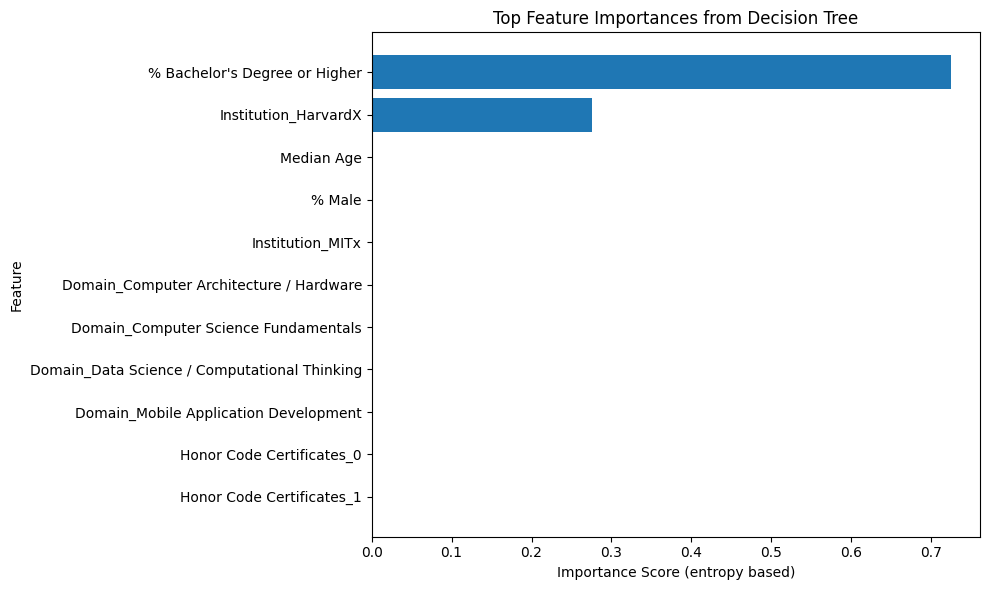


--------------------------------------------------
Note: Gini Index / Entropy (for Information Gain) per Node
--------------------------------------------------
The Entropy value calculated at each node (used for splitting) is displayed
within the nodes of the decision tree visualization below.
(Lower values indicate higher purity within the node).

--- Visualizing Decision Tree ---


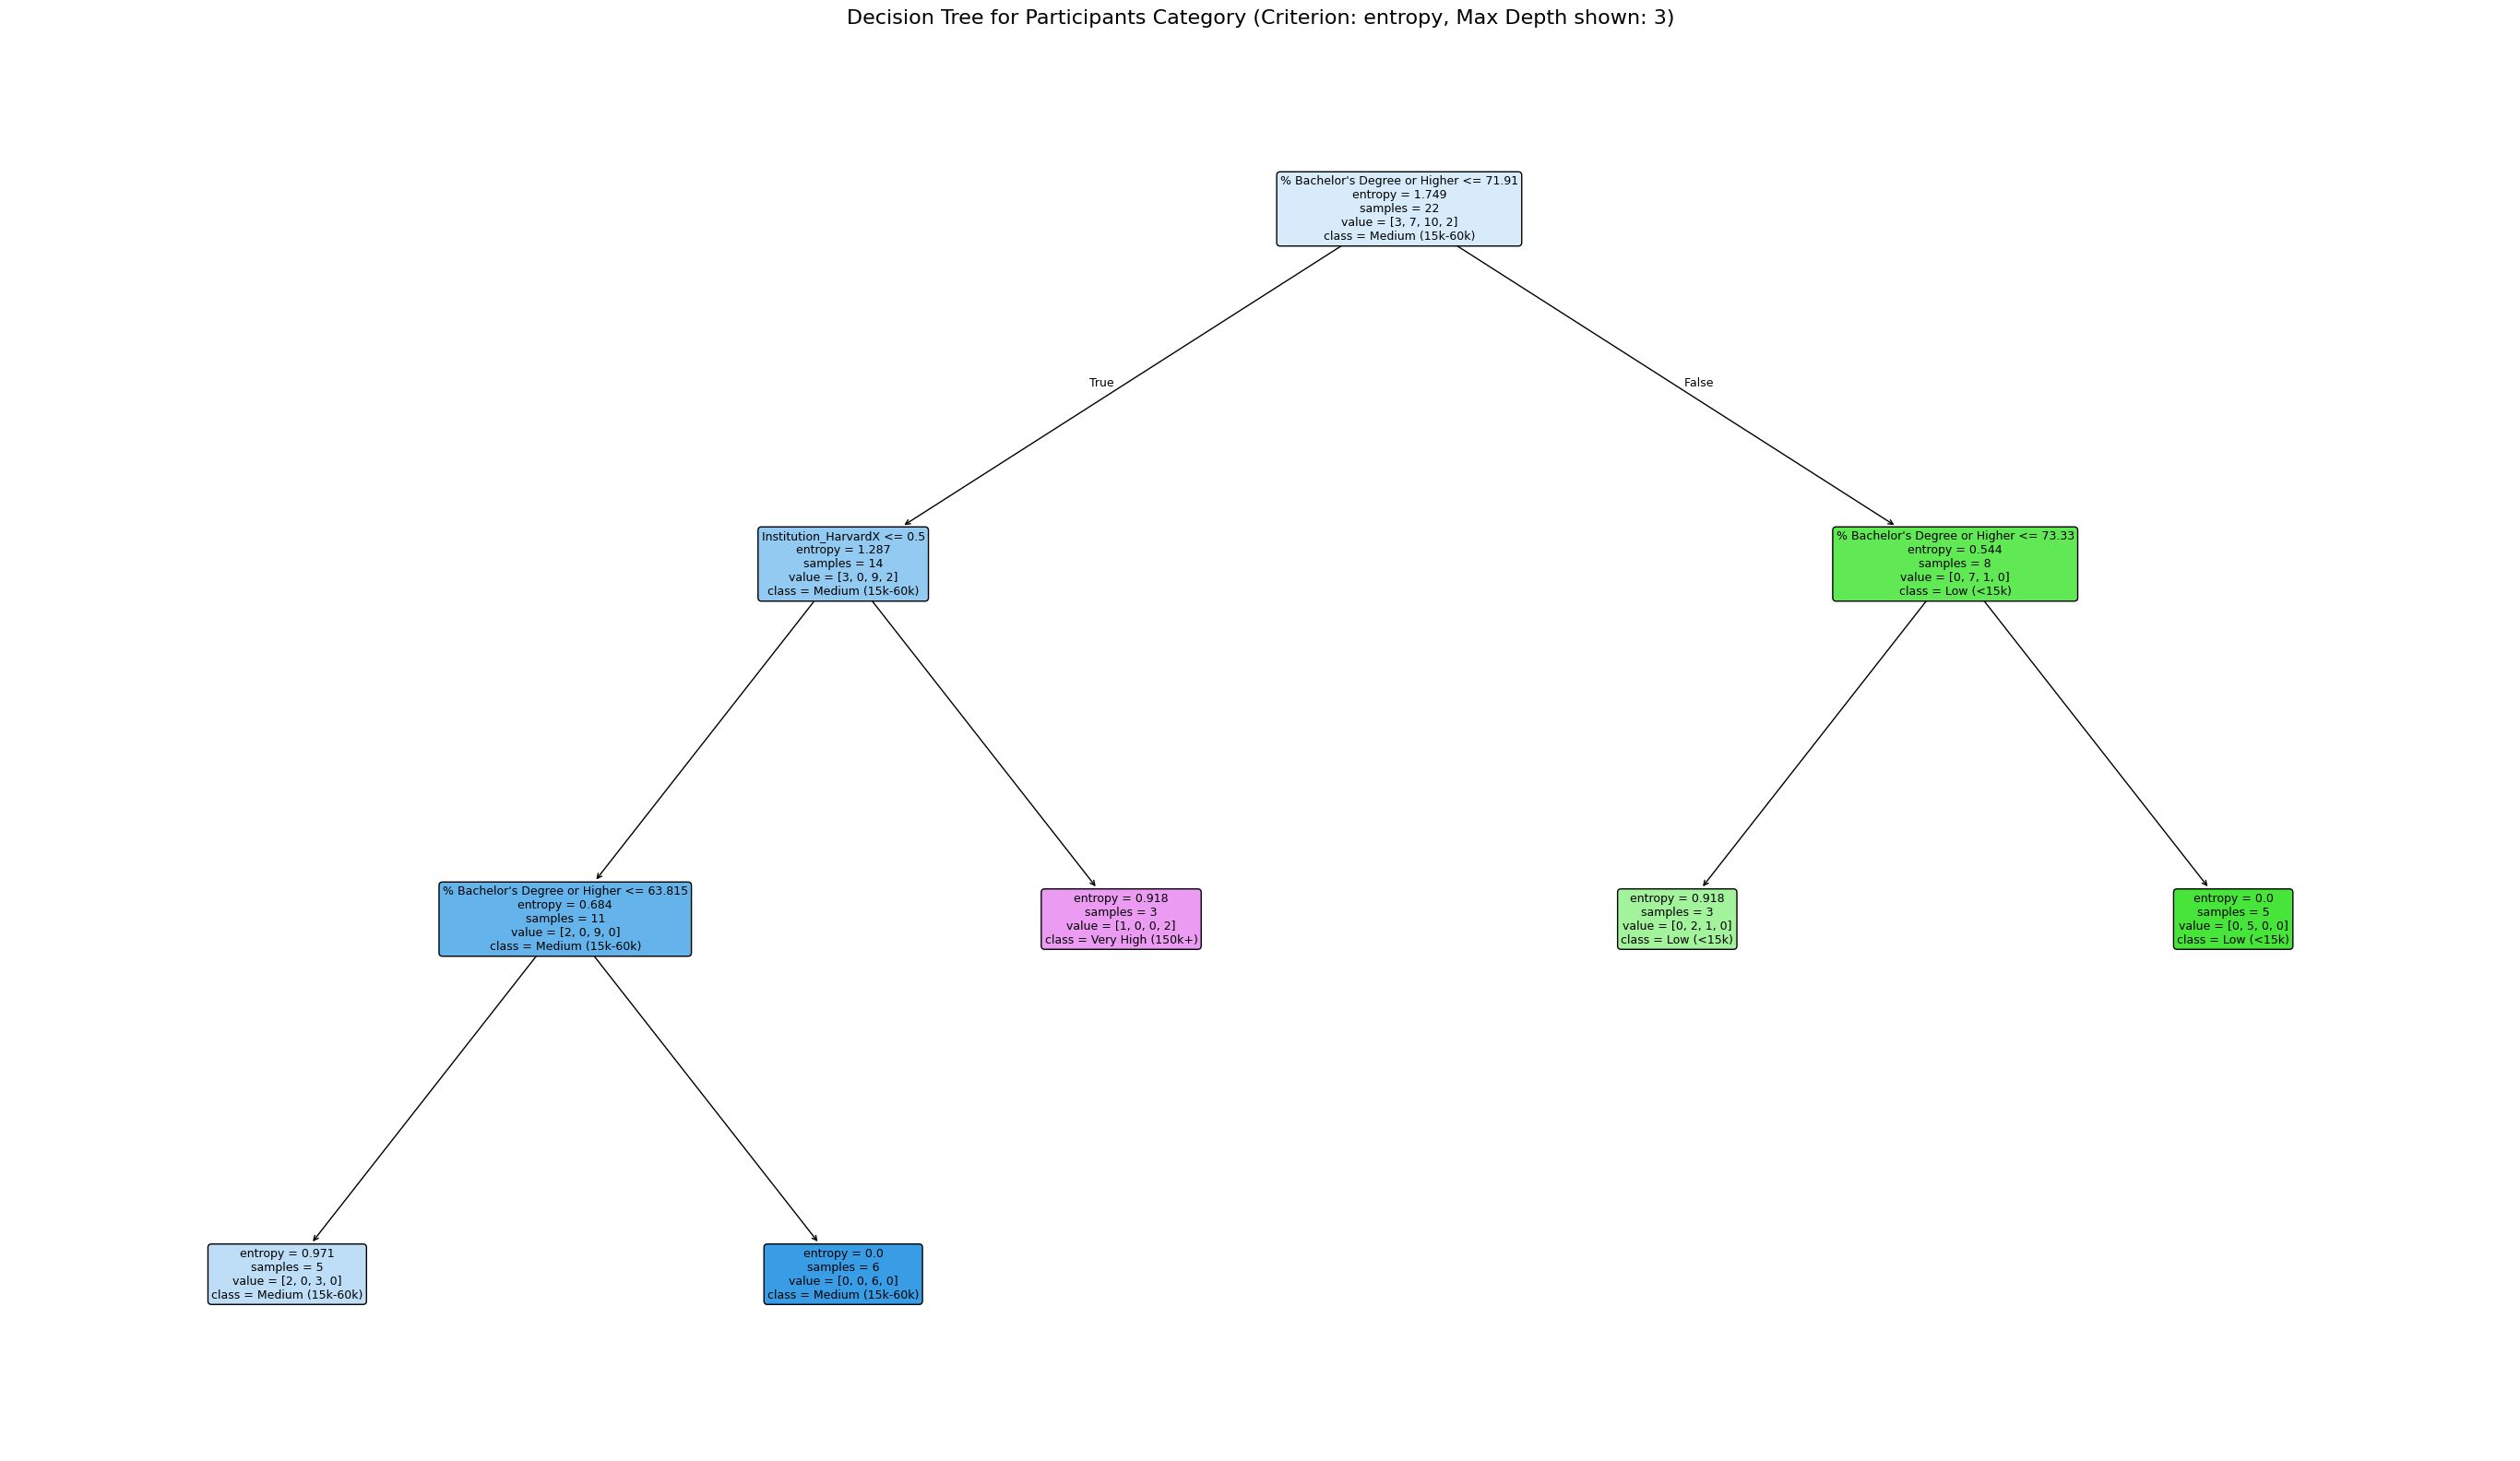


--- Analysis Complete ---

--- Other Decision Tree Metrics ---
Actual Depth of the Trained Tree: 3
Number of Leaf Nodes: 5
Total Number of Nodes (Internal + Leaves): 9
Splitting Criterion Used: 'entropy'
Feature importance calculated is based on Information Gain (Mean Decrease in Entropy).


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import graphviz # Optional, but needed for some plot_tree details if not using matplotlib backend directly

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. File Upload ---
print("Please upload your XLSX dataset file:")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("\nNo file uploaded. Please run the cell again and upload the file.")
else:
    # Get the filename (assuming only one file uploaded)
    file_name = next(iter(uploaded))
    print(f"\nUploaded file '{file_name}'")

    # --- 2. Load Data ---
    try:
        # Read the uploaded bytes into a pandas DataFrame
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        print(f"Successfully loaded data from {file_name}")
        print(f"Initial data shape: {df.shape}")
    except Exception as e:
        print(f"\nError loading data from {file_name}: {e}")
        df = None # Ensure df is None if loading fails

# Proceed only if data loading was successful
if df is not None:

    # --- 3. Configuration & Column Selection ---
    target_column_raw = 'Participants (Course Content Accessed)'
    target_column_binned = target_column_raw + '_binned'

    # Define predictor columns based on final decision (INSTITUTION ADDED)
    categorical_features = [
        'Institution', # Added as requested
        'Domain',
        'Honor Code Certificates' # Treat as categorical 0/1
    ]
    numerical_features = [
        'Median Age',
        '% Male',
        # '% Female' is excluded as it's redundant with % Male
        "% Bachelor's Degree or Higher"
    ]
    features_to_use = categorical_features + numerical_features

    # Select only necessary columns + target
    columns_to_keep = features_to_use + [target_column_raw]
    # Check if all columns exist
    missing_req_cols = [col for col in columns_to_keep if col not in df.columns]
    if missing_req_cols:
        print(f"\nError: The following required columns are missing from the dataset: {missing_req_cols}")
        df = None # Stop processing
    else:
        df_selected = df[columns_to_keep].copy()
        print(f"\nSelected relevant columns. Shape: {df_selected.shape}")


# Proceed only if column selection was successful
if df is not None and 'df_selected' in locals():

    # --- 4. Data Preprocessing ---
    print("\n--- Starting Data Preprocessing ---")

    # --- 4a. Handle Missing Values ---
    print("\nChecking for missing values...")
    # print(df_selected.isnull().sum()) # Less verbose for final script

    imputed_cols_count = 0
    # Impute numerical features with median
    for col in numerical_features:
        if df_selected[col].isnull().any():
            median_val = df_selected[col].median()
            df_selected[col].fillna(median_val, inplace=True)
            # print(f"Imputed missing values in '{col}' with median ({median_val}).")
            imputed_cols_count+=1

    # Impute categorical features with mode
    for col in categorical_features:
         if df_selected[col].isnull().any():
            mode_val = df_selected[col].mode()[0] # Get the most frequent value
            df_selected[col].fillna(mode_val, inplace=True)
            # print(f"Imputed missing values in '{col}' with mode ('{mode_val}').")
            imputed_cols_count+=1

    if imputed_cols_count > 0:
         print(f"Missing values handled via imputation (median/mode) in {imputed_cols_count} column(s).")
    else:
         print("No missing values found in selected columns.")

    # --- 4b. Bin the Target Variable ---
    print(f"\nBinning the target variable: '{target_column_raw}'")
    # Analyze distribution to set bins (crucial step!)
    print("\nDistribution of target variable (for choosing bins):")
    print(df_selected[target_column_raw].describe())

    # !!!!!!!!!! USER ACTION REQUIRED !!!!!!!!!!
    # DEFINE BINS AND LABELS BASED ON 'describe()' OUTPUT AND YOUR GOALS
    # Example bins (adjust based on your data's min/max/quartiles):
    bins = [-1, 15000, 60000, 150000, float('inf')] # Example based on provided data's quartiles roughly
    labels = ['Low (<15k)', 'Medium (15k-60k)', 'High (60k-150k)', 'Very High (150k+)'] # Adjust labels to match bins
    print(f"\nUsing bins: {bins} with labels: {labels}")
    # !!!!!!!!!! END USER ACTION !!!!!!!!!!

    df_selected[target_column_binned] = pd.cut(df_selected[target_column_raw], bins=bins, labels=labels, right=True)

    print(f"\nCreated binned target variable '{target_column_binned}':")
    print(df_selected[target_column_binned].value_counts())

    # Check if any rows failed binning (became NaN)
    if df_selected[target_column_binned].isnull().any():
        print("\nWarning: Some rows could not be binned. Check bin definitions and data.")
        initial_rows = len(df_selected)
        df_selected.dropna(subset=[target_column_binned], inplace=True)
        print(f"Dropped {initial_rows - len(df_selected)} rows that could not be binned.")


    # --- 4c. One-Hot Encode Categorical Features ---
    print("\nEncoding categorical features using One-Hot Encoding...")
    df_processed = pd.get_dummies(df_selected, columns=categorical_features, drop_first=False, dtype=int)
    print(f"Data shape after encoding: {df_processed.shape}")

    # --- 4d. Define Final Features (X) and Target (y) ---
    X = df_processed.drop(columns=[target_column_raw, target_column_binned]) # Drop original target and binned target
    y = df_processed[target_column_binned]

    # Store feature names *after* encoding for importance/plotting
    feature_names_encoded = X.columns.tolist()

    # --- 5. Train-Test Split ---
    print("\n--- Splitting Data ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

    # --- 6. Train Decision Tree Model ---
    print("\n--- Training Decision Tree Classifier ---")

    # !!!!! CHOOSE CRITERION !!!!!
    # criterion_choice = 'gini' # Use Gini Index for splitting
    criterion_choice = 'entropy' # Use Information Gain (Entropy) for splitting
    # !!!!! END CHOICE !!!!!

    print(f"Using criterion: '{criterion_choice}'")

    dt_classifier = DecisionTreeClassifier(
        criterion=criterion_choice,
        max_depth=5,            # Max depth to prevent overfitting (tune this)
        min_samples_leaf=3,     # Min samples in a leaf node (tune this - lowered slightly for small dataset)
        random_state=42
    )

    dt_classifier.fit(X_train, y_train)
    print("Training complete.")

    # --- 7. Evaluate Model ---
    print("\n--- Evaluating Model on Test Set ---")
    y_pred = dt_classifier.predict(X_test)

    # --- 7a. Accuracy ---
    accuracy = accuracy_score(y_test, y_pred)
    print("\n--------------------------------------------------")
    print(f"Metric: Overall Accuracy")
    print("--------------------------------------------------")
    print(f"{accuracy:.4f}")

    # --- 7b. Classification Report (Table) ---
    print("\n--------------------------------------------------")
    print("Metric: Classification Report (Precision, Recall, F1-Score per Class)")
    print("--------------------------------------------------")
    report_labels = sorted(y.astype(str).unique())
    try:
        # Use pandas to format the report nicely
        report_dict = classification_report(y_test, y_pred, target_names=report_labels, zero_division=0, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        print(report_df.round(4)) # Print DataFrame rounded
    except ValueError as ve:
        print(f"Warning generating classification report: {ve}")
        print("Using default text report.")
        print(classification_report(y_test, y_pred, zero_division=0))


    # --- 7c. Confusion Matrix (Table) ---
    print("\n--------------------------------------------------")
    print("Metric: Confusion Matrix")
    print("--------------------------------------------------")
    cm = confusion_matrix(y_test, y_pred, labels=report_labels)
    cm_df = pd.DataFrame(cm, index=[f"Actual: {label}" for label in report_labels],
                         columns=[f"Predicted: {label}" for label in report_labels])
    print(cm_df)

    # --- 8. Feature Importance (Gini Importance or Information Gain based) ---
    print("\n--------------------------------------------------")
    importance_metric_name = "Gini Importance (Mean Decrease in Impurity)" if criterion_choice == 'gini' else "Feature Importance (Mean Decrease in Entropy / Info Gain based)"
    print(f"Metric: {importance_metric_name}")
    print("--------------------------------------------------")
    importances = dt_classifier.feature_importances_

    # Create a DataFrame for the table output
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_encoded,
        'Importance Score': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False).reset_index(drop=True)

    # Display the table
    print(feature_importance_df)

    # --- 8a. Plot Feature Importances ---
    print(f"\n--- Plotting Top Feature Importances ({importance_metric_name}) ---")
    plt.figure(figsize=(10, max(6, len(feature_importance_df)//2))) # Adjust height based on number of features
    plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance Score'][:20]) # Plot top 20 or fewer
    plt.xlabel(f"Importance Score ({criterion_choice} based)")
    plt.ylabel("Feature")
    plt.title("Top Feature Importances from Decision Tree")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # --- 9. Gini Index / Information Gain (Entropy) at Nodes ---
    print("\n--------------------------------------------------")
    print("Note: Gini Index / Entropy (for Information Gain) per Node")
    print("--------------------------------------------------")
    node_criterion_name = "Gini Index" if criterion_choice == 'gini' else "Entropy"
    print(f"The {node_criterion_name} value calculated at each node (used for splitting) is displayed")
    print("within the nodes of the decision tree visualization below.")
    print("(Lower values indicate higher purity within the node).")


    # --- 10. Visualize Decision Tree ---
    print("\n--- Visualizing Decision Tree ---")
    plt.figure(figsize=(35, 20)) # Adjust figure size significantly

    plot_tree(dt_classifier,
              filled=True,
              rounded=True,
              class_names=report_labels,
              feature_names=feature_names_encoded,
              # impurity=True, # Shows the gini/entropy value in each node
              # proportion=True, # Shows proportions instead of counts in value array
              max_depth=4,              # Limit plot depth for readability (adjust as needed)
              fontsize=9)               # Adjust font size

    plt.title(f"Decision Tree for Participants Category (Criterion: {criterion_choice}, Max Depth shown: {min(4, dt_classifier.get_depth())})", fontsize=16)
    plt.show()

    print("\n--- Analysis Complete ---")
        # --- 7d. Other Tree Metrics ---
    print("\n--- Other Decision Tree Metrics ---")
    actual_depth = dt_classifier.get_depth()
    n_leaves = dt_classifier.get_n_leaves()
    n_nodes = dt_classifier.tree_.node_count # Access underlying tree structure

    print(f"Actual Depth of the Trained Tree: {actual_depth}")
    print(f"Number of Leaf Nodes: {n_leaves}")
    print(f"Total Number of Nodes (Internal + Leaves): {n_nodes}")

    # Explicitly state the criterion used for clarity
    print(f"Splitting Criterion Used: '{dt_classifier.criterion}'")
    if dt_classifier.criterion == 'gini':
        print("Feature importance calculated is based on Mean Decrease in Gini Impurity.")
    elif dt_classifier.criterion == 'entropy':
         print("Feature importance calculated is based on Information Gain (Mean Decrease in Entropy).")

Please upload your XLSX dataset file:


Saving xx.xlsx to xx.xlsx

Uploaded file 'xx.xlsx'
Successfully loaded data from xx.xlsx
Initial data shape: (30, 8)

Selected relevant columns. Shape: (30, 7)

--- Starting Data Preprocessing ---

Checking for missing values...
Institution                               0
Domain                                    0
Honor Code Certificates                   0
Median Age                                0
% Male                                    0
% Bachelor's Degree or Higher             0
Participants (Course Content Accessed)    0
dtype: int64
No missing values found in selected columns.

Binning the target variable: 'Participants (Course Content Accessed)'

Distribution of target variable:
count        30.000000
mean      50911.133333
std       72823.868447
min         322.000000
25%       13361.750000
50%       21040.000000
75%       56450.500000
max      301082.000000
Name: Participants (Course Content Accessed), dtype: float64

Created binned target variable 'Participants (Course C

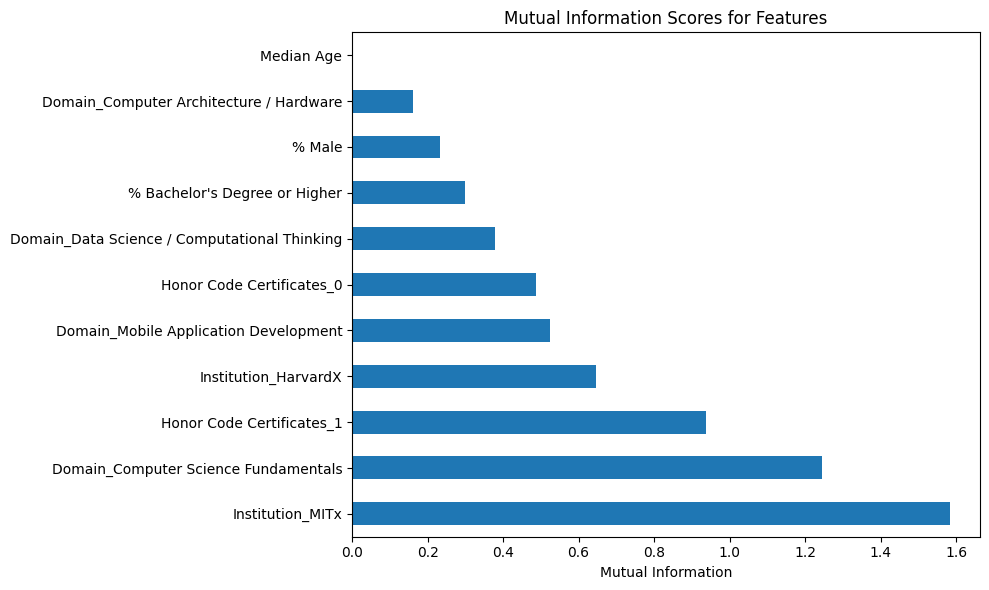


2. ANOVA F-value (Numerical Features vs. 'Participants (Course Content Accessed)_binned')
ANOVA F-test Results (Higher F / Lower P -> More Significant):
                         Feature   F-Score   P-Value
2  % Bachelor's Degree or Higher  7.233878  0.001101
1                         % Male  5.387917  0.005094
0                     Median Age  0.745541  0.534724


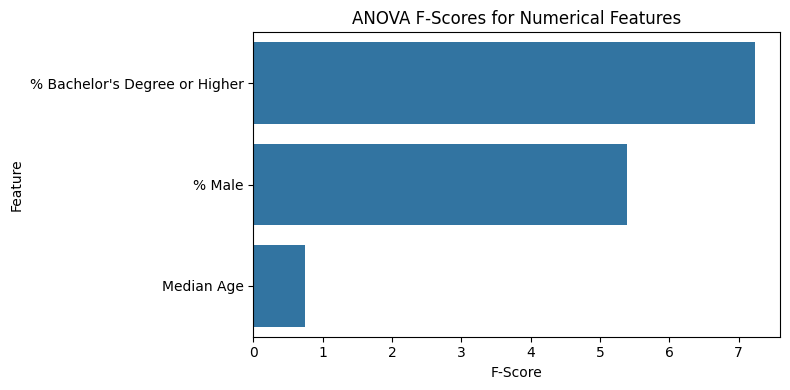


3. Chi-Squared Test (Categorical Features vs. 'Participants (Course Content Accessed)_binned')
Chi-Squared Test Results (Higher Chi2 / Lower P -> More Dependent):
                                        Feature  Chi2 Score   P-Value
0                          Institution_HarvardX   26.000000  0.000010
5         Domain_Mobile Application Development    9.285714  0.025724
6                     Honor Code Certificates_0    9.285714  0.025724
3          Domain_Computer Science Fundamentals    8.333333  0.039602
4  Domain_Data Science / Computational Thinking    5.000000  0.171797
1                              Institution_MITx    4.000000  0.261464
7                     Honor Code Certificates_1    2.826087  0.419224
2       Domain_Computer Architecture / Hardware    1.666667  0.644370


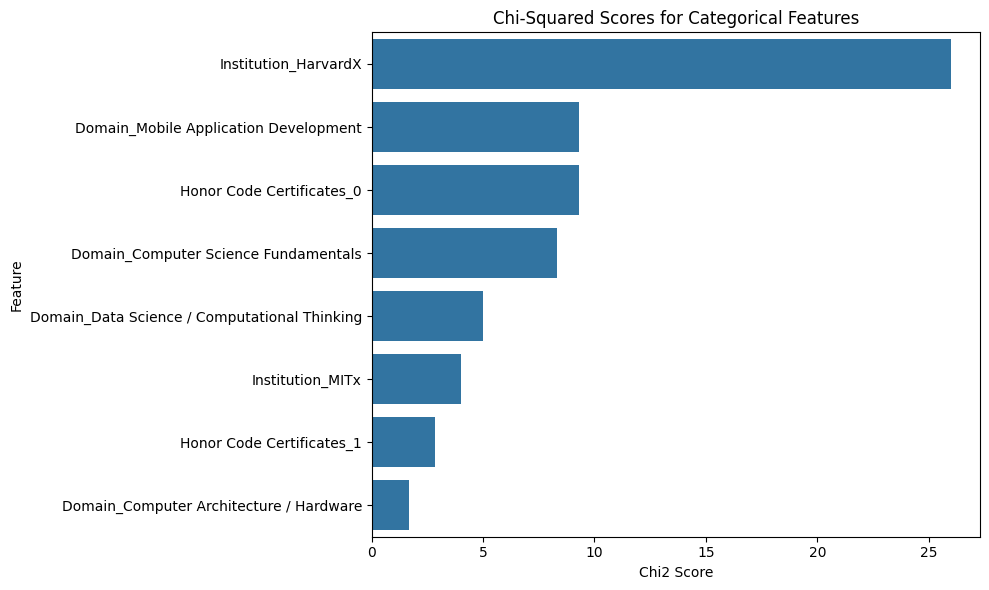


4. Pearson Correlation (Numerical Features vs. ORIGINAL 'Participants (Course Content Accessed)')
Correlation with original numerical target (Higher Absolute Value -> Stronger Linear Relationship):
Median Age                      -0.284535
% Male                          -0.441470
% Bachelor's Degree or Higher   -0.661806
Name: Participants (Course Content Accessed), dtype: float64


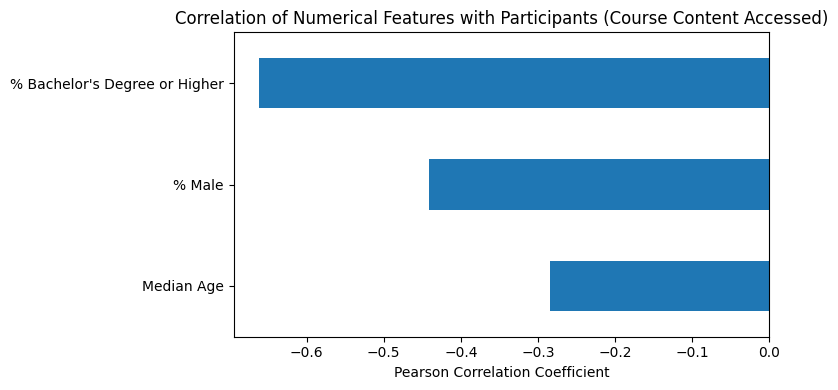


--- Feature Importance Calculation Complete ---


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # Although not strictly needed for feature selection metrics
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer # Alternatives for binning/encoding if needed
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

# --- 1. File Upload ---
print("Please upload your XLSX dataset file:")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("\nNo file uploaded. Please run the cell again and upload the file.")
else:
    # Get the filename (assuming only one file uploaded)
    file_name = next(iter(uploaded))
    print(f"\nUploaded file '{file_name}'")

    # --- 2. Load Data ---
    try:
        # Read the uploaded bytes into a pandas DataFrame
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        print(f"Successfully loaded data from {file_name}")
        print(f"Initial data shape: {df.shape}")
    except Exception as e:
        print(f"\nError loading data from {file_name}: {e}")
        df = None # Ensure df is None if loading fails

# Proceed only if data loading was successful
if df is not None:

    # --- 3. Configuration & Column Selection ---
    target_column_raw = 'Participants (Course Content Accessed)'
    target_column_binned = target_column_raw + '_binned'

    # Define predictor columns based on final decision (INCLUDING Institution)
    categorical_features = [
        'Institution',
        'Domain',
        'Honor Code Certificates' # Treat as categorical 0/1
    ]
    numerical_features = [
        'Median Age',
        '% Male',
        # '% Female' is excluded as it's redundant with % Male
        "% Bachelor's Degree or Higher"
    ]
    features_to_use = categorical_features + numerical_features

    # Select only necessary columns + target
    columns_to_keep = features_to_use + [target_column_raw]
    # Check if all columns exist
    missing_req_cols = [col for col in columns_to_keep if col not in df.columns]
    if missing_req_cols:
        print(f"\nError: The following required columns are missing from the dataset: {missing_req_cols}")
        df = None # Stop processing
    else:
        df_selected = df[columns_to_keep].copy()
        print(f"\nSelected relevant columns. Shape: {df_selected.shape}")


# Proceed only if column selection was successful
if df is not None and 'df_selected' in locals():

    # --- 4. Data Preprocessing ---
    print("\n--- Starting Data Preprocessing ---")

    # --- 4a. Handle Missing Values ---
    print("\nChecking for missing values...")
    print(df_selected.isnull().sum())
    # Add imputation here if needed (code assumes no missing values based on your previous output)
    if df_selected.isnull().any().any():
         print("\nWarning: Missing values detected. Add imputation steps before proceeding.")
         # Example: Impute numerical with median
         # for col in numerical_features:
         #     if df_selected[col].isnull().any():
         #         median_val = df_selected[col].median()
         #         df_selected[col].fillna(median_val, inplace=True)
         #         print(f"Imputed missing values in '{col}' with median ({median_val}).")
         # Example: Impute categorical with mode
         # for col in categorical_features:
         #     if df_selected[col].isnull().any():
         #         mode_val = df_selected[col].mode()[0]
         #         df_selected[col].fillna(mode_val, inplace=True)
         #         print(f"Imputed missing values in '{col}' with mode ('{mode_val}').")
    else:
        print("No missing values found in selected columns.")


    # --- 4b. Bin the Target Variable (CRUCIAL) ---
    print(f"\nBinning the target variable: '{target_column_raw}'")
    print("\nDistribution of target variable:")
    print(df_selected[target_column_raw].describe())

    # DEFINE BINS AND LABELS (ADJUST BASED ON 'describe()' OUTPUT)
    # Using the bins from your previous run:
    bins = [-1, 9999, 49999, 99999, float('inf')]
    labels = ['Low (<10k)', 'Medium (10k-50k)', 'High (50k-100k)', 'Very High (100k+)']

    df_selected[target_column_binned] = pd.cut(df_selected[target_column_raw], bins=bins, labels=labels, right=True)

    print(f"\nCreated binned target variable '{target_column_binned}':")
    print(df_selected[target_column_binned].value_counts())

    # Drop rows where binning resulted in NaN (if any)
    initial_rows = len(df_selected)
    df_selected.dropna(subset=[target_column_binned], inplace=True)
    if len(df_selected) < initial_rows:
        print(f"Dropped {initial_rows - len(df_selected)} rows that couldn't be binned.")


    # --- 4c. Prepare Data for Feature Selection Metrics ---
    # Target variable (binned, categorical)
    y_binned = df_selected[target_column_binned]
    # Target variable (original, numerical - for correlation)
    y_numerical = df_selected[target_column_raw]

    # Numerical features
    X_numerical = df_selected[numerical_features]

    # Categorical features need encoding for most metrics
    X_categorical_encoded = pd.get_dummies(df_selected[categorical_features], columns=categorical_features, drop_first=False, dtype=int)

    # Combine numerical and encoded categorical features for Mutual Information
    X_combined = pd.concat([X_numerical, X_categorical_encoded], axis=1)
    feature_names_combined = X_combined.columns.tolist()


    # --- 5. Calculate Feature Importance Metrics ---
    print("\n--- Calculating Feature Selection Metrics ---")

    # --- 5a. Mutual Information (Information Gain) ---
    print(f"\n1. Mutual Information / Information Gain (vs '{target_column_binned}')")
    # mutual_info_classif expects numerical features, so encoded categoricals are needed
    # It estimates MI between each feature and the discrete target variable.
    try:
        mi_scores = mutual_info_classif(X_combined, y_binned, discrete_features=False, random_state=42) # Set discrete_features based on data types if needed

        mi_results = pd.Series(mi_scores, index=feature_names_combined).sort_values(ascending=False)
        print("Mutual Information Scores (Higher is Better):")
        print(mi_results)

        # Plot Mutual Information
        plt.figure(figsize=(10, 6))
        mi_results.plot(kind='barh')
        plt.title('Mutual Information Scores for Features')
        plt.xlabel('Mutual Information')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error calculating Mutual Information: {e}")


    # --- 5b. ANOVA F-value (Numerical Features vs. Binned Target) ---
    print(f"\n2. ANOVA F-value (Numerical Features vs. '{target_column_binned}')")
    # Calculates F-statistic between each numerical feature and the discrete target.
    # Tests if the mean of the feature is significantly different across target classes.
    try:
        # Ensure no NaNs in numerical features or target before calculating
        valid_idx = X_numerical.notna().all(axis=1) & y_binned.notna()
        if valid_idx.sum() > 0: # Check if there are any valid samples
             f_scores, p_values_anova = f_classif(X_numerical[valid_idx], y_binned[valid_idx])
             anova_results = pd.DataFrame({
                 'Feature': numerical_features,
                 'F-Score': f_scores,
                 'P-Value': p_values_anova
             }).sort_values(by='F-Score', ascending=False)
             print("ANOVA F-test Results (Higher F / Lower P -> More Significant):")
             print(anova_results)

             # Plot F-Scores
             plt.figure(figsize=(8, 4))
             sns.barplot(x='F-Score', y='Feature', data=anova_results)
             plt.title('ANOVA F-Scores for Numerical Features')
             plt.xlabel('F-Score')
             plt.ylabel('Feature')
             plt.tight_layout()
             plt.show()

        else:
            print("Not enough valid data points to calculate ANOVA F-value after handling NaNs.")

    except Exception as e:
        print(f"Error calculating ANOVA F-value: {e}")


    # --- 5c. Chi-Squared (Encoded Categorical Features vs. Binned Target) ---
    print(f"\n3. Chi-Squared Test (Categorical Features vs. '{target_column_binned}')")
    # Calculates Chi2 statistic between each non-negative categorical feature and the discrete target.
    # Tests if the feature is independent of the target class.
    try:
        # Ensure data is non-negative (should be true for OHE)
        if (X_categorical_encoded < 0).any().any():
            print("Warning: Chi-squared requires non-negative features. Check encoding.")
        else:
            valid_idx_cat = X_categorical_encoded.notna().all(axis=1) & y_binned.notna()
            if valid_idx_cat.sum() > 0: # Check if there are any valid samples
                chi2_scores, p_values_chi2 = chi2(X_categorical_encoded[valid_idx_cat], y_binned[valid_idx_cat])
                chi2_results = pd.DataFrame({
                    'Feature': X_categorical_encoded.columns,
                    'Chi2 Score': chi2_scores,
                    'P-Value': p_values_chi2
                }).sort_values(by='Chi2 Score', ascending=False)
                print("Chi-Squared Test Results (Higher Chi2 / Lower P -> More Dependent):")
                print(chi2_results)

                # Plot Chi2 Scores
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Chi2 Score', y='Feature', data=chi2_results)
                plt.title('Chi-Squared Scores for Categorical Features')
                plt.xlabel('Chi2 Score')
                plt.ylabel('Feature')
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough valid data points to calculate Chi-Squared after handling NaNs.")


    except ValueError as ve:
         print(f"Error calculating Chi-Squared: {ve}")
         print("This often happens if a feature has zero variance (all values are the same).")
    except Exception as e:
        print(f"Error calculating Chi-Squared: {e}")

    # --- 5d. Correlation (Numerical Features vs. Original Numerical Target) ---
    print(f"\n4. Pearson Correlation (Numerical Features vs. ORIGINAL '{target_column_raw}')")
    try:
        correlation_df = pd.concat([X_numerical, y_numerical], axis=1)
        correlation_matrix = correlation_df.corr()
        # Get correlation with the target variable only
        target_correlation = correlation_matrix[target_column_raw].drop(target_column_raw).sort_values(ascending=False)
        print("Correlation with original numerical target (Higher Absolute Value -> Stronger Linear Relationship):")
        print(target_correlation)

        # Plot Correlation
        plt.figure(figsize=(8, 4))
        target_correlation.plot(kind='barh')
        plt.title(f'Correlation of Numerical Features with {target_column_raw}')
        plt.xlabel('Pearson Correlation Coefficient')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error calculating Correlation: {e}")


    print("\n--- Feature Importance Calculation Complete ---")